In [35]:
import random
import pickle

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

import plotly as py
print (py.__version__) # requires version >= 1.9.0\n",
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

from matplotlib import pyplot as plt
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sqlalchemy import create_engine
# connection details
%run se.py

random_state=42

3.4.0


In [2]:
data_file = "headline_lemmas_id_positive.txt"

headline_ids=[]
headlines=[]
orig_headlines=[]
statuses=[]

with open(data_file, 'r') as hfile:
    raw_lines = [h.strip() for h in hfile]
    for h in raw_lines:
        h_split = h.split("|")
        try:
            h_id, h_text, h_orig, h_status = h_split[:4]
        except:
            print(h)

        h_id = int(h_id)
        headline_ids.append(h_id)
        headlines.append(h_text)
        orig_headlines.append(h_orig)
        statuses.append(h_status)
headlines[0:10]

['todd sullivan instagram dont even try hide jealousy instagram',
 'ai could soon around us could upend different industry business_insider',
 'richardaepstein beginning case single payer hooverinst audioboom_com',
 'condition theory obstruct research progress semanticscholar_org',
 'softly softly british pm may enforcer gear big reuters',
 'satisfy part travel flight hotel la_times',
 'money save tip try spending money month bbc three bbc',
 'new_york_city raid condo build crackdown airbnb rental wall_street_journal',
 'logic point people vote instead face political collapse the_guardian',
 'marine mysterious death world war final day still haunt family washington_post']

In [3]:
bigframe = pd.DataFrame({'id': headline_ids, 'headline': headlines, 'orig': orig_headlines, 'status': statuses})
bigframe.head()

id                                           headline  \
0  3602059  todd sullivan instagram dont even try hide jea...   
1  3602050  ai could soon around us could upend different ...   
2  3602042  richardaepstein beginning case single payer ho...   
3  3602035  condition theory obstruct research progress se...   
4  3602023  softly softly british pm may enforcer gear big...   

                                                orig status  
0  todd sullivan on Instagram: Dont even try and ...      0  
1  AI could soon be all around us  here's how tha...      0  
2  @RichardAEpstein: Beginning the case against s...      0  
3  Under what conditions does theory obstruct res...      0  
4  Softly, softly for now, British PM May's enfor...      0

In [4]:
# smaller sample for clustering because it runs out of memory
smallframe = bigframe.loc[bigframe.status=='1']
fp_ids = list(smallframe["id"])
fp_indexes = list(smallframe.index)

# smallest sample to plot a few observations
# 100 random sample of status = 1
test_ids = random.sample(list(bigframe.loc[bigframe.status=='1']["id"]),100)
# 100 top headlines in db
test_ids.extend([3256999,3405443,3396402,3249263,3490739,3513466,3348419,3124165,3477501,3226156,3156249,3099343,3312205,3454624,3153632,3502530,3101140,2840090,3595531,3146553,3278651,3381642,2910180,3361343,3419612,3340254,3102600,3379802,3480427,3540112,3354079,2838339,3423521,3447513,3101161,3301139,3507486,3385633,3102247,3440007,3435359,3396228,3125154,3291306,3501518,3517768,3392387,3434668,2953750,3474738,3446868,2860690,2828821,3362851,3440973,3180384,3563958,3566548,3239438,3249682,3215207,3404701,3572387,3165885,3481563,2989291,3203314,3349750,3372726,3410359,3313088,2902480,3381978,3301600,3268358,3339534,3563825,3194017,3312555,3160764,3251468,3575309,3543568,3383316,2910296,3134308,2926460,3573900,3466659,3252659,3472590,3503860,3564845,3397941,3569721,3540796,3426638,3289442,3257502,3211426])

test_indexes = [headline_ids.index(hid) for hid in test_ids]
hs = [headlines[i] for i in test_indexes]
ohs = [orig_headlines[i] for i in test_indexes]
list(zip(ohs, hs))

[('Shkreli vs. Holmes: 2 Frauds, 2 Divergent Outcomes. Were They Fair? - New York Times',
  'shkreli vs holmes fraud divergent outcomes fair new_york_times'),
 ('Maggie Haberman: Why I Needed to Pull Back From Twitter - New York Times',
  'maggie haberman need pull back twitter new_york_times'),
 ('A Trio of Wealthy Russians Made an Enemy of Putin. Now Theyre All Dead. - Wall Street Journal',
  'trio wealthy russian make enemy putin theyre dead wall_street_journal'),
 ('Critics say Alexandria Ocasio-Cortez cant hang with the intellectual heavyweights ... in Congress - Vox',
  'critic say alexandria ocasio cortez cant hang intellectual heavyweight congress vox'),
 ('Trump Threatens Auto Tariffs Despite Widespread Opposition - Wall Street Journal',
  'trump threaten auto tariff despite widespread opposition wall_street_journal'),
 ('Top Tech Companies Met With Intelligence Officials to Discuss Midterms - New York Times',
  'top tech company meet intelligence official discuss midterm new_

In [5]:
def print_top_words(model, feature_names, n_top_words):
    """Given topic vectors, print top headlines for each topic"""
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [6]:
num_topics = 80
num_clusters = 12

In [7]:
%%time
# TFIDF

#vectorizer = CountVectorizer()

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=10,
                                   max_features=15000)

print('Vectorizing with TFIDF')
X = tfidf_vectorizer.fit_transform(headlines)
feature_names = tfidf_vectorizer.get_feature_names()

Vectorizing with TFIDF
CPU times: user 2.02 s, sys: 24 ms, total: 2.04 s
Wall time: 2.05 s


In [8]:
%%time
# LSI
tfidf_corpus = matutils.Sparse2Corpus(X.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=num_topics)

2018-11-14 14:24:45,507 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:45,584 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:45,659 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:45,737 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:45,814 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:45,890 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:45,967 : INFO : adding document #60000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:46,044 : INFO : adding document #70000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:46,121 : INFO : adding document #80000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:46,198 : INFO : adding document #90000 to Dictionary(0 unique tokens: [])
2018-11-14 14:24:46,275 : INFO : adding document #100000 to Dictionary(0 unique tokens: [])
20

2018-11-14 14:24:50,330 : INFO : preparing a new chunk of documents
2018-11-14 14:24:50,435 : INFO : using 100 extra samples and 2 power iterations
2018-11-14 14:24:50,437 : INFO : 1st phase: constructing (15000, 180) action matrix
2018-11-14 14:24:50,598 : INFO : orthonormalizing (15000, 180) action matrix
2018-11-14 14:24:50,842 : INFO : 2nd phase: running dense svd on (180, 20000) matrix
2018-11-14 14:24:50,949 : INFO : computing the final decomposition
2018-11-14 14:24:50,950 : INFO : keeping 80 factors (discarding 38.469% of energy spectrum)
2018-11-14 14:24:50,953 : INFO : merging projections: (15000, 80) + (15000, 80)
2018-11-14 14:24:50,982 : INFO : keeping 80 factors (discarding 10.536% of energy spectrum)
2018-11-14 14:24:50,991 : INFO : processed documents up to #80000
2018-11-14 14:24:50,992 : INFO : topic #0(19.474): 0.324*"trump" + 0.294*"us" + 0.270*"say" + 0.194*"kavanaugh" + 0.190*"reuters" + 0.184*"china" + 0.171*"new" + 0.168*"bloomberg" + 0.157*"washington_post" + 0

2018-11-14 14:24:53,942 : INFO : 2nd phase: running dense svd on (180, 20000) matrix
2018-11-14 14:24:54,069 : INFO : computing the final decomposition
2018-11-14 14:24:54,071 : INFO : keeping 80 factors (discarding 37.033% of energy spectrum)
2018-11-14 14:24:54,075 : INFO : merging projections: (15000, 80) + (15000, 80)
2018-11-14 14:24:54,107 : INFO : keeping 80 factors (discarding 5.751% of energy spectrum)
2018-11-14 14:24:54,118 : INFO : processed documents up to #160000
2018-11-14 14:24:54,120 : INFO : topic #0(28.108): 0.373*"trump" + 0.333*"us" + 0.250*"say" + 0.246*"bloomberg" + 0.208*"reuters" + 0.204*"china" + 0.150*"new" + 0.126*"washington_post" + 0.124*"new_york_times" + 0.116*"tariff"
2018-11-14 14:24:54,121 : INFO : topic #1(20.425): -0.677*"trump" + 0.401*"us" + 0.250*"reuters" + -0.219*"washington_post" + 0.198*"china" + -0.165*"new_york_times" + 0.136*"bloomberg" + 0.135*"financial_times" + -0.099*"kavanaugh" + -0.079*"the_hill"
2018-11-14 14:24:54,122 : INFO : topi

2018-11-14 14:24:57,534 : INFO : merging projections: (15000, 80) + (15000, 80)
2018-11-14 14:24:57,565 : INFO : keeping 80 factors (discarding 4.634% of energy spectrum)
2018-11-14 14:24:57,577 : INFO : processed documents up to #240000
2018-11-14 14:24:57,579 : INFO : topic #0(34.627): 0.354*"trump" + 0.328*"us" + 0.295*"bloomberg" + 0.250*"say" + 0.212*"reuters" + 0.191*"china" + 0.141*"new" + 0.121*"new_york_times" + 0.120*"wall_street_journal" + 0.116*"washington_post"
2018-11-14 14:24:57,581 : INFO : topic #1(24.991): -0.712*"trump" + 0.314*"us" + 0.282*"bloomberg" + -0.226*"washington_post" + 0.195*"reuters" + -0.191*"new_york_times" + 0.136*"china" + 0.125*"financial_times" + 0.090*"market" + -0.076*"the_hill"
2018-11-14 14:24:57,582 : INFO : topic #2(23.975): -0.668*"bloomberg" + 0.490*"us" + 0.401*"reuters" + 0.153*"china" + -0.104*"say" + 0.096*"tariff" + -0.091*"instagram" + 0.070*"financial_times" + -0.068*"market" + -0.059*"get"
2018-11-14 14:24:57,584 : INFO : topic #3(2

CPU times: user 56.5 s, sys: 1.1 s, total: 57.5 s
Wall time: 12.8 s


In [9]:
lsi.print_topics()

2018-11-14 14:25:08,820 : INFO : topic #0(35.700): 0.356*"trump" + 0.321*"us" + 0.299*"bloomberg" + 0.250*"say" + 0.210*"reuters" + 0.186*"china" + 0.143*"new" + 0.121*"new_york_times" + 0.120*"wall_street_journal" + 0.116*"washington_post"
2018-11-14 14:25:08,823 : INFO : topic #1(25.854): -0.720*"trump" + 0.315*"bloomberg" + 0.281*"us" + -0.225*"washington_post" + -0.185*"new_york_times" + 0.172*"reuters" + 0.125*"china" + 0.120*"financial_times" + 0.093*"market" + -0.077*"the_hill"
2018-11-14 14:25:08,826 : INFO : topic #2(24.723): -0.694*"bloomberg" + 0.478*"us" + 0.418*"reuters" + 0.143*"china" + -0.100*"say" + 0.092*"financial_times" + 0.078*"tariff" + 0.070*"wall_street_journal" + -0.057*"market" + -0.054*"instagram"
2018-11-14 14:25:08,828 : INFO : topic #3(24.221): -0.399*"bloomberg" + 0.399*"instagram" + -0.267*"us" + -0.267*"trump" + 0.255*"new" + 0.162*"new_york_times" + -0.156*"china" + 0.125*"2018" + 0.118*"financial_times" + 0.115*"wall_street_journal"
2018-11-14 14:25:0

[(0,
  '0.356*"trump" + 0.321*"us" + 0.299*"bloomberg" + 0.250*"say" + 0.210*"reuters" + 0.186*"china" + 0.143*"new" + 0.121*"new_york_times" + 0.120*"wall_street_journal" + 0.116*"washington_post"'),
 (1,
  '-0.720*"trump" + 0.315*"bloomberg" + 0.281*"us" + -0.225*"washington_post" + -0.185*"new_york_times" + 0.172*"reuters" + 0.125*"china" + 0.120*"financial_times" + 0.093*"market" + -0.077*"the_hill"'),
 (2,
  '-0.694*"bloomberg" + 0.478*"us" + 0.418*"reuters" + 0.143*"china" + -0.100*"say" + 0.092*"financial_times" + 0.078*"tariff" + 0.070*"wall_street_journal" + -0.057*"market" + -0.054*"instagram"'),
 (3,
  '-0.399*"bloomberg" + 0.399*"instagram" + -0.267*"us" + -0.267*"trump" + 0.255*"new" + 0.162*"new_york_times" + -0.156*"china" + 0.125*"2018" + 0.118*"financial_times" + 0.115*"wall_street_journal"'),
 (4,
  '0.837*"instagram" + 0.191*"us" + -0.158*"financial_times" + -0.148*"linkedin" + -0.132*"new" + 0.123*"bloomberg" + -0.115*"new_york_times" + 0.102*"trump" + 0.095*"instag

In [10]:
# Retrieve vectors for the original tfidf corpus in the gensim_model space ("transform" in sklearn)
def gensim_to_array(gensim_model):
    corpus = gensim_model[tfidf_corpus]

    # Dump the resulting document vectors into a list
    gensim_model_doc_vecs = []
    for d in corpus:
        if len(d) == 0:
            # some docs have no topics , no relevant words maybe?
            gensim_model_doc_vecs.append([0.0] * num_topics)
        else:
            indexes, coefs = zip(*d)
            if len(coefs) != num_topics:
                gensim_model_doc_vecs.append([0.0] * num_topics)
            else:
                gensim_model_doc_vecs.append(coefs)
                
    return np.array(gensim_model_doc_vecs)

lsi_doc_vecs = gensim_to_array(lsi)
print(lsi_doc_vecs[1])
len(lsi_doc_vecs)

[ 0.12840799  0.05493813  0.07537674  0.01983265  0.00234281 -0.01061435
  0.06085298  0.03523368  0.02542113 -0.056582    0.08925765  0.06864048
  0.01623663  0.02128466 -0.07792958 -0.05289804 -0.01627819 -0.02652753
 -0.07638512 -0.05446765 -0.0140182  -0.06693412  0.02909251 -0.05752586
 -0.15237867 -0.10017522  0.0805942  -0.17830553  0.34889846 -0.07453684
  0.0409075  -0.0439041  -0.03836348 -0.04217961  0.0662027  -0.05402244
  0.01818     0.01350081  0.01034026 -0.00168568 -0.04390386  0.02201841
 -0.01496236  0.03670172  0.03564276  0.03420497  0.02749078 -0.01423499
 -0.00243637 -0.00243399 -0.02614525  0.03629563 -0.00099821  0.01126047
 -0.00231498 -0.01699029 -0.02234269  0.0326079  -0.01691263  0.00482382
  0.04303718 -0.00213894 -0.00517559 -0.02166766  0.01932797  0.02104152
 -0.01533264 -0.03705773  0.00885813 -0.02698562 -0.00565358  0.04430782
 -0.03139117 -0.02504774  0.00057493  0.01479906  0.01478471 -0.00114249
 -0.00760747 -0.01097214]


255818

In [11]:
# impossible to interpret
# show highest scoring docs for each topic

def top_docs(doc_array):
    for i in range(num_topics):
        top5 = np.argsort(doc_array[:,i])[-5:].astype(int)
        print ("TOPIC %d" % i)
        for j in top5:
            print(orig_headlines[j])
        print("-------------------------------------------------------")
        
top_docs(lsi_doc_vecs)

TOPIC 0
Trump's China Tariffs Would Hit U.S. Firms More, Peterson Says - Bloomberg
Who Said It: Trump or Gotti? - New York Times
U.S. business group says Trump China tariffs cost $1.4 billion/month - Reuters
Economists Say Trump's Tariffs Are Unfavorable for U.S. Growth - Bloomberg
China Says Trump's America First Policies Are Hurting U.S. - Bloomberg
-------------------------------------------------------
TOPIC 1
U.S. Investors Just Gave Up on the Bull Market - Bloomberg
China-U.S. Trade War Kicks Off - Bloomberg
Opinion - Bloomberg - Bloomberg
China's HNA to sell U.S. properties worth $4 billion: Bloomberg - Reuters
Here's What the U.S., China Demanded of Each Other on Trade - Bloomberg
-------------------------------------------------------
TOPIC 2
U.S., EU can still talk trade after tariffs, U.S. envoy says - Reuters
Trump relents on EU car tariffs, as U.S.-China fight derails... - Reuters
EU to host U.S., Japan on steel as U.S. tariffs loom - Reuters
China relieved U.S. trade war 

TOPIC 29
Saludo de Mujeres y Lesbianas Feministas Autoconvocadas a YPJ, Kurdistan. - YouTube
   - YouTube
2000li yllarda Turkiyede Demokrasi ve Iktisadi Performans: Refet Gurkaynak ve Daron Acemo glu - YouTube
AKP Doneminde Iktisat Politikalar: Sevket Pamuk ve Refet Gurkaynak - YouTube
khatia + gvantsa buniatishvili - astor piazzolla: libertango - YouTube
-------------------------------------------------------
TOPIC 30
Bitcoin Hedge Fund Proliferation (Hedge Fund News From HedgeCo.Net) - Bloglovin
Which Hedge Fund Are You? (Hedge Fund News From HedgeCo.Net) - Bloglovin
Chinese Entrepreneur Starts $100 Million Hedge Fund With His Own Money (Hedge Fund News From HedgeCo.Net) - Bloglovin
Cryptocurrency Hedge Fund BlockTower Raises $140 Million (Hedge Fund News From HedgeCo.Net) - Bloglovin
Cryptocurrency Hedge Fund BlockTower Raises $140 Million (Hedge Fund News From HedgeCo.Net) - Bloglovin
-------------------------------------------------------
TOPIC 31
Its time to break up Facebook - T

TOPIC 49
One Belt, One Road, One Thrashing: How China took Pakistan hostage - ThePrint
Block.one - block.one
Trump One of Worst Modern Presidents, Obama One of Best, Americans Say in New Poll - Apple News
The one with the bank that had the best Superheroes - duenablomstrom.com
Why One in Five Americans Are on Government Assistance (in One Image) - independent.org
-------------------------------------------------------
TOPIC 50
The Democrats take the House. Will the president need more lawyers? - KCRW
Everything You Need to Know About New All Time Highs - YouTube
STD Cases Just Reached a Record High in California. Here's What You Need to Know - Fortune
America Needs a Bigger House - New York Times
Stronger U.K. Growth Shows Need for Higher Rate, Carney Says - Bloomberg
-------------------------------------------------------
TOPIC 51
Trump says he wants to go slower on sanctions for Iran's oil - Reuters
Trump says he wants to go slower on sanctions for Iran's oil - Reuters
Trump Wanted a

TOPIC 69
Election Day 2018: Everything you need to know about voting in all 50 states - CBS News
Rock the Vote - Register to Vote, Find Election Info and More! - rockthevote.org
On Election Day, You Will Be Voting for Who We Are as a Nation - deepstateradionetwork.com
Elle Votes - When We All Vote - whenweallvote.org
Know Your Rights: Registering to Vote on Election Day - acluct.org
-------------------------------------------------------
TOPIC 70
special_report_72_regional_defense_strategy_aug2018.pdf - nbr.org
beuc-x-2018-084_beuc_response_shaping_of_competition_policy.pdf - beuc.eu
gesamtwirtschaftliches-produktionspotenzial-herbstprojektion-2018.pdf - bmwi.de
2018-DCI.pdf - eig.org
universite-uretirken-yuksekogretimi-orselemek-2-mayis-2018-bilim-akademisi-d.pdf - bilimakademisi.org
-------------------------------------------------------
TOPIC 71
Ethereum hits new record high as price surge continues - Business Insider
Vice News only showing site to people who say they voted - The Hi

In [12]:
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
smallframe['cluster'] = cluster.fit_predict(lsi_doc_vecs[fp_indexes,:])

plotclusters = smallframe.loc[fp_indexes,:]['cluster']
plotclusters[:10]

66     2
121    2
122    2
160    2
198    2
206    4
214    4
223    4
358    2
374    2
Name: cluster, dtype: int64

In [13]:
smallframe.head()

id                                           headline  \
66   3601643                          trump see europe politico   
121  3601285  weekend update pete davidson apologize lt com ...   
122  3601281                           whats stay farnam_street   
160  3601095  democrat probe trump target cnn washington_pos...   
198  3600845  david miliband poised return uk rumour new bla...   

                                                  orig status  cluster  
66                    How Trump sees Europe - Politico      1        2  
121  Weekend Update: Pete Davidson Apologizes to Lt...      1        2  
122             Whats Staying the Same - Farnam Street      1        2  
160  Democrats to probe Trump for targeting CNN, Wa...      1        2  
198  David Miliband 'poised to return to UK' as rum...      1        2

In [52]:
def do_tsne(doc_vectors, perplexity=5):
    tsne = TSNE(perplexity=perplexity,
                n_components=2,
                init='pca',
                n_iter=5000)

    two_d_vectors = tsne.fit_transform(doc_vectors)
    return two_d_vectors

def headline_scatterplot(vectors, labels, clusters):
    trace = Scatter(
        x = vectors[:,0],
        y = vectors[:,1],
        text = labels,
        hoverinfo = 'text',
        mode = 'markers',
        marker=dict(
            size=5,
            color = clusters,
            colorscale='Jet',
            showscale=True
        )
    )
    data = [trace]

    # Plot and embed in ipython notebook!
    iplot(data, filename='basic-scatter')

headline_scatterplot(do_tsne(lsi_doc_vecs[test_indexes]), ohs, plotclusters);

In [16]:
smallframe.loc[smallframe['cluster']==7].head(20)

id                                           headline  \
1063   3596871  facebook end force arbitration sexual_harassme...   
1178   3596360  facebook google say didnt get state subsidy am...   
2657   3589512  facebook least trust major tech company come s...   
2868   3588682  facebook portal non review didnt put facebooks...   
4575   3580269                          politics facebook era vox   
5451   3575780       blame fox facebook fake_news washington_post   
5813   3574252         election update facebook newsroom facebook   
5913   3573701  independent assessment human_right impact face...   
5930   3573613  bsr facebook myanmar hria_final pdf files_word...   
6041   3573025  boot facebook trump supporter bring maga meme ...   
6267   3571853  facebook pull trump_campaign racist anti immig...   
6452   3570944  facebook pull racist trump ad follow nbc cnn f...   
7075   3568427  trump show conflict view google facebook amazo...   
8699   3560923  facebook allow advertiser target user interest...   
9910   3555286     facebook promise fix political ad platform cnn   
10080  3554508  fortenberry complain facebook reaction vandali...   
11652  3547124  run fake ad pretend cambridge_analytica facebo...   
11993  3545837         facebook fail build good alexa siri forbes   
12367  3544030  facebook report third_quarter 2018 result face...   
12621  3542681  pose 100 senator run ad facebook facebook appr...   

                                                    orig status  cluster  
1063   Facebook to End Forced Arbitration for Sexual-...      1        7  
1178   Facebook and Google say they didnt get state s...      1        7  
2657   Facebook Is the Least Trusted Major Tech Compa...      1        7  
2868   Facebook Portal Non-Review: Why I Didnt Put Fa...      1        7  
4575                  Politics in the Facebook era - VOX      1        7  
5451   Blame Fox, not Facebook, for fake news - Washi...      1        7  
5813      Election Update - Facebook Newsroom - Facebook      1        7  
5913   An Independent Assessment of the Human Rights ...      1        7  
5930   bsr-facebook-myanmar-hria_final.pdf - files.wo...      1        7  
6041   Booted Off Facebook, Some Trump Supporters Are...      1        7  
6267   Facebook pulls Trump campaign's racist anti-im...      1        7  
6452   Facebook Pulls Racist Trump Ad Following NBC, ...      1        7  
7075   Trump shows his conflicted views of Google, Fa...      1        7  
8699   Facebook Allowed Advertisers to Target Users I...      1        7  
9910   Facebook promised to fix political ads on its ...      1        7  
10080  Fortenberry complains about Facebook reaction ...      1        7  
11652  We ran 2 fake ads pretending to be Cambridge A...      1        7  
11993  How Facebook Failed To Build A Better Alexa (O...      1        7  
12367  Facebook Reports Third Quarter 2018 Results - ...      1        7  
12621  We posed as 100 senators to run ads on Faceboo...      1        7

In [17]:
%%time 
# Nonzero Matrix Factorization

nmf_model = NMF(num_topics)
print("Fitting NMF model")
doc_topics = nmf_model.fit(X)
print_top_words(nmf_model, feature_names, 12)
nmf_doc_vecs = nmf_model.transform(X)
top_docs(nmf_doc_vecs)

Fitting NMF model
Topic #0: us sanction china_trade iran russia russian war associated_press mexico north_korea military toy
Topic #1: trump politico the_hill mueller putin lawyer trade_war associated_press russia axios meeting summit
Topic #2: bloomberg bond oil trader ceo crypto wall_street goldman feed see deutsche_bank face
Topic #3: call police the_hill man black president phone conference cop investigation student saudi
Topic #4: linkedin david_tawil retailapocalypse realestate argentina lnkd pension potus puertorico carbone http matteo
Topic #5: instagram jon_najarian instagram_post utc video jan instagram_photo carter jeff guy kawasaki mathew
Topic #6: reuters oil source iran saudi percent seek firm sale profit see ceo
Topic #7: financial_times chief fund face bond donald_trump italy group london rule crisis warns
Topic #8: new_york_times dy find republican kill case dont new_york fight win try democrat
Topic #9: say would chief forexlive expert ceo study police source wo analy

TOPIC 15
2017 Was A Year Of 'Hope', 2018 Is The Year Of 'Reality' - ZeroHedge
Yield on 10-Year U.S. Government Bond Hits 3% for First Time in Years - Wall Street Journal
Four Years Afar - chinachange.org
Iteris Reports Record Fiscal Year Revenue of $104 Million, up 8% Year Over Year - Business Wire
Sales of US homes fall year over year by most in 312 years - Associated Press
-------------------------------------------------------
TOPIC 16
Long Blockchain forms blockchain strategy committee 6 weeks after changing focus to blockchain - MarketWatch
BYU Blockchain Summit seeks to explain blockchain technology - Daily Herald
Wot, no blockchain? - Financial Times
Demystifying the Blockchain - New York Times
Achmea haakt aan bij blockchain-initiatief autosector - amweb.nl
-------------------------------------------------------
TOPIC 17
First on CNBC: CNBC Transcript: CNBC's Maria Bartiromo Speaks with George Soros, Chairman of Soros Fund Management, from the World Economic Forum in Davos - CN

TOPIC 47
Kavanaugh vote: Senate Republican leaders agree to new FBI background investigation of Kavanaugh - Washington Post
The FBI Finished Its New Brett Kavanaugh Investigation Without Interviewing Brett Kavanaugh - BuzzFeed News
Is there a Kavanaugh doppelganger? - Washington Post
Vote no on Kavanaugh - Washington Post
On Spartacus and Crucifixion, Democrats and Kavanaugh, and Rosh Hashanah and Yom Kippur - spectator.org
-------------------------------------------------------
TOPIC 48
Bitcoin 2018 price prediction: Is it too late to buy bitcoin? - finder.com.au
Bitcoin.live Set to Transform Bitcoin and Cryptocurrency Trading Education - neconnected.co.uk
When Is a Bitcoin Not a Bitcoin? When It's an Asset, Says G-20 - Bloomberg
Bitcoin Cash Is Bitcoin? Lawsuits Won't Stop the Fight Over Bitcoin's Name - coindesk
Buy Real Estate with Bitcoin - Sell your property for Bitcoin - bitcoin-realestate.com
-------------------------------------------------------
TOPIC 49
Trump says one-on-one

In [18]:
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
smallframe['cluster'] = cluster.fit_predict(nmf_doc_vecs[fp_indexes,:])

plotclusters = smallframe.loc[fp_indexes,:]['cluster']
plotclusters[:10]

66     0
121    0
122    0
160    4
198    2
206    0
214    2
223    0
358    0
374    0
Name: cluster, dtype: int64

In [20]:
headline_scatterplot(do_tsne(nmf_doc_vecs[test_indexes]), ohs, plotclusters)

In [21]:
smallframe.loc[smallframe['cluster']==7].head(20)

id                                           headline  \
470    3599557              america need big house new_york_times   
2359   3590845  america real epidemic entitlement financial_times   
3394   3586508  midterm_election show america two party live d...   
3840   3584177      america problem tribalism racism the_atlantic   
7488   3566414  fox_news poison america rupert murdoch heir sh...   
7617   3565819  ronald reagan say immigrant make america great...   
7837   3564691  rural america private flint pollute water dang...   
8056   3563637        simon schama battle america financial_times   
8781   3560548  people flee central america new breed gang tak...   
9512   3557145  think china giant sub prime lender latin ameri...   
10370  3553077  carter page host tv show conservative network ...   
10585  3552302  weve learnt corporate america earnings season ...   
10589  3552290  corporate america give money republican democr...   
11935  3546110  billionaire want secret influence america 100 ...   
12627  3542646  america warm fast see city weather different 2...   
13261  3539872  pilot sully sullenberger america know love the...   
13807  3536867  voter suppression crucial story america broadc...   
13866  3536495  election america concern security division exp...   
14722  3532599                america judaism best new_york_times   
14913  3531698  facebook google may face billion new tax acros...   

                                                    orig status  cluster  
470        America Needs a Bigger House - New York Times      1        7  
2359   Americas real epidemic? Entitlement - Financia...      1        7  
3394   What the Midterm Election Shows: Americas Two ...      1        7  
3840   America's Problem Isn't Tribalism. It's Racism...      1        7  
7488   Fox News Is Poisoning America. Rupert Murdoch ...      1        7  
7617   Did Ronald Reagan say immigrants made America ...      1        7  
7837   Rural Americas Own Private Flint: Polluted Wat...      1        7  
8056   Simon Schama on the battle for America - Finan...      1        7  
8781   Why Are People Fleeing Central America? A New ...      1        7  
9512   Think of China as a giant sub-prime lender in ...      1        7  
10370  Carter Page Will Host a TV Show on Conservativ...      1        7  
10585  What weve learnt about corporate America durin...      1        7  
10589  Corporate America is giving more money to Repu...      1        7  
11935  What billionaires want: the secret influence o...      1        7  
12627  America is warming fast. See how your citys we...      1        7  
13261  Pilot Sully Sullenberger: This is not the Amer...      1        7  
13807  Voter suppression is a crucial story in Americ...      1        7  
13866  Elections in America: Concerns Over Security, ...      1        7  
14722  America  and Judaism  at Its Best - New York T...      1        7  
14913  Facebook, Google May Face Billions in New Taxe...      1        7

In [21]:
%%time
# LDA
lda = models.LdaModel(corpus=tfidf_corpus, id2word=id2word, num_topics=num_topics, passes=10)
lda.print_topics()

2018-11-11 17:05:16,518 : INFO : using symmetric alpha at 0.0125
2018-11-11 17:05:16,519 : INFO : using symmetric eta at 0.0125
2018-11-11 17:05:16,522 : INFO : using serial LDA version on this node
2018-11-11 17:05:16,633 : INFO : running online (multi-pass) LDA training, 80 topics, 10 passes over the supplied corpus of 255055 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-11-11 17:05:16,641 : INFO : PROGRESS: pass 0, at document #2000/255055
2018-11-11 17:05:17,009 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:17,145 : INFO : topic #72 (0.013): 0.011*"california" + 0.009*"adviser" + 0.009*"pupil" + 0.009*"insulin" + 0.008*"audition" + 0.008*"wall_street" + 0.008*"precedent" + 0.008*"believer" + 0.008*"territory" + 0.008*"credential"
2018-11-11 17:05:17,147 : INFO : topic #66 (0.013): 0.012*"bear" + 0.012*"near" + 0.011*"thousa

2018-11-11 17:05:19,442 : INFO : topic #32 (0.013): 0.055*"economic" + 0.044*"giant" + 0.040*"away" + 0.040*"post" + 0.034*"semitism" + 0.028*"protect" + 0.028*"explain" + 0.027*"deep" + 0.025*"terror" + 0.025*"peak"
2018-11-11 17:05:19,444 : INFO : topic diff=0.087813, rho=0.408248
2018-11-11 17:05:19,453 : INFO : PROGRESS: pass 0, at document #14000/255055
2018-11-11 17:05:19,711 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:19,853 : INFO : topic #52 (0.013): 0.056*"saudi" + 0.039*"strong" + 0.038*"online" + 0.025*"see" + 0.025*"prince" + 0.025*"crazy" + 0.020*"plot" + 0.019*"mexican" + 0.019*"spread" + 0.019*"solar"
2018-11-11 17:05:19,855 : INFO : topic #63 (0.013): 0.063*"de" + 0.059*"la" + 0.056*"impact" + 0.053*"country" + 0.037*"hat" + 0.037*"must" + 0.036*"sec" + 0.033*"conservative" + 0.031*"un" + 0.029*"en"
2018-11-11 17:05:19,856 : INFO : topic #76 (0.013): 0.056*"medium" + 0.041*"rally" + 0.032*"mobile" + 0.030*"five" + 0.02

2018-11-11 17:05:22,439 : INFO : topic diff=0.059422, rho=0.288675
2018-11-11 17:05:22,448 : INFO : PROGRESS: pass 0, at document #26000/255055
2018-11-11 17:05:22,695 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:22,833 : INFO : topic #43 (0.013): 0.060*"real" + 0.059*"japan" + 0.058*"threat" + 0.046*"board" + 0.041*"control" + 0.038*"local" + 0.037*"andrew" + 0.036*"potential" + 0.032*"actually" + 0.032*"admit"
2018-11-11 17:05:22,835 : INFO : topic #48 (0.013): 0.054*"problem" + 0.053*"technology" + 0.047*"issue" + 0.042*"immigration" + 0.041*"class" + 0.039*"middle" + 0.039*"black" + 0.039*"politics" + 0.038*"air" + 0.037*"partner"
2018-11-11 17:05:22,836 : INFO : topic #63 (0.013): 0.070*"de" + 0.060*"must" + 0.055*"la" + 0.053*"country" + 0.049*"impact" + 0.044*"treasury" + 0.041*"sec" + 0.031*"conservative" + 0.030*"play" + 0.030*"asia"
2018-11-11 17:05:22,837 : INFO : topic #18 (0.013): 0.086*"business" + 0.046*"cnn" + 0.041*"cry

2018-11-11 17:05:25,080 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:25,228 : INFO : topic #30 (0.013): 0.056*"ceo" + 0.050*"thing" + 0.043*"system" + 0.041*"economics" + 0.041*"growth" + 0.040*"source" + 0.039*"great" + 0.035*"search" + 0.034*"ahead" + 0.030*"every"
2018-11-11 17:05:25,230 : INFO : topic #15 (0.013): 0.071*"rise" + 0.062*"artificial_intelligence" + 0.059*"start" + 0.043*"release" + 0.038*"2018" + 0.036*"report" + 0.035*"internet" + 0.033*"eye" + 0.030*"result" + 0.029*"innovation"
2018-11-11 17:05:25,231 : INFO : topic #31 (0.013): 0.090*"sears" + 0.052*"push" + 0.044*"india" + 0.044*"science" + 0.039*"banking" + 0.037*"percent" + 0.032*"slow" + 0.028*"steal" + 0.026*"moment" + 0.022*"option"
2018-11-11 17:05:25,233 : INFO : topic #59 (0.013): 0.069*"haley" + 0.055*"chief" + 0.052*"nikki" + 0.044*"talk" + 0.043*"come" + 0.038*"president_trump" + 0.033*"stake" + 0.032*"service" + 0.031*"britain" + 0.024*"product"
2018-1

2018-11-11 17:05:28,025 : INFO : topic #16 (0.013): 0.081*"tesla" + 0.065*"probe" + 0.051*"musk" + 0.051*"sen" + 0.041*"affect" + 0.036*"profit" + 0.035*"settle" + 0.035*"season" + 0.035*"war" + 0.033*"announce"
2018-11-11 17:05:28,026 : INFO : topic #26 (0.013): 0.071*"right" + 0.062*"party" + 0.052*"poll" + 0.051*"end" + 0.045*"jamal" + 0.033*"place" + 0.032*"2020" + 0.029*"series" + 0.028*"ambassador" + 0.021*"check"
2018-11-11 17:05:28,027 : INFO : topic #49 (0.013): 0.130*"fbi" + 0.066*"brexit" + 0.057*"deal" + 0.042*"turn" + 0.037*"uk" + 0.031*"law" + 0.027*"dead" + 0.024*"allow" + 0.021*"email" + 0.019*"owner"
2018-11-11 17:05:28,029 : INFO : topic #34 (0.013): 0.088*"lead" + 0.068*"bill" + 0.061*"west" + 0.055*"drop" + 0.052*"statement" + 0.041*"director" + 0.031*"road" + 0.030*"enough" + 0.026*"blog" + 0.023*"partnership"
2018-11-11 17:05:28,030 : INFO : topic #22 (0.013): 0.076*"senator" + 0.062*"america" + 0.046*"set" + 0.042*"worker" + 0.036*"give" + 0.030*"staff" + 0.030*"

2018-11-11 17:05:30,812 : INFO : topic #74 (0.013): 0.054*"high" + 0.050*"become" + 0.049*"official" + 0.042*"since" + 0.033*"jeff" + 0.025*"paul" + 0.025*"stand" + 0.025*"flake" + 0.022*"level" + 0.021*"bezos"
2018-11-11 17:05:30,814 : INFO : topic #77 (0.013): 0.067*"pay" + 0.064*"google" + 0.056*"russian" + 0.052*"create" + 0.045*"cannabis" + 0.043*"misconduct" + 0.041*"large" + 0.035*"bond" + 0.028*"yield" + 0.027*"read"
2018-11-11 17:05:30,815 : INFO : topic #53 (0.013): 0.120*"assault" + 0.114*"sexual" + 0.065*"claim" + 0.051*"force" + 0.038*"international" + 0.031*"testify" + 0.023*"lawmaker" + 0.022*"com" + 0.022*"among" + 0.021*"paper"
2018-11-11 17:05:30,816 : INFO : topic #57 (0.013): 0.071*"money" + 0.070*"book" + 0.047*"national" + 0.047*"grow" + 0.044*"free" + 0.041*"platform" + 0.032*"despite" + 0.025*"wage" + 0.024*"amazon" + 0.022*"era"
2018-11-11 17:05:30,817 : INFO : topic diff=0.039129, rho=0.179605
2018-11-11 17:05:30,826 : INFO : PROGRESS: pass 0, at document #640

2018-11-11 17:05:33,132 : INFO : topic #57 (0.013): 0.076*"book" + 0.062*"money" + 0.046*"grow" + 0.042*"free" + 0.039*"platform" + 0.039*"national" + 0.036*"wage" + 0.026*"despite" + 0.024*"era" + 0.023*"feel"
2018-11-11 17:05:33,133 : INFO : topic #39 (0.013): 0.074*"look" + 0.061*"leave" + 0.059*"another" + 0.054*"court" + 0.053*"warns" + 0.038*"crime" + 0.037*"prison" + 0.034*"sentence" + 0.033*"include" + 0.029*"dc"
2018-11-11 17:05:33,135 : INFO : topic #50 (0.013): 0.055*"second" + 0.053*"week" + 0.049*"move" + 0.048*"study" + 0.046*"save" + 0.045*"russia" + 0.040*"battle" + 0.033*"decade" + 0.032*"die" + 0.029*"decision"
2018-11-11 17:05:33,137 : INFO : topic diff=0.035083, rho=0.164399
2018-11-11 17:05:33,226 : INFO : PROGRESS: pass 0, at document #76000/255055
2018-11-11 17:05:33,455 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:33,600 : INFO : topic #76 (0.013): 0.068*"best" + 0.055*"medium" + 0.049*"five" + 0.045*"wall_street

2018-11-11 17:05:35,981 : INFO : topic #29 (0.013): 0.063*"offer" + 0.043*"return" + 0.041*"behind" + 0.036*"2019" + 0.034*"refugee" + 0.031*"jail" + 0.029*"60" + 0.029*"immigrant" + 0.023*"important" + 0.020*"il"
2018-11-11 17:05:35,982 : INFO : topic #59 (0.013): 0.077*"talk" + 0.064*"come" + 0.057*"chief" + 0.035*"britain" + 0.033*"ready" + 0.029*"product" + 0.028*"agreement" + 0.028*"plan" + 0.028*"service" + 0.027*"north_korea"
2018-11-11 17:05:35,983 : INFO : topic #3 (0.013): 0.072*"launch" + 0.056*"car" + 0.050*"point" + 0.033*"electric" + 0.033*"center" + 0.029*"agree" + 0.028*"500" + 0.027*"personal" + 0.022*"outlook" + 0.022*"killer"
2018-11-11 17:05:35,985 : INFO : topic diff=0.028847, rho=0.152499
2018-11-11 17:05:35,992 : INFO : PROGRESS: pass 0, at document #88000/255055
2018-11-11 17:05:36,221 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:36,363 : INFO : topic #10 (0.013): 0.079*"think" + 0.056*"sell" + 0.049*"rich" + 0.0

2018-11-11 17:05:38,289 : INFO : topic #66 (0.013): 0.060*"office" + 0.053*"market" + 0.048*"line" + 0.043*"bear" + 0.037*"chart" + 0.036*"ca" + 0.034*"content" + 0.033*"beyond" + 0.031*"robert" + 0.026*"ten"
2018-11-11 17:05:38,290 : INFO : topic #59 (0.013): 0.077*"talk" + 0.071*"come" + 0.046*"chief" + 0.034*"ready" + 0.033*"britain" + 0.029*"vs" + 0.029*"product" + 0.027*"president_trump" + 0.027*"agreement" + 0.026*"service"
2018-11-11 17:05:38,292 : INFO : topic diff=0.023964, rho=0.142857
2018-11-11 17:05:38,751 : INFO : -25.226 per-word bound, 39241533.2 perplexity estimate based on a held-out corpus of 2000 documents with 5243 words
2018-11-11 17:05:38,752 : INFO : PROGRESS: pass 0, at document #100000/255055
2018-11-11 17:05:38,980 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:39,127 : INFO : topic #64 (0.013): 0.082*"history" + 0.073*"story" + 0.062*"sign" + 0.054*"watch" + 0.048*"follow" + 0.039*"midterm" + 0.037*"bet" + 0.03

2018-11-11 17:05:41,036 : INFO : topic #70 (0.013): 0.082*"school" + 0.064*"child" + 0.052*"month" + 0.049*"blockchain" + 0.049*"parent" + 0.038*"social" + 0.038*"investigation" + 0.038*"nearly" + 0.033*"effect" + 0.025*"30"
2018-11-11 17:05:41,037 : INFO : topic #79 (0.013): 0.065*"white_house" + 0.061*"cut" + 0.054*"meet" + 0.043*"trump" + 0.041*"press" + 0.033*"threaten" + 0.032*"omarosa" + 0.032*"analyst" + 0.032*"call" + 0.031*"stock_market"
2018-11-11 17:05:41,038 : INFO : topic diff=0.021198, rho=0.134840
2018-11-11 17:05:41,048 : INFO : PROGRESS: pass 0, at document #112000/255055
2018-11-11 17:05:41,271 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:41,414 : INFO : topic #48 (0.013): 0.071*"technology" + 0.065*"problem" + 0.051*"black" + 0.043*"issue" + 0.036*"immigration" + 0.036*"class" + 0.035*"partner" + 0.032*"six" + 0.030*"politics" + 0.029*"air"
2018-11-11 17:05:41,416 : INFO : topic #76 (0.013): 0.068*"medium" + 0.061*"be

2018-11-11 17:05:43,774 : INFO : topic #74 (0.013): 0.073*"become" + 0.061*"official" + 0.051*"high" + 0.048*"since" + 0.038*"2016" + 0.033*"paul" + 0.027*"level" + 0.027*"decline" + 0.026*"stand" + 0.025*"relationship"
2018-11-11 17:05:43,775 : INFO : topic diff=0.021563, rho=0.128037
2018-11-11 17:05:43,783 : INFO : PROGRESS: pass 0, at document #124000/255055
2018-11-11 17:05:44,007 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:44,154 : INFO : topic #78 (0.013): 0.075*"feed" + 0.057*"hold" + 0.053*"rate" + 0.043*"short" + 0.034*"billionaire" + 0.030*"block" + 0.028*"experience" + 0.027*"yet" + 0.025*"lawsuit" + 0.022*"per"
2018-11-11 17:05:44,155 : INFO : topic #54 (0.013): 0.076*"fund" + 0.057*"fintech" + 0.055*"really" + 0.052*"bank" + 0.043*"capital" + 0.039*"add" + 0.039*"goldman_sachs" + 0.034*"guy" + 0.024*"gun" + 0.022*"hollywood"
2018-11-11 17:05:44,157 : INFO : topic #30 (0.013): 0.056*"great" + 0.052*"ceo" + 0.051*"thing" + 

2018-11-11 17:05:46,143 : INFO : topic diff=0.018833, rho=0.122169
2018-11-11 17:05:46,152 : INFO : PROGRESS: pass 0, at document #136000/255055
2018-11-11 17:05:46,375 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:46,556 : INFO : topic #62 (0.013): 0.063*"charge" + 0.060*"20" + 0.051*"hedge_fund" + 0.041*"expert" + 0.041*"care" + 0.034*"banker" + 0.034*"fee" + 0.030*"labor" + 0.021*"remove" + 0.020*"chaos"
2018-11-11 17:05:46,557 : INFO : topic #79 (0.013): 0.088*"putin" + 0.066*"meet" + 0.060*"trump" + 0.057*"white_house" + 0.052*"cut" + 0.043*"threaten" + 0.034*"press" + 0.031*"everything" + 0.026*"reporter" + 0.022*"stock_market"
2018-11-11 17:05:46,558 : INFO : topic #68 (0.013): 0.053*"trade" + 0.048*"attack" + 0.045*"mexico" + 0.039*"detention" + 0.038*"cohen" + 0.031*"50" + 0.030*"tie" + 0.027*"trump" + 0.027*"etf" + 0.026*"auto"
2018-11-11 17:05:46,559 : INFO : topic #75 (0.013): 0.104*"risk" + 0.063*"go" + 0.040*"credit" + 0.03

2018-11-11 17:05:49,516 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:49,695 : INFO : topic #66 (0.013): 0.063*"office" + 0.047*"line" + 0.045*"market" + 0.043*"ca" + 0.037*"chart" + 0.032*"language" + 0.029*"robert" + 0.028*"beyond" + 0.028*"bear" + 0.027*"content"
2018-11-11 17:05:49,697 : INFO : topic #16 (0.013): 0.055*"tesla" + 0.051*"profit" + 0.050*"war" + 0.047*"probe" + 0.039*"steel" + 0.034*"fan" + 0.031*"mueller" + 0.028*"spending" + 0.028*"washington" + 0.028*"tariff"
2018-11-11 17:05:49,699 : INFO : topic #65 (0.013): 0.118*"apple" + 0.047*"race" + 0.042*"app" + 0.039*"lie" + 0.036*"truth" + 0.036*"water" + 0.031*"image" + 0.031*"comment" + 0.030*"sector" + 0.026*"governor"
2018-11-11 17:05:49,701 : INFO : topic #54 (0.013): 0.081*"fund" + 0.062*"really" + 0.059*"capital" + 0.048*"bank" + 0.044*"fintech" + 0.036*"add" + 0.033*"goldman_sachs" + 0.029*"guy" + 0.029*"tool" + 0.024*"gun"
2018-11-11 17:05:49,702 : INFO : topic #5

2018-11-11 17:05:52,847 : INFO : topic #79 (0.013): 0.069*"meet" + 0.069*"white_house" + 0.064*"cut" + 0.050*"trump" + 0.049*"putin" + 0.041*"threaten" + 0.033*"everything" + 0.030*"call" + 0.027*"reporter" + 0.026*"press"
2018-11-11 17:05:52,849 : INFO : topic #7 (0.013): 0.096*"policy" + 0.094*"global" + 0.060*"much" + 0.060*"police" + 0.048*"marijuana" + 0.032*"summer" + 0.031*"medical" + 0.028*"aide" + 0.022*"code" + 0.020*"human_right"
2018-11-11 17:05:52,849 : INFO : topic #61 (0.013): 0.088*"eu" + 0.068*"stop" + 0.054*"break" + 0.054*"fear" + 0.048*"support" + 0.043*"elon_musk" + 0.042*"employee" + 0.035*"congress" + 0.035*"interview" + 0.034*"federal"
2018-11-11 17:05:52,850 : INFO : topic #15 (0.013): 0.092*"rise" + 0.076*"start" + 0.064*"artificial_intelligence" + 0.040*"internet" + 0.038*"result" + 0.036*"release" + 0.035*"2018" + 0.035*"report" + 0.032*"group" + 0.026*"eye"
2018-11-11 17:05:52,851 : INFO : topic #16 (0.013): 0.069*"tesla" + 0.054*"war" + 0.047*"probe" + 0.0

2018-11-11 17:05:55,529 : INFO : topic #78 (0.013): 0.071*"rate" + 0.065*"feed" + 0.054*"hold" + 0.047*"short" + 0.035*"billionaire" + 0.032*"block" + 0.024*"lawsuit" + 0.022*"teacher" + 0.021*"host" + 0.021*"interest_rate"
2018-11-11 17:05:55,530 : INFO : topic #0 (0.013): 0.077*"record" + 0.074*"startup" + 0.059*"cost" + 0.057*"head" + 0.057*"debt" + 0.041*"drug" + 0.034*"loan" + 0.030*"number" + 0.026*"regulator" + 0.025*"reform"
2018-11-11 17:05:55,531 : INFO : topic #34 (0.013): 0.081*"lead" + 0.078*"bill" + 0.052*"drop" + 0.047*"west" + 0.040*"via" + 0.035*"director" + 0.035*"statement" + 0.027*"road" + 0.026*"enough" + 0.025*"partnership"
2018-11-11 17:05:55,532 : INFO : topic #19 (0.013): 0.095*"top" + 0.066*"earnings" + 0.063*"fall" + 0.061*"low" + 0.060*"crisis" + 0.057*"beat" + 0.042*"revenue" + 0.041*"q1" + 0.032*"estimate" + 0.030*"four"
2018-11-11 17:05:55,533 : INFO : topic diff=0.013784, rho=0.107833
2018-11-11 17:05:55,543 : INFO : PROGRESS: pass 0, at document #174000

2018-11-11 17:05:58,733 : INFO : topic #79 (0.013): 0.072*"cut" + 0.067*"white_house" + 0.065*"meet" + 0.040*"threaten" + 0.035*"trump" + 0.034*"everything" + 0.027*"call" + 0.026*"putin" + 0.026*"analyst" + 0.024*"press"
2018-11-11 17:05:58,734 : INFO : topic #49 (0.013): 0.072*"turn" + 0.039*"fbi" + 0.039*"uk" + 0.038*"dead" + 0.035*"deal" + 0.034*"brexit" + 0.033*"owner" + 0.032*"fake" + 0.026*"law" + 0.025*"propose"
2018-11-11 17:05:58,735 : INFO : topic #38 (0.013): 0.093*"hit" + 0.062*"test" + 0.050*"boost" + 0.043*"men" + 0.041*"corporate" + 0.040*"small" + 0.039*"david" + 0.033*"2017" + 0.033*"german" + 0.031*"matter"
2018-11-11 17:05:58,737 : INFO : topic diff=0.016127, rho=0.104257
2018-11-11 17:05:58,747 : INFO : PROGRESS: pass 0, at document #186000/255055
2018-11-11 17:05:59,000 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:05:59,177 : INFO : topic #26 (0.013): 0.087*"right" + 0.081*"end" + 0.047*"party" + 0.034*"place" + 0.030

2018-11-11 17:06:01,521 : INFO : topic #12 (0.013): 0.077*"share" + 0.070*"price" + 0.056*"ban" + 0.048*"data" + 0.042*"finance" + 0.032*"private" + 0.030*"remain" + 0.029*"fake_news" + 0.028*"view" + 0.028*"pension"
2018-11-11 17:06:01,522 : INFO : topic diff=0.015472, rho=0.101015
2018-11-11 17:06:01,534 : INFO : PROGRESS: pass 0, at document #198000/255055
2018-11-11 17:06:01,837 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:02,019 : INFO : topic #26 (0.013): 0.083*"right" + 0.068*"end" + 0.047*"party" + 0.031*"place" + 0.030*"poll" + 0.030*"exit" + 0.028*"2020" + 0.022*"toy" + 0.021*"census" + 0.020*"check"
2018-11-11 17:06:02,021 : INFO : topic #54 (0.013): 0.073*"fund" + 0.068*"gun" + 0.050*"capital" + 0.045*"really" + 0.043*"add" + 0.041*"bank" + 0.039*"fintech" + 0.030*"goldman_sachs" + 0.028*"tool" + 0.021*"regulate"
2018-11-11 17:06:02,021 : INFO : topic #18 (0.013): 0.117*"business" + 0.072*"cryptocurrency" + 0.052*"europe" + 

2018-11-11 17:06:04,952 : INFO : topic diff=0.013981, rho=0.098058
2018-11-11 17:06:04,962 : INFO : PROGRESS: pass 0, at document #210000/255055
2018-11-11 17:06:05,214 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:05,394 : INFO : topic #73 (0.013): 0.077*"billion" + 0.056*"european" + 0.051*"challenge" + 0.050*"learn" + 0.041*"many" + 0.032*"weapon" + 0.030*"kid" + 0.029*"violence" + 0.025*"develop" + 0.025*"hack"
2018-11-11 17:06:05,395 : INFO : topic #42 (0.013): 0.062*"march" + 0.052*"even" + 0.049*"mark_zuckerberg" + 0.046*"model" + 0.045*"privacy" + 0.044*"sue" + 0.034*"facebook" + 0.028*"facebooks" + 0.027*"stephen" + 0.025*"bos"
2018-11-11 17:06:05,396 : INFO : topic #24 (0.013): 0.062*"target" + 0.058*"lawyer" + 0.051*"question" + 0.047*"secret" + 0.041*"consumer" + 0.038*"fast" + 0.037*"well" + 0.035*"far" + 0.034*"zuckerberg" + 0.025*"building"
2018-11-11 17:06:05,397 : INFO : topic #22 (0.013): 0.080*"america" + 0.051*"set" +

2018-11-11 17:06:08,987 : INFO : topic diff=0.013594, rho=0.095346
2018-11-11 17:06:09,002 : INFO : PROGRESS: pass 0, at document #222000/255055
2018-11-11 17:06:09,307 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:09,446 : INFO : topic #50 (0.013): 0.079*"russia" + 0.062*"move" + 0.057*"study" + 0.055*"week" + 0.046*"second" + 0.042*"save" + 0.032*"battle" + 0.028*"decision" + 0.028*"stay" + 0.027*"die"
2018-11-11 17:06:09,447 : INFO : topic #72 (0.013): 0.058*"family" + 0.056*"human" + 0.040*"help" + 0.039*"member" + 0.037*"area" + 0.034*"mark" + 0.032*"survey" + 0.031*"based" + 0.030*"commerce" + 0.027*"surprise"
2018-11-11 17:06:09,448 : INFO : topic #73 (0.013): 0.074*"billion" + 0.053*"european" + 0.049*"learn" + 0.048*"challenge" + 0.039*"many" + 0.038*"violence" + 0.036*"kid" + 0.035*"weapon" + 0.027*"hack" + 0.025*"bot"
2018-11-11 17:06:09,449 : INFO : topic #12 (0.013): 0.073*"price" + 0.072*"share" + 0.061*"ban" + 0.044*"finan

2018-11-11 17:06:12,054 : INFO : topic #73 (0.013): 0.077*"billion" + 0.053*"european" + 0.052*"learn" + 0.049*"challenge" + 0.039*"many" + 0.036*"kid" + 0.029*"weapon" + 0.026*"violence" + 0.024*"hack" + 0.023*"form"
2018-11-11 17:06:12,056 : INFO : topic #76 (0.013): 0.066*"best" + 0.060*"wall_street" + 0.055*"medium" + 0.037*"bring" + 0.035*"five" + 0.031*"action" + 0.028*"ecb" + 0.028*"little" + 0.023*"rally" + 0.022*"carter"
2018-11-11 17:06:12,057 : INFO : topic #27 (0.013): 0.068*"would" + 0.065*"two" + 0.052*"good" + 0.050*"long" + 0.044*"january" + 0.041*"key" + 0.037*"value" + 0.034*"less" + 0.034*"today" + 0.033*"000"
2018-11-11 17:06:12,059 : INFO : topic #62 (0.013): 0.125*"hedge_fund" + 0.066*"hedgeco" + 0.062*"news" + 0.051*"charge" + 0.037*"20" + 0.033*"expert" + 0.026*"fee" + 0.023*"care" + 0.023*"rb" + 0.022*"labor"
2018-11-11 17:06:12,060 : INFO : topic #16 (0.013): 0.057*"profit" + 0.054*"steel" + 0.053*"war" + 0.050*"mueller" + 0.046*"probe" + 0.045*"trump" + 0.040

2018-11-11 17:06:14,798 : INFO : topic #34 (0.013): 0.084*"bill" + 0.081*"drop" + 0.078*"lead" + 0.043*"director" + 0.032*"blog" + 0.030*"statement" + 0.029*"road" + 0.028*"west" + 0.025*"enough" + 0.024*"jr"
2018-11-11 17:06:14,799 : INFO : topic #3 (0.013): 0.091*"launch" + 0.059*"car" + 0.051*"point" + 0.035*"goldman" + 0.034*"plunge" + 0.033*"outlook" + 0.031*"center" + 0.030*"500" + 0.028*"electric" + 0.026*"inc"
2018-11-11 17:06:14,800 : INFO : topic #73 (0.013): 0.074*"billion" + 0.054*"learn" + 0.049*"european" + 0.048*"challenge" + 0.040*"many" + 0.035*"kid" + 0.030*"hack" + 0.026*"weapon" + 0.024*"form" + 0.024*"community"
2018-11-11 17:06:14,801 : INFO : topic #71 (0.013): 0.097*"open" + 0.082*"late" + 0.045*"customer" + 0.042*"trump_administration" + 0.039*"surge" + 0.036*"nation" + 0.035*"likely" + 0.031*"property" + 0.028*"past" + 0.023*"longer"
2018-11-11 17:06:14,803 : INFO : topic diff=0.011321, rho=0.090167
2018-11-11 17:06:14,813 : INFO : PROGRESS: pass 0, at documen

2018-11-11 17:06:17,179 : INFO : topic #10 (0.013): 0.075*"sell" + 0.075*"think" + 0.032*"music" + 0.030*"street" + 0.030*"rich" + 0.027*"female" + 0.026*"link" + 0.025*"chairman" + 0.025*"gender" + 0.023*"gap"
2018-11-11 17:06:17,181 : INFO : topic #63 (0.013): 0.074*"country" + 0.047*"must" + 0.047*"sec" + 0.046*"de" + 0.042*"impact" + 0.042*"la" + 0.040*"treasury" + 0.037*"play" + 0.034*"nafta" + 0.031*"income"
2018-11-11 17:06:17,182 : INFO : topic #52 (0.013): 0.041*"strong" + 0.035*"online" + 0.033*"see" + 0.031*"ice" + 0.028*"brand" + 0.028*"saudi" + 0.027*"solar" + 0.025*"computer" + 0.020*"base" + 0.017*"productivity"
2018-11-11 17:06:17,183 : INFO : topic diff=0.021923, rho=0.087866
2018-11-11 17:06:17,192 : INFO : PROGRESS: pass 1, at document #4000/255055
2018-11-11 17:06:17,413 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:17,550 : INFO : topic #18 (0.013): 0.102*"cryptocurrency" + 0.097*"business" + 0.045*"dollar" + 0.042*"

2018-11-11 17:06:19,415 : INFO : topic #8 (0.013): 0.093*"tell" + 0.064*"inside" + 0.064*"dont" + 0.056*"11" + 0.055*"worry" + 0.044*"marketing" + 0.041*"word" + 0.027*"restaurant" + 0.027*"200" + 0.024*"boy"
2018-11-11 17:06:19,417 : INFO : topic diff=0.012836, rho=0.087866
2018-11-11 17:06:19,426 : INFO : PROGRESS: pass 1, at document #16000/255055
2018-11-11 17:06:19,643 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:19,789 : INFO : topic #8 (0.013): 0.090*"tell" + 0.065*"11" + 0.063*"inside" + 0.062*"dont" + 0.051*"worry" + 0.048*"marketing" + 0.044*"word" + 0.029*"restaurant" + 0.027*"200" + 0.025*"boy"
2018-11-11 17:06:19,790 : INFO : topic #59 (0.013): 0.074*"talk" + 0.073*"come" + 0.049*"chief" + 0.038*"service" + 0.037*"britain" + 0.027*"vs" + 0.027*"ready" + 0.027*"north_korea" + 0.026*"president_trump" + 0.025*"product"
2018-11-11 17:06:19,791 : INFO : topic #45 (0.013): 0.092*"iran" + 0.055*"sanction" + 0.051*"michael" + 0.050

2018-11-11 17:06:22,513 : INFO : topic diff=0.012041, rho=0.087866
2018-11-11 17:06:22,523 : INFO : PROGRESS: pass 1, at document #28000/255055
2018-11-11 17:06:22,774 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:22,950 : INFO : topic #73 (0.013): 0.050*"learn" + 0.050*"billion" + 0.048*"european" + 0.045*"challenge" + 0.043*"many" + 0.037*"violence" + 0.035*"kid" + 0.035*"community" + 0.032*"hack" + 0.023*"scheme"
2018-11-11 17:06:22,951 : INFO : topic #29 (0.013): 0.053*"offer" + 0.049*"return" + 0.048*"behind" + 0.042*"2019" + 0.035*"immigrant" + 0.027*"important" + 0.023*"mega" + 0.023*"daily" + 0.022*"60" + 0.021*"guidance"
2018-11-11 17:06:22,952 : INFO : topic #64 (0.013): 0.124*"midterm" + 0.071*"history" + 0.062*"watch" + 0.058*"story" + 0.047*"sign" + 0.038*"follow" + 0.031*"urge" + 0.031*"bet" + 0.028*"already" + 0.027*"district"
2018-11-11 17:06:22,953 : INFO : topic #43 (0.013): 0.080*"still" + 0.058*"real" + 0.057*"florida

2018-11-11 17:06:25,734 : INFO : PROGRESS: pass 1, at document #40000/255055
2018-11-11 17:06:25,946 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:26,123 : INFO : topic #77 (0.013): 0.077*"pay" + 0.074*"google" + 0.052*"bond" + 0.048*"create" + 0.046*"russian" + 0.042*"cannabis" + 0.032*"large" + 0.031*"fox" + 0.030*"art" + 0.029*"wealth"
2018-11-11 17:06:26,125 : INFO : topic #48 (0.013): 0.062*"problem" + 0.061*"technology" + 0.050*"black" + 0.048*"issue" + 0.044*"politics" + 0.040*"immigration" + 0.033*"air" + 0.033*"partner" + 0.033*"class" + 0.027*"racist"
2018-11-11 17:06:26,126 : INFO : topic #45 (0.013): 0.092*"michael" + 0.060*"iran" + 0.053*"star" + 0.048*"sanction" + 0.040*"netflix" + 0.035*"half" + 0.033*"dy" + 0.032*"british" + 0.031*"israel" + 0.029*"trillion"
2018-11-11 17:06:26,127 : INFO : topic #7 (0.013): 0.125*"global" + 0.064*"policy" + 0.060*"police" + 0.054*"much" + 0.049*"marijuana" + 0.039*"suspect" + 0.020*"home

2018-11-11 17:06:28,802 : INFO : topic #39 (0.013): 0.078*"leave" + 0.076*"look" + 0.052*"court" + 0.051*"another" + 0.046*"warns" + 0.031*"prison" + 0.027*"limit" + 0.024*"dc" + 0.024*"euro" + 0.024*"italian"
2018-11-11 17:06:28,804 : INFO : topic #10 (0.013): 0.073*"think" + 0.069*"sell" + 0.037*"chairman" + 0.035*"female" + 0.035*"rich" + 0.033*"street" + 0.031*"link" + 0.030*"music" + 0.027*"chicago" + 0.026*"gender"
2018-11-11 17:06:28,805 : INFO : topic #12 (0.013): 0.063*"price" + 0.046*"share" + 0.044*"finance" + 0.039*"ban" + 0.038*"private" + 0.034*"view" + 0.030*"land" + 0.029*"remain" + 0.028*"data" + 0.027*"almost"
2018-11-11 17:06:28,806 : INFO : topic #49 (0.013): 0.088*"fbi" + 0.058*"turn" + 0.054*"brexit" + 0.049*"deal" + 0.040*"uk" + 0.033*"dead" + 0.026*"law" + 0.025*"allow" + 0.025*"owner" + 0.024*"email"
2018-11-11 17:06:28,808 : INFO : topic diff=0.011988, rho=0.087866
2018-11-11 17:06:28,818 : INFO : PROGRESS: pass 1, at document #54000/255055
2018-11-11 17:06:29

2018-11-11 17:06:31,942 : INFO : topic #47 (0.013): 0.058*"name" + 0.057*"seek" + 0.052*"step" + 0.036*"lesson" + 0.036*"award" + 0.032*"management" + 0.027*"trend" + 0.027*"revolution" + 0.025*"syria" + 0.023*"super"
2018-11-11 17:06:31,944 : INFO : topic #30 (0.013): 0.055*"thing" + 0.051*"great" + 0.048*"ceo" + 0.045*"system" + 0.041*"ahead" + 0.035*"source" + 0.035*"letter" + 0.033*"never" + 0.032*"search" + 0.031*"economics"
2018-11-11 17:06:31,946 : INFO : topic #63 (0.013): 0.062*"un" + 0.059*"de" + 0.049*"country" + 0.048*"sec" + 0.048*"la" + 0.045*"impact" + 0.043*"nafta" + 0.040*"must" + 0.029*"play" + 0.028*"conservative"
2018-11-11 17:06:31,947 : INFO : topic diff=0.013670, rho=0.087866
2018-11-11 17:06:31,958 : INFO : PROGRESS: pass 1, at document #66000/255055
2018-11-11 17:06:32,209 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:32,388 : INFO : topic #16 (0.013): 0.059*"war" + 0.055*"probe" + 0.053*"tesla" + 0.037*"profit" 

2018-11-11 17:06:34,630 : INFO : topic #26 (0.013): 0.088*"right" + 0.069*"end" + 0.060*"poll" + 0.048*"party" + 0.030*"2020" + 0.028*"place" + 0.025*"series" + 0.019*"exit" + 0.017*"jamal" + 0.016*"check"
2018-11-11 17:06:34,631 : INFO : topic #14 (0.013): 0.068*"run" + 0.063*"twitter" + 0.063*"campaign" + 0.061*"try" + 0.042*"role" + 0.039*"act" + 0.038*"puerto_rico" + 0.034*"sweden" + 0.033*"2018" + 0.031*"file"
2018-11-11 17:06:34,633 : INFO : topic diff=0.011300, rho=0.087866
2018-11-11 17:06:34,643 : INFO : PROGRESS: pass 1, at document #78000/255055
2018-11-11 17:06:34,892 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:35,073 : INFO : topic #13 (0.013): 0.074*"ad" + 0.056*"last" + 0.040*"tweet" + 0.038*"border" + 0.033*"finally" + 0.031*"pm" + 0.031*"king" + 0.028*"chequer" + 0.027*"steve" + 0.027*"pull"
2018-11-11 17:06:35,075 : INFO : topic #0 (0.013): 0.231*"kavanaugh" + 0.053*"record" + 0.047*"cost" + 0.043*"senate" + 0.041*"st

2018-11-11 17:06:37,759 : INFO : topic #33 (0.013): 0.127*"back" + 0.075*"political" + 0.050*"fail" + 0.042*"university" + 0.033*"avoid" + 0.025*"side" + 0.020*"protection" + 0.020*"peace" + 0.020*"hope" + 0.019*"denies"
2018-11-11 17:06:37,761 : INFO : topic diff=0.011737, rho=0.087866
2018-11-11 17:06:37,875 : INFO : PROGRESS: pass 1, at document #90000/255055
2018-11-11 17:06:38,102 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:38,280 : INFO : topic #69 (0.013): 0.047*"florence" + 0.044*"man" + 0.039*"health" + 0.039*"review" + 0.036*"bitcoin" + 0.036*"age" + 0.035*"order" + 0.035*"legal" + 0.030*"increase" + 0.029*"invest"
2018-11-11 17:06:38,281 : INFO : topic #31 (0.013): 0.064*"india" + 0.060*"push" + 0.056*"science" + 0.046*"percent" + 0.045*"banking" + 0.033*"option" + 0.029*"theory" + 0.029*"new_york_time" + 0.029*"lehman" + 0.027*"conspiracy"
2018-11-11 17:06:38,282 : INFO : topic #6 (0.013): 0.069*"tariff" + 0.047*"research" 

2018-11-11 17:06:41,157 : INFO : topic diff=0.011904, rho=0.087866
2018-11-11 17:06:41,167 : INFO : PROGRESS: pass 1, at document #102000/255055
2018-11-11 17:06:41,419 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:41,598 : INFO : topic #66 (0.013): 0.057*"office" + 0.050*"market" + 0.042*"line" + 0.040*"bear" + 0.036*"ca" + 0.036*"chart" + 0.031*"content" + 0.030*"robert" + 0.028*"beyond" + 0.026*"ten"
2018-11-11 17:06:41,599 : INFO : topic #45 (0.013): 0.069*"michael" + 0.068*"sanction" + 0.063*"iran" + 0.042*"star" + 0.038*"asian" + 0.035*"half" + 0.034*"trillion" + 0.034*"british" + 0.032*"israel" + 0.031*"french"
2018-11-11 17:06:41,600 : INFO : topic #24 (0.013): 0.062*"question" + 0.055*"target" + 0.047*"secret" + 0.043*"far" + 0.043*"lawyer" + 0.038*"consumer" + 0.036*"fast" + 0.035*"building" + 0.032*"well" + 0.031*"isnt"
2018-11-11 17:06:41,601 : INFO : topic #5 (0.013): 0.069*"california" + 0.056*"instagram" + 0.054*"abuse" + 

2018-11-11 17:06:44,471 : INFO : topic #52 (0.013): 0.042*"online" + 0.039*"strong" + 0.037*"saudi" + 0.034*"ice" + 0.031*"see" + 0.030*"brand" + 0.023*"computer" + 0.022*"base" + 0.022*"crazy" + 0.020*"spread"
2018-11-11 17:06:44,473 : INFO : topic #12 (0.013): 0.076*"price" + 0.066*"ban" + 0.058*"share" + 0.055*"private" + 0.050*"finance" + 0.035*"view" + 0.031*"remain" + 0.029*"land" + 0.029*"fake_news" + 0.027*"reject"
2018-11-11 17:06:44,474 : INFO : topic #62 (0.013): 0.067*"charge" + 0.050*"20" + 0.044*"expert" + 0.038*"hedge_fund" + 0.037*"news" + 0.032*"remove" + 0.031*"fee" + 0.030*"labor" + 0.026*"banker" + 0.025*"care"
2018-11-11 17:06:44,475 : INFO : topic #57 (0.013): 0.069*"money" + 0.063*"book" + 0.053*"free" + 0.044*"grow" + 0.041*"national" + 0.040*"platform" + 0.033*"despite" + 0.027*"feel" + 0.027*"wage" + 0.021*"era"
2018-11-11 17:06:44,476 : INFO : topic #45 (0.013): 0.079*"iran" + 0.075*"sanction" + 0.057*"trillion" + 0.054*"michael" + 0.049*"star" + 0.036*"half"

2018-11-11 17:06:47,128 : INFO : topic #72 (0.013): 0.089*"family" + 0.052*"human" + 0.045*"member" + 0.034*"mark" + 0.034*"help" + 0.032*"secretary" + 0.031*"based" + 0.030*"area" + 0.028*"survey" + 0.024*"surprise"
2018-11-11 17:06:47,129 : INFO : topic #77 (0.013): 0.092*"russian" + 0.076*"pay" + 0.058*"google" + 0.043*"create" + 0.042*"cup" + 0.035*"bond" + 0.034*"large" + 0.033*"cannabis" + 0.029*"art" + 0.028*"yield"
2018-11-11 17:06:47,130 : INFO : topic #14 (0.013): 0.076*"run" + 0.072*"try" + 0.066*"campaign" + 0.064*"twitter" + 0.040*"role" + 0.035*"act" + 0.032*"file" + 0.031*"special" + 0.027*"first_time" + 0.025*"doctor"
2018-11-11 17:06:47,131 : INFO : topic #40 (0.013): 0.073*"investment" + 0.069*"gop" + 0.057*"amid" + 0.034*"concern" + 0.034*"house" + 0.034*"amazon_com_book" + 0.033*"happen" + 0.032*"wo" + 0.029*"italy" + 0.027*"conference"
2018-11-11 17:06:47,133 : INFO : topic diff=0.012982, rho=0.087866
2018-11-11 17:06:47,140 : INFO : PROGRESS: pass 1, at document #

2018-11-11 17:06:49,343 : INFO : topic #14 (0.013): 0.078*"run" + 0.075*"try" + 0.062*"twitter" + 0.058*"campaign" + 0.041*"role" + 0.036*"act" + 0.030*"council" + 0.029*"file" + 0.028*"doctor" + 0.028*"special"
2018-11-11 17:06:49,344 : INFO : topic #56 (0.013): 0.066*"donald_trump" + 0.060*"economy" + 0.039*"drive" + 0.033*"photo" + 0.032*"prepare" + 0.028*"wont" + 0.027*"economist" + 0.024*"focus" + 0.022*"effort" + 0.022*"train"
2018-11-11 17:06:49,345 : INFO : topic #39 (0.013): 0.088*"look" + 0.079*"leave" + 0.061*"court" + 0.051*"warns" + 0.049*"another" + 0.031*"crime" + 0.031*"limit" + 0.026*"euro" + 0.023*"prison" + 0.022*"include"
2018-11-11 17:06:49,346 : INFO : topic diff=0.013168, rho=0.087866
2018-11-11 17:06:49,793 : INFO : -22.925 per-word bound, 7964561.5 perplexity estimate based on a held-out corpus of 2000 documents with 5184 words
2018-11-11 17:06:49,794 : INFO : PROGRESS: pass 1, at document #140000/255055
2018-11-11 17:06:50,007 : INFO : merging changes from 200

2018-11-11 17:06:52,145 : INFO : topic #10 (0.013): 0.080*"think" + 0.062*"sell" + 0.032*"street" + 0.030*"rich" + 0.028*"chicago" + 0.028*"female" + 0.027*"link" + 0.026*"retirement" + 0.025*"music" + 0.023*"chairman"
2018-11-11 17:06:52,145 : INFO : topic #8 (0.013): 0.095*"tell" + 0.067*"dont" + 0.065*"inside" + 0.052*"worry" + 0.040*"restaurant" + 0.033*"marketing" + 0.032*"11" + 0.032*"boy" + 0.030*"word" + 0.029*"leak"
2018-11-11 17:06:52,147 : INFO : topic diff=0.011748, rho=0.087866
2018-11-11 17:06:52,159 : INFO : PROGRESS: pass 1, at document #152000/255055
2018-11-11 17:06:52,455 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:52,638 : INFO : topic #29 (0.013): 0.070*"immigrant" + 0.055*"offer" + 0.052*"return" + 0.037*"behind" + 0.024*"disney" + 0.023*"jail" + 0.023*"daily" + 0.022*"indian" + 0.021*"refugee" + 0.021*"important"
2018-11-11 17:06:52,641 : INFO : topic #15 (0.013): 0.086*"rise" + 0.074*"start" + 0.066*"artificial_

2018-11-11 17:06:55,378 : INFO : topic #22 (0.013): 0.086*"america" + 0.055*"worker" + 0.048*"set" + 0.034*"find" + 0.033*"trader" + 0.032*"ally" + 0.030*"deutsche_bank" + 0.029*"give" + 0.025*"former" + 0.024*"index"
2018-11-11 17:06:55,379 : INFO : topic #31 (0.013): 0.063*"push" + 0.054*"india" + 0.054*"banking" + 0.052*"science" + 0.043*"option" + 0.037*"percent" + 0.029*"theory" + 0.026*"slow" + 0.024*"moment" + 0.020*"advance"
2018-11-11 17:06:55,382 : INFO : topic diff=0.010941, rho=0.087866
2018-11-11 17:06:55,393 : INFO : PROGRESS: pass 1, at document #164000/255055
2018-11-11 17:06:55,642 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:55,822 : INFO : topic #75 (0.013): 0.091*"risk" + 0.061*"go" + 0.042*"credit" + 0.042*"tv" + 0.041*"want" + 0.039*"fix" + 0.034*"maker" + 0.033*"aim" + 0.032*"boom" + 0.029*"hurt"
2018-11-11 17:06:55,824 : INFO : topic #32 (0.013): 0.097*"economic" + 0.078*"post" + 0.055*"giant" + 0.048*"away" + 0.

2018-11-11 17:06:58,057 : INFO : topic diff=0.011248, rho=0.087866
2018-11-11 17:06:58,067 : INFO : PROGRESS: pass 1, at document #176000/255055
2018-11-11 17:06:58,314 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:06:58,493 : INFO : topic #26 (0.013): 0.084*"end" + 0.076*"right" + 0.039*"party" + 0.032*"place" + 0.030*"poll" + 0.027*"exit" + 0.024*"cancel" + 0.020*"2020" + 0.020*"series" + 0.019*"check"
2018-11-11 17:06:58,495 : INFO : topic #10 (0.013): 0.083*"think" + 0.067*"sell" + 0.034*"link" + 0.030*"music" + 0.030*"chicago" + 0.029*"rich" + 0.025*"street" + 0.025*"female" + 0.024*"gap" + 0.022*"gender"
2018-11-11 17:06:58,496 : INFO : topic #76 (0.013): 0.058*"best" + 0.056*"medium" + 0.054*"wall_street" + 0.037*"bring" + 0.036*"mobile" + 0.035*"five" + 0.031*"ecb" + 0.027*"action" + 0.025*"rally" + 0.025*"journalism"
2018-11-11 17:06:58,497 : INFO : topic #9 (0.013): 0.110*"job" + 0.065*"industry" + 0.049*"meeting" + 0.035*"hard" +

2018-11-11 17:07:01,136 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:01,279 : INFO : topic #18 (0.013): 0.119*"business" + 0.073*"cryptocurrency" + 0.056*"europe" + 0.040*"dollar" + 0.037*"payment" + 0.032*"store" + 0.031*"company" + 0.026*"life" + 0.023*"access" + 0.017*"spend"
2018-11-11 17:07:01,281 : INFO : topic #4 (0.013): 0.086*"bad" + 0.073*"power" + 0.073*"fight" + 0.049*"time" + 0.039*"judge" + 0.028*"mistake" + 0.025*"baby" + 0.024*"movie" + 0.022*"unite_state" + 0.018*"portfolio"
2018-11-11 17:07:01,282 : INFO : topic #30 (0.013): 0.065*"ceo" + 0.055*"great" + 0.054*"thing" + 0.046*"source" + 0.044*"system" + 0.040*"ahead" + 0.037*"never" + 0.035*"economics" + 0.033*"growth" + 0.033*"old"
2018-11-11 17:07:01,283 : INFO : topic #6 (0.013): 0.088*"tariff" + 0.042*"robot" + 0.041*"research" + 0.038*"warn" + 0.033*"miss" + 0.032*"ai" + 0.029*"china" + 0.029*"loss" + 0.028*"us" + 0.027*"answer"
2018-11-11 17:07:01,285 : INFO : to

2018-11-11 17:07:03,939 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:04,084 : INFO : topic #0 (0.013): 0.073*"record" + 0.059*"cost" + 0.057*"startup" + 0.056*"debt" + 0.052*"head" + 0.041*"drug" + 0.031*"number" + 0.029*"regulator" + 0.028*"loan" + 0.025*"reform"
2018-11-11 17:07:04,086 : INFO : topic #67 (0.013): 0.071*"government" + 0.060*"leader" + 0.039*"journalist" + 0.039*"evidence" + 0.038*"inflation" + 0.037*"foreign" + 0.036*"benefit" + 0.034*"fraud" + 0.034*"germany" + 0.033*"breach"
2018-11-11 17:07:04,087 : INFO : topic #6 (0.013): 0.096*"tariff" + 0.040*"robot" + 0.039*"research" + 0.038*"warn" + 0.036*"china" + 0.033*"us" + 0.030*"sex" + 0.029*"miss" + 0.029*"ai" + 0.027*"loss"
2018-11-11 17:07:04,088 : INFO : topic #38 (0.013): 0.094*"hit" + 0.057*"test" + 0.052*"boost" + 0.045*"2017" + 0.041*"men" + 0.035*"david" + 0.035*"german" + 0.034*"corporate" + 0.034*"pressure" + 0.034*"small"
2018-11-11 17:07:04,089 : INFO : top

2018-11-11 17:07:07,053 : INFO : topic #50 (0.013): 0.068*"russia" + 0.063*"move" + 0.055*"week" + 0.055*"study" + 0.041*"save" + 0.037*"second" + 0.034*"battle" + 0.031*"decision" + 0.031*"die" + 0.024*"stay"
2018-11-11 17:07:07,054 : INFO : topic #65 (0.013): 0.094*"apple" + 0.053*"race" + 0.040*"water" + 0.039*"app" + 0.035*"flight" + 0.033*"governor" + 0.032*"sector" + 0.031*"lie" + 0.030*"comment" + 0.029*"storm"
2018-11-11 17:07:07,055 : INFO : topic #56 (0.013): 0.057*"donald_trump" + 0.052*"economy" + 0.039*"drive" + 0.031*"economist" + 0.030*"photo" + 0.027*"wont" + 0.026*"focus" + 0.026*"prepare" + 0.022*"announcement" + 0.022*"write"
2018-11-11 17:07:07,056 : INFO : topic #74 (0.013): 0.082*"become" + 0.060*"official" + 0.047*"high" + 0.046*"since" + 0.033*"level" + 0.025*"jeff" + 0.024*"relationship" + 0.023*"union" + 0.022*"decline" + 0.022*"stand"
2018-11-11 17:07:07,058 : INFO : topic diff=0.012251, rho=0.087866
2018-11-11 17:07:07,070 : INFO : PROGRESS: pass 1, at docum

2018-11-11 17:07:10,150 : INFO : topic #50 (0.013): 0.077*"russia" + 0.061*"move" + 0.055*"study" + 0.055*"week" + 0.043*"second" + 0.039*"save" + 0.032*"battle" + 0.029*"decision" + 0.028*"stay" + 0.026*"die"
2018-11-11 17:07:10,151 : INFO : topic #10 (0.013): 0.076*"think" + 0.074*"sell" + 0.036*"link" + 0.034*"chicago" + 0.030*"gender" + 0.029*"chairman" + 0.028*"rich" + 0.027*"gap" + 0.026*"female" + 0.025*"street"
2018-11-11 17:07:10,151 : INFO : topic #5 (0.013): 0.065*"california" + 0.063*"instagram" + 0.051*"cash" + 0.044*"energy" + 0.036*"qualcomm" + 0.031*"broadcom" + 0.027*"abuse" + 0.022*"contract" + 0.021*"ride" + 0.020*"fine"
2018-11-11 17:07:10,153 : INFO : topic diff=0.012377, rho=0.087866
2018-11-11 17:07:10,163 : INFO : PROGRESS: pass 1, at document #226000/255055
2018-11-11 17:07:10,410 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:10,590 : INFO : topic #2 (0.013): 0.071*"next" + 0.065*"trade_war" + 0.040*"list" + 0.03

2018-11-11 17:07:12,811 : INFO : topic #64 (0.013): 0.077*"history" + 0.077*"story" + 0.073*"watch" + 0.059*"sign" + 0.057*"bet" + 0.050*"follow" + 0.039*"urge" + 0.030*"already" + 0.029*"porter" + 0.023*"feature"
2018-11-11 17:07:12,812 : INFO : topic diff=0.011275, rho=0.087866
2018-11-11 17:07:12,823 : INFO : PROGRESS: pass 1, at document #238000/255055
2018-11-11 17:07:13,073 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:13,237 : INFO : topic #1 (0.013): 0.073*"announces" + 0.058*"full" + 0.056*"ask" + 0.046*"city" + 0.045*"new_york" + 0.043*"might" + 0.039*"continue" + 0.029*"possible" + 0.029*"obama" + 0.028*"show"
2018-11-11 17:07:13,239 : INFO : topic #23 (0.013): 0.088*"financial" + 0.080*"firm" + 0.073*"case" + 0.044*"user" + 0.038*"may" + 0.037*"fiscal" + 0.035*"q4" + 0.033*"25" + 0.028*"across" + 0.028*"pdf"
2018-11-11 17:07:13,241 : INFO : topic #38 (0.013): 0.094*"2017" + 0.084*"hit" + 0.051*"boost" + 0.049*"test" + 0.040*"

2018-11-11 17:07:15,920 : INFO : topic diff=0.010847, rho=0.087866
2018-11-11 17:07:15,931 : INFO : PROGRESS: pass 1, at document #250000/255055
2018-11-11 17:07:16,174 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:16,313 : INFO : topic #48 (0.013): 0.066*"immigration" + 0.065*"technology" + 0.057*"problem" + 0.055*"issue" + 0.052*"black" + 0.036*"class" + 0.035*"partner" + 0.031*"racist" + 0.026*"six" + 0.026*"adviser"
2018-11-11 17:07:16,315 : INFO : topic #68 (0.013): 0.055*"attack" + 0.041*"volatility" + 0.040*"trade" + 0.039*"50" + 0.039*"etf" + 0.032*"tie" + 0.027*"dow" + 0.026*"mexico" + 0.019*"vix" + 0.019*"welcome"
2018-11-11 17:07:16,316 : INFO : topic #3 (0.013): 0.090*"launch" + 0.060*"car" + 0.046*"point" + 0.035*"goldman" + 0.034*"outlook" + 0.030*"center" + 0.030*"electric" + 0.029*"plunge" + 0.027*"500" + 0.025*"agree"
2018-11-11 17:07:16,318 : INFO : topic #39 (0.013): 0.087*"look" + 0.080*"leave" + 0.052*"another" + 0.0

2018-11-11 17:07:18,431 : INFO : PROGRESS: pass 2, at document #6000/255055
2018-11-11 17:07:18,651 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:18,790 : INFO : topic #28 (0.013): 0.054*"without" + 0.048*"currency" + 0.045*"anti" + 0.036*"hire" + 0.036*"arrest" + 0.029*"year_old" + 0.027*"accord" + 0.024*"society" + 0.024*"insurance" + 0.022*"different"
2018-11-11 17:07:18,792 : INFO : topic #7 (0.013): 0.096*"global" + 0.086*"marijuana" + 0.070*"policy" + 0.049*"much" + 0.040*"medical" + 0.040*"police" + 0.021*"code" + 0.020*"aide" + 0.017*"suspect" + 0.015*"snow"
2018-11-11 17:07:18,793 : INFO : topic #31 (0.013): 0.061*"india" + 0.059*"push" + 0.051*"percent" + 0.048*"science" + 0.039*"slow" + 0.038*"banking" + 0.031*"option" + 0.025*"congressional" + 0.025*"moment" + 0.025*"theory"
2018-11-11 17:07:18,794 : INFO : topic #8 (0.013): 0.087*"tell" + 0.066*"inside" + 0.065*"dont" + 0.058*"11" + 0.055*"worry" + 0.040*"word" + 0.028*"mark

2018-11-11 17:07:21,028 : INFO : topic #20 (0.013): 0.067*"president" + 0.052*"crypto" + 0.051*"digital" + 0.044*"mean" + 0.044*"trading" + 0.035*"exchange" + 0.030*"hour" + 0.028*"asset" + 0.027*"phone" + 0.026*"bitcoin"
2018-11-11 17:07:21,029 : INFO : topic #9 (0.013): 0.087*"job" + 0.059*"industry" + 0.047*"wrong" + 0.039*"hard" + 0.035*"saudi_arabia" + 0.028*"silicon_valley" + 0.028*"meeting" + 0.025*"trust" + 0.025*"night" + 0.025*"halloween"
2018-11-11 17:07:21,030 : INFO : topic #44 (0.013): 0.059*"game" + 0.058*"close" + 0.051*"death" + 0.044*"future" + 0.042*"major" + 0.040*"100" + 0.040*"join" + 0.038*"team" + 0.034*"canada" + 0.033*"speech"
2018-11-11 17:07:21,031 : INFO : topic #71 (0.013): 0.076*"open" + 0.075*"late" + 0.059*"migrant" + 0.044*"trump_administration" + 0.043*"surge" + 0.037*"customer" + 0.034*"likely" + 0.034*"nation" + 0.020*"property" + 0.020*"past"
2018-11-11 17:07:21,034 : INFO : topic #42 (0.013): 0.056*"even" + 0.048*"model" + 0.035*"sue" + 0.026*"mic

2018-11-11 17:07:23,690 : INFO : topic #28 (0.013): 0.053*"anti" + 0.051*"october" + 0.049*"arrest" + 0.042*"without" + 0.034*"hire" + 0.031*"currency" + 0.028*"body" + 0.027*"accord" + 0.026*"clinton" + 0.025*"insurance"
2018-11-11 17:07:23,692 : INFO : topic #17 (0.013): 0.048*"budget" + 0.040*"investor" + 0.039*"john" + 0.038*"sale" + 0.027*"ipo" + 0.027*"reason" + 0.026*"cant" + 0.026*"uber" + 0.025*"minute" + 0.024*"package"
2018-11-11 17:07:23,693 : INFO : topic #52 (0.013): 0.149*"saudi" + 0.042*"prince" + 0.032*"online" + 0.031*"strong" + 0.027*"crown" + 0.025*"see" + 0.023*"brand" + 0.017*"base" + 0.016*"false" + 0.015*"ice"
2018-11-11 17:07:23,695 : INFO : topic #4 (0.013): 0.081*"fight" + 0.076*"bad" + 0.060*"power" + 0.039*"time" + 0.035*"judge" + 0.030*"ballot" + 0.025*"mistake" + 0.024*"baby" + 0.022*"movie" + 0.022*"unite_state"
2018-11-11 17:07:23,696 : INFO : topic #70 (0.013): 0.063*"month" + 0.053*"blockchain" + 0.052*"school" + 0.050*"child" + 0.044*"social" + 0.041

2018-11-11 17:07:26,459 : INFO : topic #56 (0.013): 0.059*"donald_trump" + 0.058*"economy" + 0.034*"economist" + 0.034*"drive" + 0.031*"photo" + 0.030*"bloomberg" + 0.028*"wont" + 0.027*"focus" + 0.024*"prepare" + 0.024*"write"
2018-11-11 17:07:26,460 : INFO : topic #41 (0.013): 0.066*"public" + 0.049*"demand" + 0.039*"love" + 0.037*"reveal" + 0.033*"oil" + 0.029*"debate" + 0.027*"development" + 0.026*"retail" + 0.025*"hate" + 0.024*"supply"
2018-11-11 17:07:26,461 : INFO : topic #11 (0.013): 0.081*"facebook" + 0.073*"way" + 0.055*"live" + 0.038*"pittsburgh" + 0.038*"update" + 0.036*"account" + 0.035*"event" + 0.033*"early" + 0.032*"food" + 0.031*"synagogue"
2018-11-11 17:07:26,462 : INFO : topic #74 (0.013): 0.064*"become" + 0.062*"official" + 0.055*"since" + 0.043*"high" + 0.038*"paul" + 0.031*"level" + 0.024*"2016" + 0.023*"decline" + 0.023*"jeff" + 0.022*"union"
2018-11-11 17:07:26,464 : INFO : topic diff=0.012370, rho=0.087528
2018-11-11 17:07:26,473 : INFO : PROGRESS: pass 2, at 

2018-11-11 17:07:28,745 : INFO : topic #36 (0.013): 0.070*"put" + 0.048*"gain" + 0.047*"believe" + 0.037*"delay" + 0.033*"protester" + 0.033*"massive" + 0.032*"stock" + 0.031*"im" + 0.026*"damage" + 0.025*"farmer"
2018-11-11 17:07:28,745 : INFO : topic #22 (0.013): 0.074*"america" + 0.051*"set" + 0.048*"worker" + 0.047*"senator" + 0.037*"find" + 0.028*"give" + 0.026*"former" + 0.025*"trader" + 0.024*"regulation" + 0.023*"staff"
2018-11-11 17:07:28,747 : INFO : topic diff=0.010238, rho=0.087528
2018-11-11 17:07:28,755 : INFO : PROGRESS: pass 2, at document #56000/255055
2018-11-11 17:07:28,971 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:29,106 : INFO : topic #67 (0.013): 0.076*"journalist" + 0.073*"government" + 0.070*"allegation" + 0.051*"leader" + 0.036*"fraud" + 0.036*"foreign" + 0.035*"evidence" + 0.027*"jump" + 0.025*"benefit" + 0.024*"inflation"
2018-11-11 17:07:29,108 : INFO : topic #5 (0.013): 0.063*"california" + 0.056*"instagr

2018-11-11 17:07:31,592 : INFO : topic #7 (0.013): 0.104*"global" + 0.074*"policy" + 0.067*"police" + 0.056*"much" + 0.045*"marijuana" + 0.042*"suspect" + 0.022*"medical" + 0.021*"homeless" + 0.020*"aide" + 0.016*"ticket"
2018-11-11 17:07:31,594 : INFO : topic #5 (0.013): 0.059*"california" + 0.052*"instagram" + 0.039*"cash" + 0.036*"energy" + 0.033*"abuse" + 0.028*"nominee" + 0.028*"presidential" + 0.024*"fine" + 0.023*"fox_news" + 0.021*"path"
2018-11-11 17:07:31,596 : INFO : topic diff=0.011414, rho=0.087528
2018-11-11 17:07:31,608 : INFO : PROGRESS: pass 2, at document #68000/255055
2018-11-11 17:07:31,906 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:32,088 : INFO : topic #74 (0.013): 0.056*"become" + 0.053*"official" + 0.044*"high" + 0.043*"since" + 0.041*"paul" + 0.039*"jeff" + 0.029*"bezos" + 0.027*"level" + 0.023*"stand" + 0.022*"state"
2018-11-11 17:07:32,089 : INFO : topic #29 (0.013): 0.048*"offer" + 0.042*"2019" + 0.041*"beh

2018-11-11 17:07:34,589 : INFO : topic #76 (0.013): 0.069*"best" + 0.060*"medium" + 0.042*"five" + 0.042*"wall_street" + 0.041*"bring" + 0.033*"rally" + 0.031*"action" + 0.031*"journalism" + 0.029*"reality" + 0.024*"agent"
2018-11-11 17:07:34,591 : INFO : topic diff=0.012240, rho=0.087528
2018-11-11 17:07:35,230 : INFO : -22.579 per-word bound, 6264466.3 perplexity estimate based on a held-out corpus of 2000 documents with 5265 words
2018-11-11 17:07:35,232 : INFO : PROGRESS: pass 2, at document #80000/255055
2018-11-11 17:07:35,530 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:35,679 : INFO : topic #51 (0.013): 0.068*"republican" + 0.065*"democrat" + 0.056*"vote" + 0.049*"keep" + 0.047*"lose" + 0.028*"hong_kong" + 0.027*"election" + 0.025*"machine" + 0.023*"security" + 0.021*"bid"
2018-11-11 17:07:35,681 : INFO : topic #77 (0.013): 0.079*"pay" + 0.070*"google" + 0.062*"russian" + 0.046*"cannabis" + 0.046*"create" + 0.039*"large" + 0.039

2018-11-11 17:07:37,544 : INFO : topic diff=0.012590, rho=0.087528
2018-11-11 17:07:37,553 : INFO : PROGRESS: pass 2, at document #92000/255055
2018-11-11 17:07:37,771 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:37,910 : INFO : topic #41 (0.013): 0.080*"public" + 0.040*"demand" + 0.034*"love" + 0.034*"oil" + 0.032*"reveal" + 0.031*"development" + 0.027*"debate" + 0.024*"voice" + 0.024*"supply" + 0.023*"father"
2018-11-11 17:07:37,912 : INFO : topic #51 (0.013): 0.068*"republican" + 0.061*"democrat" + 0.055*"keep" + 0.048*"lose" + 0.043*"vote" + 0.026*"security" + 0.023*"hong_kong" + 0.023*"election" + 0.021*"machine" + 0.019*"bid"
2018-11-11 17:07:37,913 : INFO : topic #46 (0.013): 0.067*"kill" + 0.065*"student" + 0.045*"south" + 0.043*"military" + 0.039*"climate_change" + 0.037*"strategy" + 0.036*"scientist" + 0.036*"central_bank" + 0.032*"protest" + 0.030*"victim"
2018-11-11 17:07:37,915 : INFO : topic #67 (0.013): 0.078*"government"

2018-11-11 17:07:40,203 : INFO : PROGRESS: pass 2, at document #104000/255055
2018-11-11 17:07:40,422 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:40,558 : INFO : topic #22 (0.013): 0.086*"america" + 0.055*"worker" + 0.049*"set" + 0.038*"former" + 0.036*"find" + 0.033*"senator" + 0.032*"give" + 0.027*"trader" + 0.027*"fuel" + 0.026*"staff"
2018-11-11 17:07:40,560 : INFO : topic #37 (0.013): 0.047*"build" + 0.045*"founder" + 0.044*"candidate" + 0.043*"social_medium" + 0.042*"accuse" + 0.037*"expect" + 0.035*"chinese" + 0.031*"co" + 0.031*"blame" + 0.030*"education"
2018-11-11 17:07:40,561 : INFO : topic #19 (0.013): 0.095*"crisis" + 0.084*"top" + 0.066*"low" + 0.062*"fall" + 0.044*"earnings" + 0.040*"beat" + 0.038*"revenue" + 0.031*"four" + 0.031*"estimate" + 0.027*"q2"
2018-11-11 17:07:40,562 : INFO : topic #12 (0.013): 0.073*"private" + 0.066*"price" + 0.060*"ban" + 0.052*"finance" + 0.044*"share" + 0.035*"view" + 0.032*"remain" + 0.02

2018-11-11 17:07:42,856 : INFO : topic #29 (0.013): 0.053*"offer" + 0.045*"behind" + 0.044*"return" + 0.038*"immigrant" + 0.030*"60" + 0.028*"daily" + 0.025*"2019" + 0.024*"important" + 0.023*"jail" + 0.023*"refugee"
2018-11-11 17:07:42,857 : INFO : topic #14 (0.013): 0.075*"twitter" + 0.071*"run" + 0.068*"campaign" + 0.065*"try" + 0.036*"role" + 0.034*"act" + 0.032*"special" + 0.031*"file" + 0.026*"first_time" + 0.024*"council"
2018-11-11 17:07:42,858 : INFO : topic #47 (0.013): 0.062*"seek" + 0.055*"name" + 0.047*"step" + 0.034*"lesson" + 0.032*"information" + 0.031*"management" + 0.029*"trend" + 0.024*"syria" + 0.023*"japanese" + 0.023*"easy"
2018-11-11 17:07:42,860 : INFO : topic #9 (0.013): 0.081*"job" + 0.057*"industry" + 0.045*"meeting" + 0.038*"wrong" + 0.035*"saudi_arabia" + 0.032*"hard" + 0.029*"silicon_valley" + 0.025*"trust" + 0.024*"hurricane" + 0.023*"hot"
2018-11-11 17:07:42,862 : INFO : topic diff=0.010533, rho=0.087528
2018-11-11 17:07:42,871 : INFO : PROGRESS: pass 2,

2018-11-11 17:07:46,126 : INFO : topic #43 (0.013): 0.084*"still" + 0.070*"real" + 0.065*"threat" + 0.060*"japan" + 0.046*"trial" + 0.046*"board" + 0.036*"control" + 0.034*"local" + 0.031*"actually" + 0.031*"potential"
2018-11-11 17:07:46,128 : INFO : topic #1 (0.013): 0.061*"turkey" + 0.051*"new_york" + 0.049*"ask" + 0.047*"city" + 0.044*"announces" + 0.041*"might" + 0.034*"full" + 0.033*"voter" + 0.031*"obama" + 0.030*"continue"
2018-11-11 17:07:46,129 : INFO : topic #41 (0.013): 0.064*"public" + 0.059*"july" + 0.048*"oil" + 0.038*"demand" + 0.037*"love" + 0.032*"reveal" + 0.026*"hate" + 0.026*"supply" + 0.025*"debate" + 0.024*"retail"
2018-11-11 17:07:46,132 : INFO : topic diff=0.011824, rho=0.087528
2018-11-11 17:07:46,147 : INFO : PROGRESS: pass 2, at document #130000/255055
2018-11-11 17:07:46,509 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:46,698 : INFO : topic #58 (0.013): 0.074*"rule" + 0.038*"worth" + 0.038*"take" + 0.034*"in

2018-11-11 17:07:49,351 : INFO : topic #20 (0.013): 0.069*"crypto" + 0.052*"president" + 0.050*"digital" + 0.044*"trading" + 0.041*"summit" + 0.037*"exchange" + 0.031*"asset" + 0.029*"mean" + 0.025*"hour" + 0.023*"phone"
2018-11-11 17:07:49,352 : INFO : topic #74 (0.013): 0.077*"become" + 0.060*"official" + 0.049*"high" + 0.045*"since" + 0.031*"level" + 0.029*"paul" + 0.029*"stand" + 0.024*"union" + 0.024*"relationship" + 0.024*"decline"
2018-11-11 17:07:49,354 : INFO : topic diff=0.011156, rho=0.087528
2018-11-11 17:07:49,366 : INFO : PROGRESS: pass 2, at document #142000/255055
2018-11-11 17:07:49,665 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:49,847 : INFO : topic #25 (0.013): 0.090*"david_tawil" + 0.075*"supreme_court" + 0.068*"10" + 0.042*"let" + 0.042*"white" + 0.034*"year" + 0.031*"big" + 0.028*"18" + 0.022*"huge" + 0.021*"watchdog"
2018-11-11 17:07:49,849 : INFO : topic #20 (0.013): 0.067*"crypto" + 0.060*"summit" + 0.049*"pre

2018-11-11 17:07:52,059 : INFO : topic #9 (0.013): 0.098*"job" + 0.067*"industry" + 0.056*"meeting" + 0.037*"hard" + 0.035*"wrong" + 0.031*"silicon_valley" + 0.028*"hot" + 0.025*"trust" + 0.023*"measure" + 0.018*"replace"
2018-11-11 17:07:52,061 : INFO : topic diff=0.011781, rho=0.087528
2018-11-11 17:07:52,075 : INFO : PROGRESS: pass 2, at document #154000/255055
2018-11-11 17:07:52,373 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:52,561 : INFO : topic #53 (0.013): 0.070*"force" + 0.063*"claim" + 0.039*"international" + 0.038*"lawmaker" + 0.035*"begin" + 0.029*"among" + 0.028*"paper" + 0.026*"self" + 0.025*"assault" + 0.024*"teach"
2018-11-11 17:07:52,562 : INFO : topic #28 (0.013): 0.051*"arrest" + 0.050*"without" + 0.046*"anti" + 0.045*"currency" + 0.044*"hire" + 0.038*"year_old" + 0.035*"argentina" + 0.029*"insurance" + 0.026*"conversation" + 0.025*"clinton"
2018-11-11 17:07:52,563 : INFO : topic #77 (0.013): 0.071*"pay" + 0.067*"cu

2018-11-11 17:07:55,150 : INFO : topic diff=0.012944, rho=0.087528
2018-11-11 17:07:55,163 : INFO : PROGRESS: pass 2, at document #166000/255055
2018-11-11 17:07:55,378 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:07:55,523 : INFO : topic #56 (0.013): 0.064*"donald_trump" + 0.062*"economy" + 0.042*"drive" + 0.036*"economist" + 0.031*"photo" + 0.029*"focus" + 0.028*"prepare" + 0.026*"wont" + 0.025*"bloomberg" + 0.024*"write"
2018-11-11 17:07:55,524 : INFO : topic #14 (0.013): 0.094*"run" + 0.075*"try" + 0.055*"twitter" + 0.054*"campaign" + 0.047*"role" + 0.037*"act" + 0.033*"file" + 0.032*"first_time" + 0.031*"doctor" + 0.029*"special"
2018-11-11 17:07:55,527 : INFO : topic #78 (0.013): 0.071*"feed" + 0.069*"rate" + 0.056*"hold" + 0.042*"short" + 0.035*"block" + 0.031*"billionaire" + 0.022*"lawsuit" + 0.021*"experience" + 0.020*"host" + 0.020*"yet"
2018-11-11 17:07:55,528 : INFO : topic #46 (0.013): 0.062*"kill" + 0.051*"student" + 0.047*"s

2018-11-11 17:07:57,769 : INFO : topic #4 (0.013): 0.073*"bad" + 0.073*"power" + 0.061*"fight" + 0.048*"time" + 0.042*"judge" + 0.032*"baby" + 0.028*"mistake" + 0.024*"movie" + 0.023*"unite_state" + 0.022*"warren_buffett"
2018-11-11 17:07:57,770 : INFO : topic #56 (0.013): 0.064*"donald_trump" + 0.055*"economy" + 0.043*"economist" + 0.040*"drive" + 0.031*"focus" + 0.031*"photo" + 0.026*"wont" + 0.024*"write" + 0.024*"prepare" + 0.023*"bloomberg"
2018-11-11 17:07:57,771 : INFO : topic #77 (0.013): 0.074*"google" + 0.072*"pay" + 0.057*"bond" + 0.053*"russian" + 0.045*"yield" + 0.044*"create" + 0.036*"large" + 0.030*"art" + 0.030*"fox" + 0.029*"cannabis"
2018-11-11 17:07:57,772 : INFO : topic #8 (0.013): 0.099*"tell" + 0.070*"dont" + 0.064*"inside" + 0.056*"worry" + 0.037*"11" + 0.037*"leak" + 0.034*"200" + 0.032*"marketing" + 0.030*"restaurant" + 0.029*"boy"
2018-11-11 17:07:57,773 : INFO : topic #0 (0.013): 0.070*"record" + 0.067*"startup" + 0.061*"debt" + 0.055*"cost" + 0.054*"head" + 

2018-11-11 17:08:00,439 : INFO : topic #10 (0.013): 0.076*"think" + 0.067*"sell" + 0.034*"music" + 0.034*"link" + 0.032*"chicago" + 0.030*"gap" + 0.029*"gender" + 0.029*"street" + 0.027*"female" + 0.025*"chairman"
2018-11-11 17:08:00,441 : INFO : topic #41 (0.013): 0.065*"public" + 0.046*"demand" + 0.045*"oil" + 0.043*"love" + 0.033*"reveal" + 0.032*"development" + 0.025*"retail" + 0.025*"merger" + 0.023*"debate" + 0.021*"shareholder"
2018-11-11 17:08:00,442 : INFO : topic #17 (0.013): 0.053*"john" + 0.045*"investor" + 0.041*"sale" + 0.034*"reason" + 0.030*"uber" + 0.028*"ipo" + 0.027*"unit" + 0.026*"cant" + 0.026*"machine_learning" + 0.025*"brain"
2018-11-11 17:08:00,443 : INFO : topic #50 (0.013): 0.069*"move" + 0.060*"russia" + 0.053*"study" + 0.052*"week" + 0.047*"save" + 0.039*"second" + 0.035*"battle" + 0.034*"decision" + 0.026*"die" + 0.025*"decade"
2018-11-11 17:08:00,445 : INFO : topic diff=0.010234, rho=0.087528
2018-11-11 17:08:00,455 : INFO : PROGRESS: pass 2, at document #

2018-11-11 17:08:03,091 : INFO : topic #48 (0.013): 0.077*"problem" + 0.071*"technology" + 0.055*"black" + 0.046*"issue" + 0.035*"air" + 0.034*"class" + 0.031*"partner" + 0.029*"adviser" + 0.027*"politics" + 0.027*"immigration"
2018-11-11 17:08:03,093 : INFO : topic #72 (0.013): 0.069*"family" + 0.056*"human" + 0.040*"mark" + 0.038*"member" + 0.035*"help" + 0.031*"area" + 0.027*"based" + 0.027*"survey" + 0.027*"surprise" + 0.024*"shake"
2018-11-11 17:08:03,094 : INFO : topic #14 (0.013): 0.086*"run" + 0.071*"try" + 0.055*"campaign" + 0.055*"twitter" + 0.051*"file" + 0.047*"role" + 0.036*"act" + 0.035*"special" + 0.029*"first_time" + 0.024*"puerto_rico"
2018-11-11 17:08:03,095 : INFO : topic diff=0.011977, rho=0.087528
2018-11-11 17:08:03,104 : INFO : PROGRESS: pass 2, at document #204000/255055
2018-11-11 17:08:03,322 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:03,458 : INFO : topic #75 (0.013): 0.107*"risk" + 0.061*"go" + 0.044*"tv" +

2018-11-11 17:08:05,626 : INFO : topic #19 (0.013): 0.122*"top" + 0.067*"fall" + 0.063*"low" + 0.062*"crisis" + 0.043*"beat" + 0.039*"fourth_quarter" + 0.039*"earnings" + 0.036*"revenue" + 0.032*"four" + 0.025*"larry"
2018-11-11 17:08:05,626 : INFO : topic #41 (0.013): 0.074*"public" + 0.051*"demand" + 0.046*"oil" + 0.036*"love" + 0.036*"reveal" + 0.033*"development" + 0.027*"shareholder" + 0.026*"millennials" + 0.025*"retail" + 0.025*"debate"
2018-11-11 17:08:05,628 : INFO : topic diff=0.012811, rho=0.087528
2018-11-11 17:08:05,638 : INFO : PROGRESS: pass 2, at document #216000/255055
2018-11-11 17:08:05,887 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:06,065 : INFO : topic #41 (0.013): 0.074*"public" + 0.050*"demand" + 0.046*"oil" + 0.038*"love" + 0.035*"reveal" + 0.032*"development" + 0.027*"debate" + 0.026*"shareholder" + 0.025*"millennials" + 0.023*"retail"
2018-11-11 17:08:06,066 : INFO : topic #78 (0.013): 0.078*"feed" + 0.056*"r

2018-11-11 17:08:08,767 : INFO : topic #4 (0.013): 0.093*"bad" + 0.082*"power" + 0.065*"fight" + 0.049*"time" + 0.037*"judge" + 0.031*"warren_buffett" + 0.025*"unite_state" + 0.025*"movie" + 0.021*"halt" + 0.020*"baby"
2018-11-11 17:08:08,769 : INFO : topic diff=0.011756, rho=0.087528
2018-11-11 17:08:08,779 : INFO : PROGRESS: pass 2, at document #228000/255055
2018-11-11 17:08:09,031 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:09,219 : INFO : topic #36 (0.013): 0.083*"linkedin" + 0.072*"put" + 0.050*"gain" + 0.044*"massive" + 0.034*"stock" + 0.031*"delivery" + 0.031*"believe" + 0.025*"im" + 0.025*"sexual_harassment" + 0.024*"skill"
2018-11-11 17:08:09,220 : INFO : topic #56 (0.013): 0.058*"economy" + 0.053*"donald_trump" + 0.038*"drive" + 0.033*"focus" + 0.032*"economist" + 0.032*"photo" + 0.029*"powell" + 0.025*"wont" + 0.024*"indictment" + 0.023*"prepare"
2018-11-11 17:08:09,222 : INFO : topic #71 (0.013): 0.083*"open" + 0.078*"late

2018-11-11 17:08:11,453 : INFO : topic diff=0.012973, rho=0.087528
2018-11-11 17:08:11,910 : INFO : -22.385 per-word bound, 5477085.9 perplexity estimate based on a held-out corpus of 2000 documents with 5251 words
2018-11-11 17:08:11,911 : INFO : PROGRESS: pass 2, at document #240000/255055
2018-11-11 17:08:12,126 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:12,270 : INFO : topic #22 (0.013): 0.081*"america" + 0.048*"set" + 0.045*"trader" + 0.038*"worker" + 0.033*"find" + 0.030*"regulation" + 0.028*"staff" + 0.028*"index" + 0.026*"deutsche_bank" + 0.025*"give"
2018-11-11 17:08:12,271 : INFO : topic #40 (0.013): 0.072*"investment" + 0.060*"gop" + 0.057*"amid" + 0.038*"tax_cut" + 0.033*"concern" + 0.032*"wo" + 0.032*"win" + 0.031*"happen" + 0.027*"amazon_com_book" + 0.026*"george"
2018-11-11 17:08:12,272 : INFO : topic #34 (0.013): 0.081*"drop" + 0.079*"bill" + 0.074*"lead" + 0.047*"director" + 0.030*"statement" + 0.030*"blog" + 0.030*"w

2018-11-11 17:08:14,150 : INFO : PROGRESS: pass 2, at document #252000/255055
2018-11-11 17:08:14,363 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:14,499 : INFO : topic #67 (0.013): 0.107*"government" + 0.052*"leader" + 0.046*"inflation" + 0.038*"fraud" + 0.036*"germany" + 0.034*"evidence" + 0.033*"foreign" + 0.029*"tax" + 0.028*"jump" + 0.028*"gas"
2018-11-11 17:08:14,500 : INFO : topic #40 (0.013): 0.073*"investment" + 0.062*"gop" + 0.054*"amid" + 0.041*"tax_cut" + 0.036*"concern" + 0.033*"happen" + 0.032*"nuclear" + 0.032*"amazon_com_book" + 0.032*"win" + 0.031*"wo"
2018-11-11 17:08:14,501 : INFO : topic #73 (0.013): 0.075*"billion" + 0.055*"learn" + 0.049*"challenge" + 0.045*"european" + 0.044*"many" + 0.036*"kid" + 0.026*"hack" + 0.023*"community" + 0.023*"scheme" + 0.022*"form"
2018-11-11 17:08:14,502 : INFO : topic #23 (0.013): 0.086*"financial" + 0.085*"firm" + 0.068*"case" + 0.046*"may" + 0.037*"user" + 0.035*"q4" + 0.034*"pdf"

2018-11-11 17:08:16,915 : INFO : topic #36 (0.013): 0.070*"put" + 0.055*"gain" + 0.041*"sexual_harassment" + 0.040*"massive" + 0.034*"brian" + 0.030*"stock" + 0.028*"im" + 0.028*"protester" + 0.027*"kemp" + 0.026*"plane"
2018-11-11 17:08:16,916 : INFO : topic #24 (0.013): 0.068*"net" + 0.058*"question" + 0.054*"target" + 0.046*"secret" + 0.040*"far" + 0.032*"lawyer" + 0.032*"well" + 0.029*"fast" + 0.028*"consumer" + 0.026*"guide"
2018-11-11 17:08:16,917 : INFO : topic #69 (0.013): 0.125*"bitcoin" + 0.053*"review" + 0.040*"legal" + 0.038*"health" + 0.037*"increase" + 0.036*"order" + 0.032*"man" + 0.031*"age" + 0.029*"gold" + 0.028*"invest"
2018-11-11 17:08:16,918 : INFO : topic #56 (0.013): 0.065*"donald_trump" + 0.057*"economy" + 0.038*"drive" + 0.034*"economist" + 0.029*"intel" + 0.026*"mifid" + 0.026*"wont" + 0.025*"prepare" + 0.024*"focus" + 0.024*"photo"
2018-11-11 17:08:16,919 : INFO : topic #5 (0.013): 0.088*"california" + 0.053*"cash" + 0.049*"energy" + 0.033*"fox_news" + 0.030*

2018-11-11 17:08:20,315 : INFO : topic #46 (0.013): 0.088*"kill" + 0.073*"shoot" + 0.040*"student" + 0.039*"victim" + 0.036*"protest" + 0.034*"12" + 0.033*"military" + 0.032*"strategy" + 0.031*"thousand" + 0.031*"south"
2018-11-11 17:08:20,316 : INFO : topic #21 (0.013): 0.077*"buy" + 0.050*"ever" + 0.041*"london" + 0.033*"project" + 0.032*"day" + 0.031*"work" + 0.030*"woman" + 0.028*"equity" + 0.028*"first" + 0.024*"catch"
2018-11-11 17:08:20,316 : INFO : topic #70 (0.013): 0.061*"school" + 0.060*"month" + 0.052*"blockchain" + 0.047*"child" + 0.046*"investigation" + 0.041*"social" + 0.039*"nearly" + 0.036*"30" + 0.035*"effect" + 0.028*"whats"
2018-11-11 17:08:20,318 : INFO : topic #50 (0.013): 0.066*"move" + 0.060*"week" + 0.049*"study" + 0.045*"russia" + 0.039*"second" + 0.037*"battle" + 0.037*"save" + 0.035*"stay" + 0.032*"decade" + 0.030*"die"
2018-11-11 17:08:20,319 : INFO : topic diff=0.011859, rho=0.087195
2018-11-11 17:08:20,329 : INFO : PROGRESS: pass 3, at document #22000/255

2018-11-11 17:08:23,339 : INFO : topic #3 (0.013): 0.083*"launch" + 0.053*"car" + 0.049*"point" + 0.033*"outlook" + 0.031*"center" + 0.028*"electric" + 0.026*"goldman" + 0.025*"personal" + 0.025*"plunge" + 0.022*"inc"
2018-11-11 17:08:23,341 : INFO : topic #8 (0.013): 0.104*"tell" + 0.065*"dont" + 0.056*"inside" + 0.054*"worry" + 0.050*"11" + 0.042*"boy" + 0.040*"marketing" + 0.036*"word" + 0.029*"restaurant" + 0.022*"mattis"
2018-11-11 17:08:23,342 : INFO : topic #73 (0.013): 0.052*"learn" + 0.050*"billion" + 0.047*"european" + 0.045*"challenge" + 0.042*"many" + 0.037*"violence" + 0.035*"kid" + 0.032*"community" + 0.032*"hack" + 0.023*"scheme"
2018-11-11 17:08:23,343 : INFO : topic diff=0.010225, rho=0.087195
2018-11-11 17:08:23,356 : INFO : PROGRESS: pass 3, at document #34000/255055
2018-11-11 17:08:23,712 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:23,905 : INFO : topic #19 (0.013): 0.093*"top" + 0.069*"fall" + 0.060*"crisis" + 0.0

2018-11-11 17:08:26,589 : INFO : topic #2 (0.013): 0.080*"next" + 0.050*"trade_war" + 0.043*"prize" + 0.036*"american" + 0.034*"list" + 0.032*"opinion" + 0.030*"get" + 0.028*"shift" + 0.027*"site" + 0.025*"china"
2018-11-11 17:08:26,590 : INFO : topic #32 (0.013): 0.096*"economic" + 0.081*"post" + 0.059*"away" + 0.055*"giant" + 0.049*"explain" + 0.045*"deep" + 0.039*"protect" + 0.035*"consider" + 0.025*"predict" + 0.025*"blow"
2018-11-11 17:08:26,592 : INFO : topic diff=0.013127, rho=0.087195
2018-11-11 17:08:26,600 : INFO : PROGRESS: pass 3, at document #46000/255055
2018-11-11 17:08:26,815 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:26,963 : INFO : topic #7 (0.013): 0.123*"global" + 0.069*"policy" + 0.063*"police" + 0.056*"much" + 0.049*"marijuana" + 0.037*"suspect" + 0.021*"medical" + 0.020*"homeless" + 0.016*"ticket" + 0.016*"warming"
2018-11-11 17:08:26,965 : INFO : topic #11 (0.013): 0.082*"facebook" + 0.073*"way" + 0.054*"live" 

2018-11-11 17:08:28,850 : INFO : topic #37 (0.013): 0.054*"build" + 0.044*"accuse" + 0.043*"founder" + 0.042*"expect" + 0.041*"candidate" + 0.037*"metoo" + 0.035*"co" + 0.034*"blame" + 0.033*"social_medium" + 0.032*"send"
2018-11-11 17:08:28,851 : INFO : topic diff=0.011909, rho=0.087195
2018-11-11 17:08:28,870 : INFO : PROGRESS: pass 3, at document #58000/255055
2018-11-11 17:08:29,087 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:29,234 : INFO : topic #34 (0.013): 0.092*"lead" + 0.072*"bill" + 0.055*"drop" + 0.050*"statement" + 0.046*"west" + 0.034*"director" + 0.033*"road" + 0.032*"enough" + 0.026*"bomb" + 0.021*"blog"
2018-11-11 17:08:29,236 : INFO : topic #33 (0.013): 0.130*"back" + 0.072*"political" + 0.048*"fail" + 0.046*"university" + 0.029*"side" + 0.028*"survivor" + 0.027*"avoid" + 0.026*"hope" + 0.025*"peace" + 0.024*"protection"
2018-11-11 17:08:29,237 : INFO : topic #28 (0.013): 0.052*"arrest" + 0.045*"anti" + 0.043*"hire" +

2018-11-11 17:08:31,651 : INFO : topic diff=0.011629, rho=0.087195
2018-11-11 17:08:31,659 : INFO : PROGRESS: pass 3, at document #70000/255055
2018-11-11 17:08:31,874 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:32,019 : INFO : topic #72 (0.013): 0.064*"family" + 0.060*"human" + 0.044*"mark" + 0.037*"accusation" + 0.037*"help" + 0.037*"member" + 0.034*"based" + 0.033*"area" + 0.030*"survey" + 0.028*"rape"
2018-11-11 17:08:32,020 : INFO : topic #32 (0.013): 0.094*"economic" + 0.079*"hearing" + 0.073*"post" + 0.047*"deep" + 0.046*"giant" + 0.044*"away" + 0.041*"explain" + 0.039*"consider" + 0.030*"protect" + 0.027*"discuss"
2018-11-11 17:08:32,021 : INFO : topic #49 (0.013): 0.059*"fbi" + 0.056*"deal" + 0.055*"brexit" + 0.051*"turn" + 0.042*"uk" + 0.035*"dead" + 0.026*"owner" + 0.024*"allow" + 0.023*"law" + 0.023*"fake"
2018-11-11 17:08:32,022 : INFO : topic #57 (0.013): 0.075*"money" + 0.069*"book" + 0.047*"grow" + 0.046*"free" + 0.045*

2018-11-11 17:08:34,598 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:34,743 : INFO : topic #15 (0.013): 0.088*"rise" + 0.066*"start" + 0.060*"artificial_intelligence" + 0.040*"release" + 0.037*"internet" + 0.037*"result" + 0.031*"group" + 0.030*"report" + 0.030*"reveals" + 0.029*"eye"
2018-11-11 17:08:34,745 : INFO : topic #8 (0.013): 0.101*"tell" + 0.070*"inside" + 0.060*"dont" + 0.057*"11" + 0.049*"worry" + 0.031*"restaurant" + 0.030*"leak" + 0.028*"word" + 0.028*"200" + 0.027*"boy"
2018-11-11 17:08:34,745 : INFO : topic #64 (0.013): 0.080*"watch" + 0.077*"story" + 0.073*"history" + 0.054*"midterm" + 0.050*"sign" + 0.038*"follow" + 0.032*"urge" + 0.031*"bet" + 0.026*"feature" + 0.025*"district"
2018-11-11 17:08:34,747 : INFO : topic #18 (0.013): 0.096*"business" + 0.048*"europe" + 0.042*"cryptocurrency" + 0.041*"dollar" + 0.035*"store" + 0.034*"life" + 0.031*"company" + 0.023*"access" + 0.023*"payment" + 0.021*"cnn"
2018-11-11 17:08:3

2018-11-11 17:08:37,007 : INFO : topic #48 (0.013): 0.061*"problem" + 0.060*"technology" + 0.058*"black" + 0.051*"issue" + 0.043*"politics" + 0.040*"partner" + 0.034*"class" + 0.033*"immigration" + 0.032*"air" + 0.031*"six"
2018-11-11 17:08:37,009 : INFO : topic #71 (0.013): 0.089*"open" + 0.073*"late" + 0.039*"customer" + 0.037*"trump_administration" + 0.032*"likely" + 0.031*"nation" + 0.030*"migrant" + 0.030*"past" + 0.027*"influence" + 0.026*"surge"
2018-11-11 17:08:37,010 : INFO : topic #18 (0.013): 0.094*"business" + 0.047*"europe" + 0.044*"dollar" + 0.040*"cryptocurrency" + 0.039*"store" + 0.031*"life" + 0.030*"company" + 0.026*"payment" + 0.022*"access" + 0.019*"spend"
2018-11-11 17:08:37,012 : INFO : topic #12 (0.013): 0.067*"price" + 0.056*"finance" + 0.052*"ban" + 0.046*"private" + 0.039*"share" + 0.033*"view" + 0.030*"land" + 0.030*"remain" + 0.028*"data" + 0.028*"reject"
2018-11-11 17:08:37,014 : INFO : topic diff=0.010968, rho=0.087195
2018-11-11 17:08:37,022 : INFO : PROG

2018-11-11 17:08:39,797 : INFO : topic #43 (0.013): 0.087*"still" + 0.062*"real" + 0.052*"board" + 0.050*"trial" + 0.049*"threat" + 0.042*"florida" + 0.042*"japan" + 0.038*"control" + 0.038*"local" + 0.035*"actually"
2018-11-11 17:08:39,798 : INFO : topic #1 (0.013): 0.107*"turkey" + 0.047*"new_york" + 0.043*"ask" + 0.041*"city" + 0.040*"lira" + 0.039*"turkish" + 0.038*"voter" + 0.037*"announces" + 0.034*"might" + 0.031*"continue"
2018-11-11 17:08:39,799 : INFO : topic #40 (0.013): 0.065*"investment" + 0.063*"gop" + 0.058*"mccain" + 0.048*"amid" + 0.034*"italy" + 0.033*"democratic" + 0.033*"wo" + 0.032*"happen" + 0.032*"concern" + 0.032*"amazon_com_book"
2018-11-11 17:08:39,801 : INFO : topic diff=0.010755, rho=0.087195
2018-11-11 17:08:39,812 : INFO : PROGRESS: pass 3, at document #108000/255055
2018-11-11 17:08:40,064 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:40,243 : INFO : topic #36 (0.013): 0.083*"put" + 0.049*"gain" + 0.038*"be

2018-11-11 17:08:42,543 : INFO : topic #60 (0.013): 0.114*"like" + 0.070*"three" + 0.056*"crash" + 0.037*"county" + 0.035*"map" + 0.034*"activist" + 0.033*"wife" + 0.033*"blue" + 0.032*"texas" + 0.032*"wave"
2018-11-11 17:08:42,545 : INFO : topic diff=0.012182, rho=0.087195
2018-11-11 17:08:43,299 : INFO : -21.931 per-word bound, 3997593.7 perplexity estimate based on a held-out corpus of 2000 documents with 5227 words
2018-11-11 17:08:43,299 : INFO : PROGRESS: pass 3, at document #120000/255055
2018-11-11 17:08:43,600 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:43,782 : INFO : topic #48 (0.013): 0.071*"technology" + 0.063*"problem" + 0.050*"black" + 0.043*"issue" + 0.037*"partner" + 0.037*"class" + 0.035*"air" + 0.034*"politics" + 0.033*"immigration" + 0.031*"six"
2018-11-11 17:08:43,783 : INFO : topic #29 (0.013): 0.053*"offer" + 0.047*"behind" + 0.046*"return" + 0.041*"immigrant" + 0.032*"60" + 0.027*"daily" + 0.025*"2019" + 0.024*"

2018-11-11 17:08:46,145 : INFO : topic diff=0.011070, rho=0.087195
2018-11-11 17:08:46,155 : INFO : PROGRESS: pass 3, at document #132000/255055
2018-11-11 17:08:46,408 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:46,586 : INFO : topic #57 (0.013): 0.071*"money" + 0.059*"book" + 0.049*"free" + 0.046*"national" + 0.044*"grow" + 0.040*"platform" + 0.032*"despite" + 0.026*"era" + 0.026*"wage" + 0.023*"feel"
2018-11-11 17:08:46,588 : INFO : topic #27 (0.013): 0.068*"two" + 0.063*"would" + 0.050*"long" + 0.042*"good" + 0.041*"world" + 0.040*"key" + 0.038*"value" + 0.035*"theresa_may" + 0.035*"today" + 0.032*"idea"
2018-11-11 17:08:46,589 : INFO : topic #36 (0.013): 0.095*"linkedin" + 0.071*"put" + 0.056*"gain" + 0.040*"farmer" + 0.029*"stock" + 0.028*"massive" + 0.026*"believe" + 0.026*"damage" + 0.025*"delivery" + 0.024*"shortage"
2018-11-11 17:08:46,590 : INFO : topic #56 (0.013): 0.064*"donald_trump" + 0.060*"economy" + 0.038*"drive" + 0.

2018-11-11 17:08:49,332 : INFO : PROGRESS: pass 3, at document #144000/255055
2018-11-11 17:08:49,581 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:49,761 : INFO : topic #14 (0.013): 0.083*"run" + 0.075*"try" + 0.059*"twitter" + 0.056*"campaign" + 0.039*"act" + 0.037*"role" + 0.033*"file" + 0.031*"doctor" + 0.030*"special" + 0.027*"council"
2018-11-11 17:08:49,762 : INFO : topic #30 (0.013): 0.061*"great" + 0.054*"thing" + 0.047*"ceo" + 0.039*"system" + 0.038*"ahead" + 0.036*"source" + 0.034*"growth" + 0.033*"never" + 0.031*"program" + 0.030*"every"
2018-11-11 17:08:49,764 : INFO : topic #37 (0.013): 0.061*"build" + 0.048*"expect" + 0.041*"founder" + 0.034*"accuse" + 0.034*"chinese" + 0.033*"co" + 0.032*"candidate" + 0.031*"blame" + 0.029*"import" + 0.029*"signal"
2018-11-11 17:08:49,765 : INFO : topic #12 (0.013): 0.087*"price" + 0.061*"share" + 0.055*"ban" + 0.041*"finance" + 0.036*"view" + 0.035*"private" + 0.031*"data" + 0.030*"remai

2018-11-11 17:08:52,036 : INFO : topic #45 (0.013): 0.066*"iran" + 0.058*"star" + 0.058*"michael" + 0.045*"sanction" + 0.037*"half" + 0.036*"israel" + 0.035*"british" + 0.035*"netflix" + 0.033*"trillion" + 0.032*"dy"
2018-11-11 17:08:52,038 : INFO : topic #71 (0.013): 0.085*"open" + 0.063*"migrant" + 0.061*"late" + 0.042*"trump_administration" + 0.035*"surge" + 0.034*"customer" + 0.034*"likely" + 0.033*"past" + 0.029*"nation" + 0.026*"dispute"
2018-11-11 17:08:52,039 : INFO : topic #19 (0.013): 0.102*"top" + 0.079*"crisis" + 0.072*"fall" + 0.064*"low" + 0.045*"beat" + 0.043*"earnings" + 0.033*"four" + 0.029*"revenue" + 0.026*"estimate" + 0.025*"shot"
2018-11-11 17:08:52,040 : INFO : topic #74 (0.013): 0.077*"become" + 0.058*"official" + 0.050*"high" + 0.047*"since" + 0.027*"level" + 0.025*"paul" + 0.025*"union" + 0.024*"jeff" + 0.023*"stand" + 0.023*"decline"
2018-11-11 17:08:52,042 : INFO : topic diff=0.010527, rho=0.087195
2018-11-11 17:08:52,051 : INFO : PROGRESS: pass 3, at documen

2018-11-11 17:08:54,694 : INFO : topic #77 (0.013): 0.072*"pay" + 0.068*"google" + 0.056*"russian" + 0.056*"bond" + 0.047*"create" + 0.040*"cup" + 0.036*"large" + 0.032*"cannabis" + 0.031*"yield" + 0.029*"art"
2018-11-11 17:08:54,696 : INFO : topic #2 (0.013): 0.074*"next" + 0.067*"trade_war" + 0.039*"list" + 0.039*"get" + 0.035*"china" + 0.034*"american" + 0.027*"could" + 0.027*"opinion" + 0.025*"us" + 0.024*"shift"
2018-11-11 17:08:54,697 : INFO : topic #19 (0.013): 0.096*"top" + 0.067*"fall" + 0.067*"crisis" + 0.066*"low" + 0.058*"earnings" + 0.051*"beat" + 0.042*"revenue" + 0.031*"four" + 0.030*"q1" + 0.027*"estimate"
2018-11-11 17:08:54,699 : INFO : topic diff=0.012179, rho=0.087195
2018-11-11 17:08:54,708 : INFO : PROGRESS: pass 3, at document #170000/255055
2018-11-11 17:08:54,920 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:55,057 : INFO : topic #2 (0.013): 0.072*"next" + 0.064*"trade_war" + 0.041*"get" + 0.039*"list" + 0.034*"a

2018-11-11 17:08:57,425 : INFO : topic #73 (0.013): 0.077*"billion" + 0.059*"learn" + 0.058*"european" + 0.050*"challenge" + 0.041*"many" + 0.037*"kid" + 0.025*"community" + 0.025*"hack" + 0.023*"detail" + 0.021*"weapon"
2018-11-11 17:08:57,426 : INFO : topic #20 (0.013): 0.064*"crypto" + 0.051*"president" + 0.047*"trading" + 0.045*"summit" + 0.040*"digital" + 0.035*"exchange" + 0.030*"asset" + 0.030*"mean" + 0.028*"phone" + 0.024*"cambridge"
2018-11-11 17:08:57,428 : INFO : topic diff=0.012584, rho=0.087195
2018-11-11 17:08:57,439 : INFO : PROGRESS: pass 3, at document #182000/255055
2018-11-11 17:08:57,655 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:08:57,795 : INFO : topic #46 (0.013): 0.068*"kill" + 0.058*"student" + 0.052*"strategy" + 0.043*"scientist" + 0.042*"protest" + 0.038*"military" + 0.035*"12" + 0.035*"soon" + 0.031*"shoot" + 0.030*"south"
2018-11-11 17:08:57,797 : INFO : topic #67 (0.013): 0.074*"government" + 0.058*"leader"

2018-11-11 17:08:59,640 : INFO : topic diff=0.010486, rho=0.087195
2018-11-11 17:08:59,650 : INFO : PROGRESS: pass 3, at document #194000/255055
2018-11-11 17:08:59,960 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:00,148 : INFO : topic #8 (0.013): 0.102*"tell" + 0.060*"dont" + 0.057*"worry" + 0.057*"inside" + 0.043*"11" + 0.037*"leak" + 0.035*"marketing" + 0.029*"200" + 0.028*"restaurant" + 0.024*"word"
2018-11-11 17:09:00,149 : INFO : topic #50 (0.013): 0.068*"move" + 0.059*"russia" + 0.055*"study" + 0.051*"week" + 0.044*"save" + 0.038*"second" + 0.034*"battle" + 0.032*"decision" + 0.027*"die" + 0.025*"decade"
2018-11-11 17:09:00,151 : INFO : topic #26 (0.013): 0.079*"end" + 0.077*"right" + 0.044*"party" + 0.029*"poll" + 0.028*"place" + 0.026*"exit" + 0.025*"2020" + 0.021*"check" + 0.021*"roseanne" + 0.020*"census"
2018-11-11 17:09:00,152 : INFO : topic #24 (0.013): 0.063*"question" + 0.060*"lawyer" + 0.057*"target" + 0.048*"zuckerberg

2018-11-11 17:09:02,484 : INFO : PROGRESS: pass 3, at document #206000/255055
2018-11-11 17:09:02,703 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:02,843 : INFO : topic #16 (0.013): 0.065*"war" + 0.053*"mueller" + 0.051*"daniel" + 0.050*"stormy" + 0.046*"trump" + 0.041*"tesla" + 0.040*"steel" + 0.035*"probe" + 0.034*"spending" + 0.030*"profit"
2018-11-11 17:09:02,844 : INFO : topic #8 (0.013): 0.111*"tell" + 0.064*"dont" + 0.060*"inside" + 0.051*"worry" + 0.040*"leak" + 0.040*"11" + 0.034*"marketing" + 0.031*"word" + 0.027*"restaurant" + 0.025*"200"
2018-11-11 17:09:02,846 : INFO : topic #42 (0.013): 0.057*"march" + 0.052*"mark_zuckerberg" + 0.048*"even" + 0.047*"privacy" + 0.044*"model" + 0.039*"sue" + 0.036*"facebook" + 0.034*"security" + 0.029*"facebooks" + 0.028*"stephen"
2018-11-11 17:09:02,846 : INFO : topic #23 (0.013): 0.092*"firm" + 0.082*"financial" + 0.068*"case" + 0.054*"user" + 0.051*"may" + 0.030*"fiscal" + 0.028*"near" + 

2018-11-11 17:09:05,081 : INFO : topic #12 (0.013): 0.074*"price" + 0.072*"share" + 0.061*"ban" + 0.043*"finance" + 0.034*"data" + 0.032*"view" + 0.030*"reject" + 0.029*"jpmorgan" + 0.027*"fake_news" + 0.027*"private"
2018-11-11 17:09:05,083 : INFO : topic #61 (0.013): 0.096*"eu" + 0.066*"stop" + 0.059*"fear" + 0.058*"break" + 0.046*"support" + 0.046*"congress" + 0.042*"employee" + 0.038*"interview" + 0.033*"france" + 0.027*"federal"
2018-11-11 17:09:05,085 : INFO : topic #71 (0.013): 0.083*"open" + 0.073*"late" + 0.039*"likely" + 0.039*"surge" + 0.037*"customer" + 0.035*"trump_administration" + 0.032*"nation" + 0.027*"past" + 0.027*"property" + 0.025*"longer"
2018-11-11 17:09:05,086 : INFO : topic #76 (0.013): 0.071*"best" + 0.060*"wall_street" + 0.057*"medium" + 0.042*"bring" + 0.037*"five" + 0.034*"action" + 0.034*"little" + 0.032*"ecb" + 0.027*"look_like" + 0.025*"rally"
2018-11-11 17:09:05,088 : INFO : topic diff=0.011662, rho=0.087195
2018-11-11 17:09:05,530 : INFO : -22.158 per-

2018-11-11 17:09:07,803 : INFO : topic #22 (0.013): 0.075*"america" + 0.054*"set" + 0.044*"trader" + 0.043*"worker" + 0.036*"find" + 0.032*"index" + 0.031*"regulation" + 0.030*"staff" + 0.029*"deutsche_bank" + 0.026*"give"
2018-11-11 17:09:07,804 : INFO : topic #17 (0.013): 0.049*"sale" + 0.048*"budget" + 0.047*"uber" + 0.045*"investor" + 0.044*"john" + 0.033*"february" + 0.026*"reason" + 0.026*"ipo" + 0.025*"brain" + 0.022*"unit"
2018-11-11 17:09:07,806 : INFO : topic #76 (0.013): 0.073*"best" + 0.060*"wall_street" + 0.055*"medium" + 0.038*"bring" + 0.037*"five" + 0.032*"action" + 0.030*"little" + 0.030*"ecb" + 0.024*"rally" + 0.023*"look_like"
2018-11-11 17:09:07,807 : INFO : topic diff=0.013421, rho=0.087195
2018-11-11 17:09:07,815 : INFO : PROGRESS: pass 3, at document #232000/255055
2018-11-11 17:09:08,031 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:08,167 : INFO : topic #44 (0.013): 0.052*"game" + 0.051*"close" + 0.048*"100" + 0.

2018-11-11 17:09:10,460 : INFO : topic #35 (0.013): 0.088*"need" + 0.076*"know" + 0.075*"tech" + 0.073*"raise" + 0.067*"face" + 0.037*"home" + 0.028*"people" + 0.025*"dog" + 0.023*"young" + 0.022*"carillion"
2018-11-11 17:09:10,462 : INFO : topic #54 (0.013): 0.092*"fund" + 0.076*"gun" + 0.051*"really" + 0.045*"add" + 0.041*"capital" + 0.036*"fintech" + 0.036*"bank" + 0.028*"goldman_sachs" + 0.019*"tool" + 0.019*"forum"
2018-11-11 17:09:10,464 : INFO : topic diff=0.012412, rho=0.087195
2018-11-11 17:09:10,474 : INFO : PROGRESS: pass 3, at document #244000/255055
2018-11-11 17:09:10,691 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:10,828 : INFO : topic #18 (0.013): 0.111*"cryptocurrency" + 0.102*"business" + 0.053*"dollar" + 0.047*"europe" + 0.033*"store" + 0.029*"company" + 0.029*"life" + 0.026*"payment" + 0.022*"spend" + 0.017*"market"
2018-11-11 17:09:10,829 : INFO : topic #12 (0.013): 0.073*"instagram_post" + 0.073*"utc" + 0.070*"pri

2018-11-11 17:09:12,675 : INFO : topic diff=0.012619, rho=0.087195
2018-11-11 17:09:12,948 : INFO : -22.010 per-word bound, 4223738.3 perplexity estimate based on a held-out corpus of 1055 documents with 2728 words
2018-11-11 17:09:12,950 : INFO : PROGRESS: pass 3, at document #255055/255055
2018-11-11 17:09:13,064 : INFO : merging changes from 1055 documents into a model of 255055 documents
2018-11-11 17:09:13,202 : INFO : topic #11 (0.013): 0.104*"facebook" + 0.098*"way" + 0.053*"live" + 0.047*"update" + 0.036*"account" + 0.035*"early" + 0.034*"food" + 0.034*"reach" + 0.030*"smart" + 0.027*"40"
2018-11-11 17:09:13,203 : INFO : topic #29 (0.013): 0.070*"return" + 0.058*"offer" + 0.049*"behind" + 0.042*"immigrant" + 0.027*"important" + 0.025*"60" + 0.025*"indian" + 0.022*"daily" + 0.021*"jail" + 0.020*"disney"
2018-11-11 17:09:13,205 : INFO : topic #55 (0.013): 0.069*"video" + 0.063*"ex" + 0.037*"network" + 0.032*"steve_bannon" + 0.031*"scandal" + 0.030*"flaw" + 0.030*"pick" + 0.029*"p

2018-11-11 17:09:15,277 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:15,415 : INFO : topic #8 (0.013): 0.090*"tell" + 0.063*"dont" + 0.062*"inside" + 0.055*"11" + 0.055*"worry" + 0.041*"word" + 0.039*"marketing" + 0.027*"restaurant" + 0.024*"boy" + 0.024*"200"
2018-11-11 17:09:15,417 : INFO : topic #32 (0.013): 0.088*"economic" + 0.081*"post" + 0.054*"giant" + 0.046*"away" + 0.044*"protect" + 0.040*"explain" + 0.037*"consider" + 0.035*"deep" + 0.027*"blow" + 0.027*"prediction"
2018-11-11 17:09:15,418 : INFO : topic #27 (0.013): 0.071*"two" + 0.059*"would" + 0.057*"long" + 0.044*"good" + 0.040*"key" + 0.036*"today" + 0.035*"world" + 0.035*"value" + 0.033*"less" + 0.032*"idea"
2018-11-11 17:09:15,420 : INFO : topic #69 (0.013): 0.112*"bitcoin" + 0.051*"review" + 0.040*"health" + 0.036*"increase" + 0.036*"legal" + 0.036*"order" + 0.033*"man" + 0.030*"age" + 0.028*"north" + 0.028*"invest"
2018-11-11 17:09:15,421 : INFO : topic #56 (0.013): 

2018-11-11 17:09:17,926 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:18,062 : INFO : topic #51 (0.013): 0.085*"democrat" + 0.085*"vote" + 0.063*"republican" + 0.048*"keep" + 0.044*"election" + 0.043*"lose" + 0.035*"georgia" + 0.023*"machine" + 0.022*"hong_kong" + 0.021*"bid"
2018-11-11 17:09:18,064 : INFO : topic #24 (0.013): 0.062*"target" + 0.052*"question" + 0.052*"far" + 0.046*"secret" + 0.042*"net" + 0.037*"well" + 0.032*"fast" + 0.030*"building" + 0.029*"lawyer" + 0.028*"travel"
2018-11-11 17:09:18,065 : INFO : topic #61 (0.013): 0.080*"eu" + 0.072*"stop" + 0.065*"break" + 0.056*"support" + 0.054*"fear" + 0.052*"congress" + 0.046*"interview" + 0.040*"employee" + 0.031*"minister" + 0.028*"federal"
2018-11-11 17:09:18,066 : INFO : topic #23 (0.013): 0.080*"financial" + 0.079*"firm" + 0.076*"case" + 0.057*"pdf" + 0.041*"may" + 0.035*"user" + 0.032*"near" + 0.027*"fiscal" + 0.027*"across" + 0.027*"25"
2018-11-11 17:09:18,067 : INFO : 

2018-11-11 17:09:20,390 : INFO : topic #69 (0.013): 0.061*"bitcoin" + 0.044*"order" + 0.043*"review" + 0.039*"health" + 0.036*"legal" + 0.036*"man" + 0.036*"increase" + 0.036*"age" + 0.031*"red" + 0.030*"north"
2018-11-11 17:09:20,392 : INFO : topic #39 (0.013): 0.083*"look" + 0.079*"leave" + 0.052*"another" + 0.048*"court" + 0.043*"warns" + 0.028*"crime" + 0.025*"limit" + 0.023*"jew" + 0.023*"prison" + 0.023*"euro"
2018-11-11 17:09:20,394 : INFO : topic #27 (0.013): 0.064*"two" + 0.060*"would" + 0.053*"long" + 0.048*"today" + 0.043*"value" + 0.042*"key" + 0.035*"theresa_may" + 0.034*"good" + 0.032*"world" + 0.028*"one"
2018-11-11 17:09:20,395 : INFO : topic #50 (0.013): 0.059*"move" + 0.055*"week" + 0.051*"study" + 0.043*"russia" + 0.039*"save" + 0.036*"second" + 0.033*"stay" + 0.032*"die" + 0.031*"decade" + 0.030*"battle"
2018-11-11 17:09:20,398 : INFO : topic diff=0.009615, rho=0.086865
2018-11-11 17:09:20,407 : INFO : PROGRESS: pass 4, at document #38000/255055
2018-11-11 17:09:20,

2018-11-11 17:09:23,087 : INFO : topic #16 (0.013): 0.078*"war" + 0.053*"tesla" + 0.049*"probe" + 0.042*"profit" + 0.032*"spending" + 0.031*"sen" + 0.030*"washington" + 0.027*"announce" + 0.026*"season" + 0.026*"fan"
2018-11-11 17:09:23,088 : INFO : topic #76 (0.013): 0.069*"best" + 0.063*"medium" + 0.043*"rally" + 0.042*"wall_street" + 0.039*"five" + 0.036*"bring" + 0.033*"action" + 0.027*"journalism" + 0.026*"little" + 0.023*"look_like"
2018-11-11 17:09:23,089 : INFO : topic #42 (0.013): 0.106*"brett" + 0.048*"even" + 0.041*"model" + 0.036*"sue" + 0.033*"security" + 0.028*"microsoft" + 0.022*"hotel" + 0.021*"remark" + 0.021*"speak" + 0.020*"reportedly"
2018-11-11 17:09:23,091 : INFO : topic diff=0.014416, rho=0.086865
2018-11-11 17:09:23,100 : INFO : PROGRESS: pass 4, at document #50000/255055
2018-11-11 17:09:23,314 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:23,502 : INFO : topic #18 (0.013): 0.101*"business" + 0.049*"europe" + 0.0

2018-11-11 17:09:25,887 : INFO : topic #2 (0.013): 0.075*"next" + 0.074*"trade_war" + 0.036*"opinion" + 0.034*"american" + 0.034*"prize" + 0.034*"get" + 0.031*"china" + 0.029*"list" + 0.023*"pot" + 0.023*"could"
2018-11-11 17:09:25,889 : INFO : topic #75 (0.013): 0.102*"risk" + 0.056*"go" + 0.045*"credit" + 0.044*"tv" + 0.036*"fix" + 0.036*"aim" + 0.032*"boom" + 0.029*"doesnt" + 0.028*"want" + 0.023*"dark"
2018-11-11 17:09:25,890 : INFO : topic diff=0.011872, rho=0.086865
2018-11-11 17:09:25,899 : INFO : PROGRESS: pass 4, at document #62000/255055
2018-11-11 17:09:26,118 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:26,254 : INFO : topic #67 (0.013): 0.086*"allegation" + 0.069*"government" + 0.064*"journalist" + 0.053*"leader" + 0.037*"foreign" + 0.034*"evidence" + 0.033*"fraud" + 0.027*"benefit" + 0.026*"jump" + 0.025*"inflation"
2018-11-11 17:09:26,256 : INFO : topic #31 (0.013): 0.063*"push" + 0.059*"india" + 0.048*"banking" + 0.046*"

2018-11-11 17:09:28,102 : INFO : topic #50 (0.013): 0.059*"week" + 0.057*"study" + 0.051*"second" + 0.049*"move" + 0.047*"russia" + 0.044*"save" + 0.037*"battle" + 0.031*"die" + 0.030*"decade" + 0.027*"stay"
2018-11-11 17:09:28,104 : INFO : topic diff=0.011744, rho=0.086865
2018-11-11 17:09:28,114 : INFO : PROGRESS: pass 4, at document #74000/255055
2018-11-11 17:09:28,330 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:28,468 : INFO : topic #53 (0.013): 0.073*"claim" + 0.069*"assault" + 0.067*"sexual" + 0.051*"force" + 0.044*"international" + 0.028*"begin" + 0.027*"response" + 0.026*"lawmaker" + 0.025*"paper" + 0.025*"among"
2018-11-11 17:09:28,470 : INFO : topic #19 (0.013): 0.094*"top" + 0.092*"crisis" + 0.068*"fall" + 0.061*"low" + 0.036*"four" + 0.033*"beat" + 0.029*"revenue" + 0.025*"earnings" + 0.025*"nobel" + 0.025*"justice"
2018-11-11 17:09:28,471 : INFO : topic #22 (0.013): 0.079*"america" + 0.059*"worker" + 0.048*"set" + 0.038*"

2018-11-11 17:09:30,837 : INFO : topic diff=0.012467, rho=0.086865
2018-11-11 17:09:30,845 : INFO : PROGRESS: pass 4, at document #86000/255055
2018-11-11 17:09:31,063 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:31,198 : INFO : topic #56 (0.013): 0.062*"economy" + 0.058*"donald_trump" + 0.053*"financial_crisis" + 0.032*"write" + 0.032*"drive" + 0.031*"photo" + 0.030*"prepare" + 0.027*"economist" + 0.026*"focus" + 0.025*"wont"
2018-11-11 17:09:31,200 : INFO : topic #62 (0.013): 0.072*"charge" + 0.044*"20" + 0.041*"labor" + 0.041*"hedge_fund" + 0.038*"expert" + 0.035*"news" + 0.032*"care" + 0.029*"myanmar" + 0.028*"palestinian" + 0.027*"brazil"
2018-11-11 17:09:31,201 : INFO : topic #25 (0.013): 0.094*"10" + 0.050*"year" + 0.050*"supreme_court" + 0.044*"white" + 0.041*"let" + 0.030*"big" + 0.029*"18" + 0.023*"huge" + 0.021*"provide" + 0.020*"diversity"
2018-11-11 17:09:31,202 : INFO : topic #21 (0.013): 0.068*"buy" + 0.052*"ford" + 0.040

2018-11-11 17:09:33,281 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:33,418 : INFO : topic #9 (0.013): 0.079*"job" + 0.056*"industry" + 0.045*"hurricane" + 0.037*"wrong" + 0.035*"hard" + 0.032*"meeting" + 0.030*"saudi_arabia" + 0.028*"trust" + 0.026*"silicon_valley" + 0.025*"hot"
2018-11-11 17:09:33,419 : INFO : topic #20 (0.013): 0.069*"president" + 0.062*"crypto" + 0.056*"digital" + 0.042*"trading" + 0.041*"mean" + 0.030*"asset" + 0.028*"labour" + 0.027*"exchange" + 0.024*"hour" + 0.021*"phone"
2018-11-11 17:09:33,421 : INFO : topic #12 (0.013): 0.069*"price" + 0.057*"private" + 0.054*"ban" + 0.052*"finance" + 0.043*"share" + 0.034*"view" + 0.029*"land" + 0.027*"remain" + 0.027*"reject" + 0.026*"data"
2018-11-11 17:09:33,422 : INFO : topic #29 (0.013): 0.057*"offer" + 0.042*"behind" + 0.039*"return" + 0.037*"immigrant" + 0.034*"2019" + 0.028*"60" + 0.028*"jail" + 0.026*"refugee" + 0.024*"important" + 0.019*"priest"
2018-11-11 17:09:33

2018-11-11 17:09:35,950 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:36,088 : INFO : topic #0 (0.013): 0.077*"kavanaugh" + 0.074*"record" + 0.068*"cost" + 0.052*"startup" + 0.052*"debt" + 0.044*"head" + 0.032*"number" + 0.031*"drug" + 0.031*"senate" + 0.029*"loan"
2018-11-11 17:09:36,090 : INFO : topic #67 (0.013): 0.080*"government" + 0.055*"leader" + 0.047*"journalist" + 0.047*"foreign" + 0.041*"evidence" + 0.037*"fraud" + 0.031*"benefit" + 0.030*"germany" + 0.028*"allegation" + 0.028*"inflation"
2018-11-11 17:09:36,091 : INFO : topic #69 (0.013): 0.044*"man" + 0.041*"order" + 0.040*"review" + 0.040*"bitcoin" + 0.040*"health" + 0.037*"legal" + 0.036*"increase" + 0.034*"age" + 0.028*"invest" + 0.028*"erdogan"
2018-11-11 17:09:36,093 : INFO : topic #23 (0.013): 0.076*"financial" + 0.068*"firm" + 0.067*"case" + 0.058*"pdf" + 0.038*"may" + 0.037*"user" + 0.031*"near" + 0.030*"25" + 0.026*"across" + 0.024*"solution"
2018-11-11 17:09:36,094

2018-11-11 17:09:39,159 : INFO : topic #36 (0.013): 0.068*"put" + 0.067*"linkedin" + 0.053*"farmer" + 0.053*"gain" + 0.032*"believe" + 0.030*"stock" + 0.030*"massive" + 0.029*"delay" + 0.026*"im" + 0.026*"damage"
2018-11-11 17:09:39,161 : INFO : topic #41 (0.013): 0.067*"public" + 0.048*"july" + 0.044*"oil" + 0.039*"demand" + 0.035*"love" + 0.033*"reveal" + 0.029*"hate" + 0.026*"retail" + 0.025*"supply" + 0.025*"debate"
2018-11-11 17:09:39,162 : INFO : topic #1 (0.013): 0.070*"turkey" + 0.051*"new_york" + 0.050*"ask" + 0.046*"city" + 0.045*"announces" + 0.042*"might" + 0.037*"voter" + 0.035*"full" + 0.031*"obama" + 0.029*"continue"
2018-11-11 17:09:39,163 : INFO : topic #20 (0.013): 0.063*"crypto" + 0.062*"president" + 0.052*"digital" + 0.043*"trading" + 0.036*"summit" + 0.036*"asset" + 0.035*"mean" + 0.029*"exchange" + 0.023*"hour" + 0.022*"labour"
2018-11-11 17:09:39,164 : INFO : topic #37 (0.013): 0.056*"build" + 0.044*"founder" + 0.042*"candidate" + 0.041*"expect" + 0.041*"accuse" 

2018-11-11 17:09:41,459 : INFO : topic #78 (0.013): 0.071*"feed" + 0.061*"rate" + 0.053*"hold" + 0.042*"short" + 0.036*"block" + 0.035*"production" + 0.032*"billionaire" + 0.028*"yet" + 0.024*"experience" + 0.022*"lawsuit"
2018-11-11 17:09:41,460 : INFO : topic #0 (0.013): 0.077*"record" + 0.062*"startup" + 0.061*"cost" + 0.047*"debt" + 0.041*"head" + 0.041*"kavanaugh" + 0.035*"drug" + 0.034*"number" + 0.028*"senate" + 0.025*"regulator"
2018-11-11 17:09:41,461 : INFO : topic #6 (0.013): 0.122*"tariff" + 0.046*"robot" + 0.042*"warn" + 0.039*"ai" + 0.034*"research" + 0.030*"us" + 0.030*"miss" + 0.027*"china" + 0.027*"loss" + 0.024*"sex"
2018-11-11 17:09:41,463 : INFO : topic diff=0.011394, rho=0.086865
2018-11-11 17:09:41,472 : INFO : PROGRESS: pass 4, at document #136000/255055
2018-11-11 17:09:41,689 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:41,825 : INFO : topic #55 (0.013): 0.073*"video" + 0.049*"ex" + 0.049*"pick" + 0.039*"network

2018-11-11 17:09:44,186 : INFO : topic #2 (0.013): 0.109*"trade_war" + 0.068*"next" + 0.043*"get" + 0.042*"china" + 0.040*"list" + 0.035*"american" + 0.030*"could" + 0.029*"shift" + 0.027*"us" + 0.023*"opinion"
2018-11-11 17:09:44,187 : INFO : topic #61 (0.013): 0.095*"eu" + 0.067*"stop" + 0.053*"fear" + 0.049*"break" + 0.047*"employee" + 0.046*"support" + 0.042*"interview" + 0.039*"elon_musk" + 0.033*"congress" + 0.031*"france"
2018-11-11 17:09:44,190 : INFO : topic diff=0.011253, rho=0.086865
2018-11-11 17:09:44,199 : INFO : PROGRESS: pass 4, at document #148000/255055
2018-11-11 17:09:44,414 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:44,552 : INFO : topic #23 (0.013): 0.082*"firm" + 0.081*"financial" + 0.067*"case" + 0.050*"pdf" + 0.044*"may" + 0.041*"user" + 0.028*"25" + 0.027*"across" + 0.025*"modern" + 0.024*"near"
2018-11-11 17:09:44,554 : INFO : topic #25 (0.013): 0.105*"david_tawil" + 0.068*"10" + 0.062*"supreme_court" + 0.04

2018-11-11 17:09:46,802 : INFO : topic diff=0.011081, rho=0.086865
2018-11-11 17:09:47,391 : INFO : -22.702 per-word bound, 6821159.6 perplexity estimate based on a held-out corpus of 2000 documents with 5239 words
2018-11-11 17:09:47,392 : INFO : PROGRESS: pass 4, at document #160000/255055
2018-11-11 17:09:47,660 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:47,840 : INFO : topic #11 (0.013): 0.102*"facebook" + 0.088*"way" + 0.062*"live" + 0.042*"update" + 0.038*"account" + 0.037*"food" + 0.034*"reach" + 0.030*"smart" + 0.029*"early" + 0.024*"cloud"
2018-11-11 17:09:47,843 : INFO : topic #37 (0.013): 0.070*"build" + 0.046*"expect" + 0.042*"founder" + 0.038*"chinese" + 0.036*"accuse" + 0.033*"co" + 0.031*"blame" + 0.029*"import" + 0.028*"candidate" + 0.027*"education"
2018-11-11 17:09:47,845 : INFO : topic #76 (0.013): 0.064*"best" + 0.060*"medium" + 0.044*"wall_street" + 0.039*"five" + 0.038*"bring" + 0.032*"ecb" + 0.032*"action" + 0.0

2018-11-11 17:09:49,840 : INFO : PROGRESS: pass 4, at document #172000/255055
2018-11-11 17:09:50,055 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:50,193 : INFO : topic #62 (0.013): 0.051*"charge" + 0.047*"hedge_fund" + 0.046*"20" + 0.042*"expert" + 0.030*"labor" + 0.029*"care" + 0.027*"banker" + 0.027*"news" + 0.026*"south_korea" + 0.025*"fee"
2018-11-11 17:09:50,194 : INFO : topic #50 (0.013): 0.070*"move" + 0.057*"week" + 0.052*"study" + 0.047*"save" + 0.040*"russia" + 0.039*"second" + 0.038*"decision" + 0.035*"battle" + 0.029*"stay" + 0.028*"die"
2018-11-11 17:09:50,196 : INFO : topic #54 (0.013): 0.078*"fund" + 0.056*"capital" + 0.050*"really" + 0.042*"bank" + 0.041*"add" + 0.040*"fintech" + 0.036*"gun" + 0.033*"goldman_sachs" + 0.029*"tool" + 0.026*"guy"
2018-11-11 17:09:50,197 : INFO : topic #61 (0.013): 0.092*"eu" + 0.067*"stop" + 0.053*"break" + 0.048*"support" + 0.047*"fear" + 0.044*"elon_musk" + 0.043*"interview" + 0.039*"fra

2018-11-11 17:09:52,881 : INFO : topic #19 (0.013): 0.101*"top" + 0.064*"earnings" + 0.063*"fall" + 0.059*"crisis" + 0.056*"low" + 0.048*"beat" + 0.041*"revenue" + 0.034*"q1" + 0.031*"estimate" + 0.028*"four"
2018-11-11 17:09:52,883 : INFO : topic #77 (0.013): 0.079*"pay" + 0.065*"google" + 0.061*"russian" + 0.055*"bond" + 0.044*"create" + 0.040*"yield" + 0.039*"large" + 0.031*"art" + 0.030*"fox" + 0.029*"cannabis"
2018-11-11 17:09:52,884 : INFO : topic #47 (0.013): 0.107*"syria" + 0.062*"seek" + 0.051*"name" + 0.045*"step" + 0.038*"lesson" + 0.028*"management" + 0.027*"trend" + 0.023*"revolution" + 0.023*"easy" + 0.022*"information"
2018-11-11 17:09:52,885 : INFO : topic #1 (0.013): 0.060*"announces" + 0.057*"ask" + 0.056*"new_york" + 0.041*"might" + 0.041*"city" + 0.037*"full" + 0.036*"continue" + 0.032*"show" + 0.026*"double" + 0.025*"struggle"
2018-11-11 17:09:52,887 : INFO : topic #66 (0.013): 0.077*"office" + 0.049*"market" + 0.046*"line" + 0.037*"ca" + 0.034*"robert" + 0.033*"co

2018-11-11 17:09:55,506 : INFO : topic #58 (0.013): 0.096*"rule" + 0.039*"take" + 0.036*"space" + 0.035*"worth" + 0.028*"intelligence" + 0.028*"acquire" + 0.028*"rating" + 0.026*"venezuela" + 0.024*"improve" + 0.024*"earth"
2018-11-11 17:09:55,506 : INFO : topic #29 (0.013): 0.064*"offer" + 0.051*"return" + 0.050*"behind" + 0.033*"immigrant" + 0.033*"60" + 0.026*"jail" + 0.026*"starbucks" + 0.024*"important" + 0.023*"daily" + 0.023*"indian"
2018-11-11 17:09:55,507 : INFO : topic #72 (0.013): 0.070*"family" + 0.059*"human" + 0.040*"member" + 0.038*"mark" + 0.035*"help" + 0.031*"area" + 0.028*"survey" + 0.028*"surprise" + 0.028*"based" + 0.025*"shake"
2018-11-11 17:09:55,509 : INFO : topic diff=0.011933, rho=0.086865
2018-11-11 17:09:55,519 : INFO : PROGRESS: pass 4, at document #198000/255055
2018-11-11 17:09:55,768 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:55,945 : INFO : topic #57 (0.013): 0.072*"money" + 0.052*"book" + 0.045*"grow"

2018-11-11 17:09:58,677 : INFO : topic #13 (0.013): 0.070*"ad" + 0.062*"last" + 0.050*"border" + 0.046*"finally" + 0.042*"tweet" + 0.037*"steve" + 0.035*"pull" + 0.029*"note" + 0.026*"irish" + 0.025*"king"
2018-11-11 17:09:58,678 : INFO : topic #39 (0.013): 0.090*"look" + 0.079*"leave" + 0.053*"warns" + 0.049*"another" + 0.045*"court" + 0.032*"euro" + 0.028*"limit" + 0.027*"prison" + 0.025*"include" + 0.023*"term"
2018-11-11 17:09:58,679 : INFO : topic diff=0.011204, rho=0.086865
2018-11-11 17:09:58,690 : INFO : PROGRESS: pass 4, at document #210000/255055
2018-11-11 17:09:58,939 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:09:59,117 : INFO : topic #79 (0.013): 0.067*"white_house" + 0.062*"meet" + 0.055*"cut" + 0.044*"putin" + 0.038*"trump" + 0.037*"threaten" + 0.034*"kudlow" + 0.032*"stock_market" + 0.030*"everything" + 0.026*"call"
2018-11-11 17:09:59,118 : INFO : topic #63 (0.013): 0.067*"country" + 0.049*"sec" + 0.047*"must" + 0.043*"i

2018-11-11 17:10:01,774 : INFO : topic #29 (0.013): 0.076*"offer" + 0.064*"return" + 0.052*"behind" + 0.029*"immigrant" + 0.026*"indian" + 0.024*"important" + 0.024*"60" + 0.022*"disney" + 0.021*"jail" + 0.019*"daily"
2018-11-11 17:10:01,775 : INFO : topic diff=0.011578, rho=0.086865
2018-11-11 17:10:01,785 : INFO : PROGRESS: pass 4, at document #222000/255055
2018-11-11 17:10:02,033 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:02,212 : INFO : topic #63 (0.013): 0.065*"country" + 0.054*"sec" + 0.048*"must" + 0.041*"impact" + 0.038*"de" + 0.036*"treasury" + 0.036*"la" + 0.035*"income" + 0.032*"play" + 0.030*"nafta"
2018-11-11 17:10:02,213 : INFO : topic #69 (0.013): 0.088*"bitcoin" + 0.044*"review" + 0.041*"age" + 0.039*"health" + 0.039*"legal" + 0.038*"order" + 0.035*"increase" + 0.034*"man" + 0.029*"gold" + 0.026*"invest"
2018-11-11 17:10:02,214 : INFO : topic #43 (0.013): 0.103*"florida" + 0.072*"still" + 0.063*"japan" + 0.063*"contro

2018-11-11 17:10:04,418 : INFO : topic diff=0.013438, rho=0.086865
2018-11-11 17:10:04,428 : INFO : PROGRESS: pass 4, at document #234000/255055
2018-11-11 17:10:04,679 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:04,857 : INFO : topic #35 (0.013): 0.085*"need" + 0.081*"tech" + 0.075*"raise" + 0.074*"know" + 0.069*"face" + 0.037*"home" + 0.029*"people" + 0.027*"dog" + 0.022*"college" + 0.022*"address"
2018-11-11 17:10:04,858 : INFO : topic #64 (0.013): 0.077*"story" + 0.076*"history" + 0.072*"watch" + 0.061*"sign" + 0.058*"bet" + 0.052*"follow" + 0.040*"urge" + 0.032*"porter" + 0.029*"already" + 0.023*"feature"
2018-11-11 17:10:04,859 : INFO : topic #33 (0.013): 0.122*"back" + 0.048*"fail" + 0.043*"political" + 0.036*"university" + 0.034*"hope" + 0.027*"berkshire" + 0.027*"side" + 0.025*"protection" + 0.025*"avoid" + 0.023*"custom"
2018-11-11 17:10:04,860 : INFO : topic #13 (0.013): 0.071*"ad" + 0.056*"last" + 0.056*"feb" + 0.050*"tweet

2018-11-11 17:10:07,343 : INFO : PROGRESS: pass 4, at document #246000/255055
2018-11-11 17:10:07,593 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:07,774 : INFO : topic #16 (0.013): 0.069*"war" + 0.054*"mueller" + 0.048*"profit" + 0.044*"trump" + 0.040*"spending" + 0.037*"probe" + 0.034*"daniel" + 0.032*"steel" + 0.029*"stormy" + 0.027*"washington"
2018-11-11 17:10:07,776 : INFO : topic #71 (0.013): 0.097*"open" + 0.082*"late" + 0.045*"customer" + 0.042*"trump_administration" + 0.039*"surge" + 0.036*"nation" + 0.035*"likely" + 0.031*"property" + 0.028*"past" + 0.023*"longer"
2018-11-11 17:10:07,777 : INFO : topic #54 (0.013): 0.093*"fund" + 0.065*"gun" + 0.047*"really" + 0.046*"add" + 0.044*"capital" + 0.039*"bank" + 0.035*"fintech" + 0.031*"goldman_sachs" + 0.020*"tool" + 0.019*"federal_reserve"
2018-11-11 17:10:07,779 : INFO : topic #10 (0.013): 0.080*"think" + 0.076*"sell" + 0.029*"music" + 0.028*"link" + 0.028*"chairman" + 0.026*"st

2018-11-11 17:10:11,207 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:11,344 : INFO : topic #57 (0.013): 0.074*"book" + 0.073*"money" + 0.048*"grow" + 0.038*"free" + 0.035*"national" + 0.030*"despite" + 0.027*"wage" + 0.026*"era" + 0.024*"platform" + 0.023*"amazon_com"
2018-11-11 17:10:11,345 : INFO : topic #19 (0.013): 0.110*"top" + 0.071*"fall" + 0.061*"low" + 0.054*"crisis" + 0.038*"beat" + 0.036*"earnings" + 0.035*"four" + 0.033*"revenue" + 0.028*"fourth_quarter" + 0.026*"forecast"
2018-11-11 17:10:11,347 : INFO : topic #60 (0.013): 0.103*"like" + 0.072*"three" + 0.057*"crash" + 0.041*"analysis" + 0.039*"activist" + 0.036*"bonus" + 0.036*"map" + 0.029*"county" + 0.027*"wave" + 0.026*"wife"
2018-11-11 17:10:11,348 : INFO : topic #78 (0.013): 0.070*"feed" + 0.052*"rate" + 0.040*"block" + 0.038*"hold" + 0.035*"short" + 0.033*"billionaire" + 0.033*"lawsuit" + 0.022*"production" + 0.022*"teacher" + 0.021*"experience"
2018-11-11 17:10:11,3

2018-11-11 17:10:13,824 : INFO : topic #75 (0.013): 0.080*"risk" + 0.052*"go" + 0.040*"fix" + 0.036*"tv" + 0.035*"credit" + 0.034*"want" + 0.029*"boom" + 0.027*"jeff_session" + 0.027*"aim" + 0.025*"chip"
2018-11-11 17:10:13,825 : INFO : topic #34 (0.013): 0.089*"lead" + 0.064*"drop" + 0.058*"bill" + 0.037*"statement" + 0.029*"west" + 0.029*"director" + 0.028*"blog" + 0.027*"road" + 0.026*"enough" + 0.024*"split"
2018-11-11 17:10:13,826 : INFO : topic #60 (0.013): 0.102*"like" + 0.066*"three" + 0.042*"analysis" + 0.041*"crash" + 0.041*"texas" + 0.041*"map" + 0.039*"activist" + 0.035*"county" + 0.033*"wave" + 0.032*"blue"
2018-11-11 17:10:13,826 : INFO : topic #33 (0.013): 0.109*"back" + 0.067*"political" + 0.046*"shutdown" + 0.044*"fail" + 0.035*"university" + 0.030*"side" + 0.030*"hope" + 0.026*"protection" + 0.023*"avoid" + 0.020*"shut"
2018-11-11 17:10:13,828 : INFO : topic diff=0.012240, rho=0.086540
2018-11-11 17:10:13,838 : INFO : PROGRESS: pass 5, at document #16000/255055
2018-1

2018-11-11 17:10:16,515 : INFO : topic #31 (0.013): 0.057*"push" + 0.054*"india" + 0.044*"slow" + 0.044*"percent" + 0.041*"banking" + 0.041*"science" + 0.031*"theory" + 0.026*"option" + 0.025*"new_york_time" + 0.025*"conspiracy"
2018-11-11 17:10:16,516 : INFO : topic #37 (0.013): 0.059*"build" + 0.048*"expect" + 0.047*"send" + 0.045*"candidate" + 0.038*"social_medium" + 0.036*"accuse" + 0.034*"blame" + 0.033*"founder" + 0.032*"co" + 0.029*"chinese"
2018-11-11 17:10:16,517 : INFO : topic #46 (0.013): 0.107*"kill" + 0.061*"shoot" + 0.045*"student" + 0.036*"strategy" + 0.035*"victim" + 0.033*"protest" + 0.033*"military" + 0.032*"climate_change" + 0.032*"south" + 0.031*"thousand"
2018-11-11 17:10:16,519 : INFO : topic diff=0.011411, rho=0.086540
2018-11-11 17:10:16,528 : INFO : PROGRESS: pass 5, at document #28000/255055
2018-11-11 17:10:16,743 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:16,880 : INFO : topic #23 (0.013): 0.085*"case" + 0.

2018-11-11 17:10:18,733 : INFO : topic #2 (0.013): 0.077*"next" + 0.049*"trade_war" + 0.042*"american" + 0.035*"list" + 0.034*"opinion" + 0.029*"get" + 0.028*"shift" + 0.025*"native" + 0.025*"could" + 0.025*"site"
2018-11-11 17:10:18,734 : INFO : topic #44 (0.013): 0.064*"death" + 0.050*"game" + 0.050*"close" + 0.044*"join" + 0.044*"major" + 0.044*"canada" + 0.041*"team" + 0.039*"100" + 0.039*"future" + 0.035*"part"
2018-11-11 17:10:18,736 : INFO : topic diff=0.010587, rho=0.086540
2018-11-11 17:10:19,636 : INFO : -22.807 per-word bound, 7336830.3 perplexity estimate based on a held-out corpus of 2000 documents with 5233 words
2018-11-11 17:10:19,637 : INFO : PROGRESS: pass 5, at document #40000/255055
2018-11-11 17:10:19,980 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:20,173 : INFO : topic #13 (0.013): 0.065*"ad" + 0.063*"border" + 0.052*"last" + 0.045*"king" + 0.044*"tweet" + 0.041*"pull" + 0.038*"steve" + 0.036*"finally" + 0.028*"ir

2018-11-11 17:10:23,003 : INFO : topic #49 (0.013): 0.091*"fbi" + 0.059*"turn" + 0.054*"brexit" + 0.050*"deal" + 0.041*"uk" + 0.035*"dead" + 0.027*"law" + 0.025*"email" + 0.024*"allow" + 0.023*"owner"
2018-11-11 17:10:23,005 : INFO : topic diff=0.015978, rho=0.086540
2018-11-11 17:10:23,019 : INFO : PROGRESS: pass 5, at document #52000/255055
2018-11-11 17:10:23,376 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:23,515 : INFO : topic #68 (0.013): 0.058*"attack" + 0.052*"kavanaughs" + 0.040*"mexico" + 0.040*"confirmation" + 0.039*"50" + 0.035*"trade" + 0.030*"tie" + 0.021*"etf" + 0.021*"prosecutor" + 0.020*"welcome"
2018-11-11 17:10:23,517 : INFO : topic #78 (0.013): 0.079*"feed" + 0.066*"rate" + 0.042*"hold" + 0.031*"block" + 0.030*"billionaire" + 0.029*"short" + 0.029*"lawsuit" + 0.026*"interest_rate" + 0.024*"yet" + 0.022*"experience"
2018-11-11 17:10:23,518 : INFO : topic #53 (0.013): 0.075*"assault" + 0.075*"sexual" + 0.073*"claim" + 

2018-11-11 17:10:25,803 : INFO : topic #47 (0.013): 0.059*"seek" + 0.057*"name" + 0.056*"step" + 0.037*"award" + 0.032*"management" + 0.030*"lesson" + 0.026*"syria" + 0.026*"trend" + 0.023*"information" + 0.023*"japanese"
2018-11-11 17:10:25,805 : INFO : topic diff=0.011679, rho=0.086540
2018-11-11 17:10:25,814 : INFO : PROGRESS: pass 5, at document #64000/255055
2018-11-11 17:10:26,027 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:26,164 : INFO : topic #36 (0.013): 0.066*"put" + 0.055*"believe" + 0.041*"gain" + 0.037*"delay" + 0.034*"im" + 0.031*"stock" + 0.029*"sexual_harassment" + 0.029*"farmer" + 0.027*"massive" + 0.027*"plane"
2018-11-11 17:10:26,165 : INFO : topic #10 (0.013): 0.081*"think" + 0.068*"sell" + 0.036*"female" + 0.034*"link" + 0.033*"rich" + 0.029*"street" + 0.029*"chicago" + 0.028*"gender" + 0.028*"music" + 0.027*"chairman"
2018-11-11 17:10:26,166 : INFO : topic #44 (0.013): 0.063*"canada" + 0.049*"death" + 0.046*"clos

2018-11-11 17:10:28,009 : INFO : topic diff=0.012813, rho=0.086540
2018-11-11 17:10:28,018 : INFO : PROGRESS: pass 5, at document #76000/255055
2018-11-11 17:10:28,235 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:28,372 : INFO : topic #30 (0.013): 0.058*"thing" + 0.049*"great" + 0.049*"ceo" + 0.046*"ahead" + 0.042*"system" + 0.036*"source" + 0.034*"search" + 0.032*"old" + 0.031*"never" + 0.030*"letter"
2018-11-11 17:10:28,373 : INFO : topic #42 (0.013): 0.132*"brett" + 0.056*"security" + 0.050*"even" + 0.044*"model" + 0.032*"sue" + 0.026*"speak" + 0.024*"reportedly" + 0.022*"hotel" + 0.018*"privacy" + 0.017*"microsoft"
2018-11-11 17:10:28,374 : INFO : topic #33 (0.013): 0.125*"back" + 0.075*"political" + 0.052*"fail" + 0.042*"university" + 0.031*"avoid" + 0.028*"side" + 0.024*"protection" + 0.021*"hope" + 0.021*"peace" + 0.021*"denies"
2018-11-11 17:10:28,375 : INFO : topic #76 (0.013): 0.066*"best" + 0.058*"medium" + 0.045*"wall_street

2018-11-11 17:10:30,658 : INFO : topic diff=0.011965, rho=0.086540
2018-11-11 17:10:30,666 : INFO : PROGRESS: pass 5, at document #88000/255055
2018-11-11 17:10:30,883 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:31,023 : INFO : topic #67 (0.013): 0.073*"government" + 0.054*"leader" + 0.050*"journalist" + 0.043*"foreign" + 0.042*"allegation" + 0.040*"evidence" + 0.032*"inflation" + 0.030*"germany" + 0.029*"benefit" + 0.029*"fraud"
2018-11-11 17:10:31,024 : INFO : topic #18 (0.013): 0.096*"business" + 0.045*"europe" + 0.044*"dollar" + 0.041*"store" + 0.040*"cryptocurrency" + 0.034*"life" + 0.030*"company" + 0.025*"payment" + 0.022*"access" + 0.021*"cnn"
2018-11-11 17:10:31,025 : INFO : topic #39 (0.013): 0.082*"leave" + 0.067*"look" + 0.054*"another" + 0.051*"warns" + 0.050*"court" + 0.042*"prison" + 0.032*"crime" + 0.030*"sentence" + 0.028*"include" + 0.026*"limit"
2018-11-11 17:10:31,026 : INFO : topic #10 (0.013): 0.081*"think" + 0.05

2018-11-11 17:10:33,414 : INFO : PROGRESS: pass 5, at document #100000/255055
2018-11-11 17:10:33,625 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:33,762 : INFO : topic #73 (0.013): 0.050*"learn" + 0.048*"challenge" + 0.046*"billion" + 0.046*"many" + 0.043*"kid" + 0.040*"european" + 0.035*"hack" + 0.029*"community" + 0.028*"detail" + 0.025*"defend"
2018-11-11 17:10:33,763 : INFO : topic #27 (0.013): 0.072*"would" + 0.068*"two" + 0.056*"long" + 0.044*"key" + 0.043*"today" + 0.039*"good" + 0.037*"idea" + 0.034*"value" + 0.032*"world" + 0.030*"less"
2018-11-11 17:10:33,764 : INFO : topic #67 (0.013): 0.076*"government" + 0.057*"leader" + 0.046*"foreign" + 0.046*"journalist" + 0.041*"evidence" + 0.034*"allegation" + 0.033*"fraud" + 0.031*"germany" + 0.030*"inflation" + 0.029*"emerge_market"
2018-11-11 17:10:33,765 : INFO : topic #76 (0.013): 0.067*"best" + 0.066*"medium" + 0.040*"bring" + 0.039*"rally" + 0.038*"wall_street" + 0.036*"five" +

2018-11-11 17:10:36,639 : INFO : topic #78 (0.013): 0.061*"rate" + 0.053*"hold" + 0.050*"feed" + 0.043*"short" + 0.028*"block" + 0.025*"lawsuit" + 0.024*"yet" + 0.023*"experience" + 0.023*"interest_rate" + 0.022*"spot"
2018-11-11 17:10:36,640 : INFO : topic #47 (0.013): 0.064*"seek" + 0.056*"name" + 0.046*"step" + 0.036*"information" + 0.030*"lesson" + 0.030*"management" + 0.027*"trend" + 0.023*"syria" + 0.023*"revolution" + 0.023*"japanese"
2018-11-11 17:10:36,643 : INFO : topic #4 (0.013): 0.077*"bad" + 0.074*"fight" + 0.071*"power" + 0.051*"judge" + 0.045*"time" + 0.027*"unite_state" + 0.026*"mistake" + 0.025*"movement" + 0.024*"airport" + 0.024*"movie"
2018-11-11 17:10:36,645 : INFO : topic #67 (0.013): 0.081*"government" + 0.054*"leader" + 0.046*"foreign" + 0.045*"journalist" + 0.041*"evidence" + 0.036*"fraud" + 0.034*"germany" + 0.030*"allegation" + 0.028*"benefit" + 0.028*"inflation"
2018-11-11 17:10:36,647 : INFO : topic #68 (0.013): 0.065*"attack" + 0.048*"cohen" + 0.040*"trad

2018-11-11 17:10:39,828 : INFO : topic #24 (0.013): 0.063*"question" + 0.055*"target" + 0.050*"secret" + 0.045*"far" + 0.044*"fast" + 0.040*"consumer" + 0.037*"well" + 0.037*"lawyer" + 0.029*"isnt" + 0.026*"building"
2018-11-11 17:10:39,830 : INFO : topic #58 (0.013): 0.075*"rule" + 0.041*"intelligence" + 0.035*"take" + 0.034*"worth" + 0.033*"space" + 0.031*"venezuela" + 0.027*"improve" + 0.023*"earth" + 0.023*"acquire" + 0.023*"refuse"
2018-11-11 17:10:39,832 : INFO : topic #23 (0.013): 0.078*"firm" + 0.073*"financial" + 0.066*"case" + 0.054*"pdf" + 0.043*"may" + 0.039*"user" + 0.030*"25" + 0.026*"near" + 0.026*"across" + 0.025*"gdp"
2018-11-11 17:10:39,833 : INFO : topic #5 (0.013): 0.063*"california" + 0.062*"instagram" + 0.052*"cash" + 0.042*"energy" + 0.031*"abuse" + 0.030*"fine" + 0.028*"contract" + 0.022*"jon_najarian" + 0.022*"nominee" + 0.021*"rent"
2018-11-11 17:10:39,835 : INFO : topic diff=0.012346, rho=0.086540
2018-11-11 17:10:39,847 : INFO : PROGRESS: pass 5, at document

2018-11-11 17:10:42,849 : INFO : topic #37 (0.013): 0.057*"build" + 0.044*"expect" + 0.040*"founder" + 0.038*"chinese" + 0.037*"co" + 0.036*"accuse" + 0.034*"candidate" + 0.031*"import" + 0.030*"social_medium" + 0.030*"blame"
2018-11-11 17:10:42,849 : INFO : topic #28 (0.013): 0.055*"arrest" + 0.050*"hire" + 0.049*"anti" + 0.046*"without" + 0.045*"currency" + 0.036*"year_old" + 0.032*"insurance" + 0.030*"argentina" + 0.022*"hide" + 0.022*"accord"
2018-11-11 17:10:42,850 : INFO : topic #0 (0.013): 0.074*"record" + 0.060*"cost" + 0.059*"startup" + 0.047*"debt" + 0.042*"head" + 0.037*"kavanaugh" + 0.036*"drug" + 0.033*"number" + 0.028*"senate" + 0.027*"regulator"
2018-11-11 17:10:42,852 : INFO : topic diff=0.013262, rho=0.086540
2018-11-11 17:10:42,864 : INFO : PROGRESS: pass 5, at document #138000/255055
2018-11-11 17:10:43,162 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:43,346 : INFO : topic #11 (0.013): 0.100*"facebook" + 0.088*"way" +

2018-11-11 17:10:46,374 : INFO : topic #26 (0.013): 0.095*"end" + 0.090*"right" + 0.045*"party" + 0.034*"poll" + 0.033*"place" + 0.025*"2020" + 0.020*"series" + 0.020*"exit" + 0.019*"trip" + 0.019*"cancel"
2018-11-11 17:10:46,375 : INFO : topic #59 (0.013): 0.065*"talk" + 0.060*"come" + 0.057*"north_korea" + 0.045*"chief" + 0.043*"service" + 0.030*"kim_jong_un" + 0.029*"britain" + 0.027*"ready" + 0.026*"product" + 0.022*"plan"
2018-11-11 17:10:46,377 : INFO : topic #10 (0.013): 0.080*"think" + 0.061*"sell" + 0.032*"street" + 0.029*"rich" + 0.028*"female" + 0.027*"link" + 0.027*"chicago" + 0.027*"music" + 0.025*"retirement" + 0.024*"chairman"
2018-11-11 17:10:46,378 : INFO : topic diff=0.011036, rho=0.086540
2018-11-11 17:10:46,387 : INFO : PROGRESS: pass 5, at document #150000/255055
2018-11-11 17:10:46,604 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:46,741 : INFO : topic #39 (0.013): 0.080*"look" + 0.079*"leave" + 0.052*"court" + 0.05

2018-11-11 17:10:49,068 : INFO : topic #0 (0.013): 0.073*"record" + 0.068*"startup" + 0.058*"cost" + 0.054*"debt" + 0.047*"head" + 0.038*"drug" + 0.032*"number" + 0.028*"senate" + 0.026*"loan" + 0.023*"regulator"
2018-11-11 17:10:49,069 : INFO : topic #36 (0.013): 0.161*"linkedin" + 0.071*"put" + 0.044*"gain" + 0.030*"massive" + 0.025*"believe" + 0.023*"stock" + 0.022*"parliament" + 0.022*"department" + 0.021*"farmer" + 0.020*"delivery"
2018-11-11 17:10:49,071 : INFO : topic diff=0.010617, rho=0.086540
2018-11-11 17:10:49,080 : INFO : PROGRESS: pass 5, at document #162000/255055
2018-11-11 17:10:49,294 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:49,440 : INFO : topic #63 (0.013): 0.061*"country" + 0.048*"de" + 0.042*"must" + 0.041*"la" + 0.039*"sport" + 0.039*"impact" + 0.037*"play" + 0.036*"sec" + 0.032*"treasury" + 0.031*"nafta"
2018-11-11 17:10:49,441 : INFO : topic #51 (0.013): 0.071*"keep" + 0.066*"vote" + 0.057*"lose" + 0.046*"re

2018-11-11 17:10:51,322 : INFO : topic diff=0.009919, rho=0.086540
2018-11-11 17:10:51,332 : INFO : PROGRESS: pass 5, at document #174000/255055
2018-11-11 17:10:51,546 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:51,687 : INFO : topic #37 (0.013): 0.065*"build" + 0.056*"expect" + 0.050*"founder" + 0.040*"co" + 0.039*"accuse" + 0.032*"chinese" + 0.029*"blame" + 0.028*"education" + 0.027*"candidate" + 0.026*"signal"
2018-11-11 17:10:51,689 : INFO : topic #12 (0.013): 0.081*"price" + 0.073*"share" + 0.046*"ban" + 0.042*"finance" + 0.038*"view" + 0.033*"private" + 0.032*"remain" + 0.031*"data" + 0.025*"land" + 0.024*"reject"
2018-11-11 17:10:51,690 : INFO : topic #3 (0.013): 0.084*"launch" + 0.061*"car" + 0.037*"agree" + 0.033*"point" + 0.031*"center" + 0.029*"electric" + 0.028*"outlook" + 0.027*"goldman" + 0.026*"inc" + 0.026*"500"
2018-11-11 17:10:51,690 : INFO : topic #59 (0.013): 0.076*"talk" + 0.062*"come" + 0.055*"north_korea" + 0.04

2018-11-11 17:10:53,993 : INFO : PROGRESS: pass 5, at document #186000/255055
2018-11-11 17:10:54,208 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:10:54,346 : INFO : topic #19 (0.013): 0.100*"top" + 0.067*"fall" + 0.061*"earnings" + 0.060*"crisis" + 0.056*"low" + 0.047*"beat" + 0.039*"revenue" + 0.033*"q1" + 0.029*"estimate" + 0.027*"four"
2018-11-11 17:10:54,347 : INFO : topic #46 (0.013): 0.070*"kill" + 0.058*"student" + 0.047*"strategy" + 0.044*"scientist" + 0.043*"military" + 0.041*"protest" + 0.038*"12" + 0.035*"shoot" + 0.034*"south" + 0.032*"soon"
2018-11-11 17:10:54,349 : INFO : topic #47 (0.013): 0.110*"syria" + 0.063*"seek" + 0.051*"name" + 0.044*"step" + 0.037*"lesson" + 0.028*"management" + 0.027*"trend" + 0.026*"easy" + 0.022*"revolution" + 0.022*"information"
2018-11-11 17:10:54,351 : INFO : topic #13 (0.013): 0.059*"border" + 0.058*"ad" + 0.056*"last" + 0.041*"tweet" + 0.039*"finally" + 0.038*"steve" + 0.036*"pull" + 0.027*"

2018-11-11 17:10:56,827 : INFO : topic #51 (0.013): 0.072*"keep" + 0.063*"lose" + 0.051*"vote" + 0.048*"bid" + 0.045*"republican" + 0.041*"democrat" + 0.030*"machine" + 0.029*"hong_kong" + 0.017*"editor" + 0.017*"seat"
2018-11-11 17:10:56,828 : INFO : topic #36 (0.013): 0.156*"linkedin" + 0.069*"put" + 0.046*"gain" + 0.035*"massive" + 0.031*"believe" + 0.029*"stock" + 0.027*"farmer" + 0.026*"delay" + 0.024*"im" + 0.021*"damage"
2018-11-11 17:10:56,829 : INFO : topic #40 (0.013): 0.073*"investment" + 0.051*"amid" + 0.049*"gop" + 0.034*"concern" + 0.034*"wo" + 0.034*"win" + 0.034*"house" + 0.034*"amazon_com_book" + 0.030*"nuclear" + 0.030*"happen"
2018-11-11 17:10:56,830 : INFO : topic #67 (0.013): 0.070*"government" + 0.062*"leader" + 0.042*"journalist" + 0.042*"evidence" + 0.038*"inflation" + 0.037*"benefit" + 0.036*"foreign" + 0.035*"germany" + 0.034*"fraud" + 0.032*"gas"
2018-11-11 17:10:56,832 : INFO : topic diff=0.012780, rho=0.086540
2018-11-11 17:10:57,594 : INFO : -21.943 per-wo

2018-11-11 17:11:00,783 : INFO : topic #3 (0.013): 0.083*"launch" + 0.071*"car" + 0.043*"point" + 0.038*"goldman" + 0.033*"personal" + 0.030*"agree" + 0.026*"center" + 0.026*"inc" + 0.025*"outlook" + 0.025*"electric"
2018-11-11 17:11:00,784 : INFO : topic #30 (0.013): 0.066*"ceo" + 0.059*"thing" + 0.055*"great" + 0.044*"source" + 0.039*"ahead" + 0.038*"system" + 0.036*"spy" + 0.032*"never" + 0.032*"economics" + 0.032*"growth"
2018-11-11 17:11:00,785 : INFO : topic #47 (0.013): 0.066*"seek" + 0.060*"syria" + 0.051*"name" + 0.043*"step" + 0.032*"lesson" + 0.028*"management" + 0.027*"easy" + 0.026*"trend" + 0.024*"information" + 0.024*"austin"
2018-11-11 17:11:00,787 : INFO : topic diff=0.011013, rho=0.086540
2018-11-11 17:11:00,798 : INFO : PROGRESS: pass 5, at document #212000/255055
2018-11-11 17:11:01,016 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:01,156 : INFO : topic #59 (0.013): 0.075*"talk" + 0.066*"come" + 0.057*"chief" + 0.041*

2018-11-11 17:11:03,441 : INFO : topic #55 (0.013): 0.080*"video" + 0.060*"ex" + 0.043*"scandal" + 0.041*"network" + 0.031*"pro" + 0.030*"pick" + 0.029*"cause" + 0.027*"pass" + 0.026*"bankruptcy" + 0.020*"real_estate"
2018-11-11 17:11:03,442 : INFO : topic #74 (0.013): 0.076*"become" + 0.058*"official" + 0.050*"high" + 0.049*"since" + 0.031*"level" + 0.031*"union" + 0.029*"2016" + 0.026*"jeff" + 0.025*"decline" + 0.021*"relationship"
2018-11-11 17:11:03,443 : INFO : topic #17 (0.013): 0.049*"sale" + 0.049*"investor" + 0.046*"john" + 0.041*"uber" + 0.037*"february" + 0.032*"ipo" + 0.031*"reason" + 0.026*"budget" + 0.026*"brain" + 0.025*"cant"
2018-11-11 17:11:03,444 : INFO : topic diff=0.013375, rho=0.086540
2018-11-11 17:11:03,454 : INFO : PROGRESS: pass 5, at document #224000/255055
2018-11-11 17:11:03,670 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:03,806 : INFO : topic #62 (0.013): 0.107*"hedge_fund" + 0.060*"news" + 0.060*"charge" 

2018-11-11 17:11:05,648 : INFO : topic #1 (0.013): 0.072*"announces" + 0.058*"full" + 0.054*"ask" + 0.044*"might" + 0.043*"city" + 0.039*"continue" + 0.039*"new_york" + 0.029*"obama" + 0.029*"possible" + 0.027*"show"
2018-11-11 17:11:05,649 : INFO : topic #12 (0.013): 0.072*"share" + 0.069*"price" + 0.053*"ban" + 0.038*"finance" + 0.033*"instagram_post" + 0.032*"utc" + 0.031*"jpmorgan" + 0.031*"view" + 0.028*"private" + 0.026*"data"
2018-11-11 17:11:05,651 : INFO : topic diff=0.012759, rho=0.086540
2018-11-11 17:11:05,659 : INFO : PROGRESS: pass 5, at document #236000/255055
2018-11-11 17:11:05,873 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:06,012 : INFO : topic #67 (0.013): 0.082*"government" + 0.058*"leader" + 0.054*"inflation" + 0.038*"evidence" + 0.038*"fraud" + 0.034*"foreign" + 0.033*"jump" + 0.031*"gas" + 0.030*"germany" + 0.028*"tax"
2018-11-11 17:11:06,014 : INFO : topic #72 (0.013): 0.068*"human" + 0.054*"family" + 0.041*"ma

2018-11-11 17:11:08,578 : INFO : topic #70 (0.013): 0.083*"school" + 0.070*"blockchain" + 0.058*"month" + 0.040*"child" + 0.036*"effect" + 0.034*"nearly" + 0.034*"investigation" + 0.032*"30" + 0.031*"social" + 0.029*"culture"
2018-11-11 17:11:08,580 : INFO : topic diff=0.009872, rho=0.086540
2018-11-11 17:11:08,594 : INFO : PROGRESS: pass 5, at document #248000/255055
2018-11-11 17:11:08,950 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:09,140 : INFO : topic #70 (0.013): 0.080*"school" + 0.069*"blockchain" + 0.056*"month" + 0.040*"child" + 0.036*"effect" + 0.036*"nearly" + 0.032*"investigation" + 0.031*"30" + 0.031*"social" + 0.028*"youtube"
2018-11-11 17:11:09,142 : INFO : topic #42 (0.013): 0.062*"security" + 0.061*"even" + 0.042*"march" + 0.037*"model" + 0.033*"sue" + 0.028*"hotel" + 0.026*"remark" + 0.023*"microsoft" + 0.022*"bos" + 0.021*"fund_manager"
2018-11-11 17:11:09,145 : INFO : topic #76 (0.013): 0.064*"best" + 0.059*"wall_st

2018-11-11 17:11:12,414 : INFO : topic diff=0.020292, rho=0.086217
2018-11-11 17:11:12,427 : INFO : PROGRESS: pass 6, at document #4000/255055
2018-11-11 17:11:12,787 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:12,979 : INFO : topic #28 (0.013): 0.055*"without" + 0.051*"currency" + 0.043*"anti" + 0.037*"arrest" + 0.036*"hire" + 0.028*"accord" + 0.025*"year_old" + 0.025*"society" + 0.025*"insurance" + 0.021*"different"
2018-11-11 17:11:12,981 : INFO : topic #52 (0.013): 0.042*"strong" + 0.035*"see" + 0.034*"online" + 0.029*"ice" + 0.029*"saudi" + 0.027*"brand" + 0.025*"computer" + 0.025*"solar" + 0.020*"base" + 0.016*"spread"
2018-11-11 17:11:12,982 : INFO : topic #44 (0.013): 0.059*"close" + 0.055*"game" + 0.049*"future" + 0.045*"100" + 0.044*"join" + 0.043*"death" + 0.043*"team" + 0.042*"major" + 0.035*"canada" + 0.033*"speech"
2018-11-11 17:11:12,983 : INFO : topic #16 (0.013): 0.078*"war" + 0.059*"mueller" + 0.041*"trump" + 0.040*"a

2018-11-11 17:11:15,625 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:15,760 : INFO : topic #23 (0.013): 0.084*"financial" + 0.078*"firm" + 0.065*"case" + 0.050*"pdf" + 0.042*"may" + 0.035*"user" + 0.032*"near" + 0.029*"25" + 0.029*"fiscal" + 0.029*"across"
2018-11-11 17:11:15,762 : INFO : topic #49 (0.013): 0.073*"turn" + 0.055*"dead" + 0.047*"uk" + 0.047*"deal" + 0.047*"brexit" + 0.038*"fbi" + 0.027*"massacre" + 0.025*"owner" + 0.025*"law" + 0.022*"fake"
2018-11-11 17:11:15,764 : INFO : topic #31 (0.013): 0.061*"india" + 0.059*"push" + 0.044*"science" + 0.044*"percent" + 0.039*"banking" + 0.035*"slow" + 0.031*"theory" + 0.029*"option" + 0.027*"conspiracy" + 0.026*"moment"
2018-11-11 17:11:15,765 : INFO : topic #30 (0.013): 0.054*"thing" + 0.050*"great" + 0.046*"system" + 0.046*"source" + 0.042*"ahead" + 0.041*"ceo" + 0.034*"every" + 0.034*"growth" + 0.033*"old" + 0.032*"never"
2018-11-11 17:11:15,766 : INFO : topic #19 (0.013): 0.094*"

2018-11-11 17:11:18,535 : INFO : topic #7 (0.013): 0.103*"global" + 0.068*"policy" + 0.060*"marijuana" + 0.055*"much" + 0.055*"police" + 0.049*"suspect" + 0.025*"medical" + 0.022*"ticket" + 0.022*"homeless" + 0.016*"code"
2018-11-11 17:11:18,536 : INFO : topic #12 (0.013): 0.063*"price" + 0.051*"share" + 0.042*"ban" + 0.042*"finance" + 0.035*"private" + 0.032*"view" + 0.031*"instagram_post" + 0.031*"utc" + 0.028*"data" + 0.027*"remain"
2018-11-11 17:11:18,537 : INFO : topic #74 (0.013): 0.069*"official" + 0.068*"become" + 0.056*"since" + 0.044*"high" + 0.032*"level" + 0.028*"decline" + 0.027*"paul" + 0.026*"2016" + 0.025*"union" + 0.024*"state"
2018-11-11 17:11:18,538 : INFO : topic #5 (0.013): 0.064*"california" + 0.056*"cash" + 0.043*"energy" + 0.038*"instagram" + 0.033*"fox_news" + 0.027*"abuse" + 0.025*"contract" + 0.024*"fine" + 0.021*"illegal" + 0.020*"presidential"
2018-11-11 17:11:18,539 : INFO : topic #24 (0.013): 0.058*"target" + 0.052*"question" + 0.052*"far" + 0.045*"secret

2018-11-11 17:11:21,449 : INFO : topic #70 (0.013): 0.063*"month" + 0.051*"blockchain" + 0.051*"child" + 0.050*"school" + 0.048*"investigation" + 0.041*"social" + 0.037*"effect" + 0.034*"nearly" + 0.034*"30" + 0.026*"whats"
2018-11-11 17:11:21,450 : INFO : topic #13 (0.013): 0.065*"ad" + 0.063*"border" + 0.052*"last" + 0.045*"king" + 0.044*"tweet" + 0.041*"pull" + 0.038*"steve" + 0.036*"finally" + 0.028*"irish" + 0.022*"note"
2018-11-11 17:11:21,452 : INFO : topic #72 (0.013): 0.065*"family" + 0.063*"human" + 0.034*"member" + 0.032*"mark" + 0.032*"voting" + 0.031*"dna" + 0.030*"help" + 0.029*"secretary" + 0.029*"survey" + 0.028*"area"
2018-11-11 17:11:21,453 : INFO : topic #51 (0.013): 0.095*"vote" + 0.083*"democrat" + 0.069*"republican" + 0.042*"keep" + 0.041*"lose" + 0.036*"georgia" + 0.032*"election" + 0.029*"hong_kong" + 0.023*"bid" + 0.021*"machine"
2018-11-11 17:11:21,456 : INFO : topic diff=0.011981, rho=0.086217
2018-11-11 17:11:21,466 : INFO : PROGRESS: pass 6, at document #42

2018-11-11 17:11:24,310 : INFO : topic #40 (0.013): 0.080*"gop" + 0.065*"investment" + 0.056*"amid" + 0.050*"italy" + 0.049*"conference" + 0.040*"amazon_com_book" + 0.034*"happen" + 0.033*"concern" + 0.029*"wo" + 0.028*"democratic"
2018-11-11 17:11:24,312 : INFO : topic #36 (0.013): 0.069*"put" + 0.047*"gain" + 0.046*"believe" + 0.038*"delay" + 0.034*"massive" + 0.034*"stock" + 0.033*"protester" + 0.029*"im" + 0.026*"damage" + 0.024*"farmer"
2018-11-11 17:11:24,314 : INFO : topic diff=0.011345, rho=0.086217
2018-11-11 17:11:24,441 : INFO : PROGRESS: pass 6, at document #54000/255055
2018-11-11 17:11:24,735 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:24,917 : INFO : topic #78 (0.013): 0.078*"feed" + 0.066*"rate" + 0.042*"hold" + 0.032*"block" + 0.032*"billionaire" + 0.031*"lawsuit" + 0.028*"short" + 0.026*"interest_rate" + 0.024*"yet" + 0.022*"production"
2018-11-11 17:11:24,919 : INFO : topic #37 (0.013): 0.054*"build" + 0.043*"founder

2018-11-11 17:11:28,059 : INFO : topic #72 (0.013): 0.060*"human" + 0.060*"family" + 0.045*"mark" + 0.041*"accusation" + 0.038*"help" + 0.038*"member" + 0.032*"rape" + 0.032*"based" + 0.030*"area" + 0.028*"surprise"
2018-11-11 17:11:28,060 : INFO : topic diff=0.012866, rho=0.086217
2018-11-11 17:11:28,073 : INFO : PROGRESS: pass 6, at document #66000/255055
2018-11-11 17:11:28,373 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:28,555 : INFO : topic #8 (0.013): 0.102*"tell" + 0.063*"inside" + 0.061*"dont" + 0.049*"worry" + 0.038*"11" + 0.036*"restaurant" + 0.036*"boy" + 0.032*"200" + 0.030*"marketing" + 0.030*"word"
2018-11-11 17:11:28,557 : INFO : topic #79 (0.013): 0.059*"cut" + 0.053*"meet" + 0.052*"white_house" + 0.034*"committee" + 0.034*"stock_market" + 0.033*"threaten" + 0.032*"everything" + 0.031*"press" + 0.029*"call" + 0.028*"putin"
2018-11-11 17:11:28,558 : INFO : topic #64 (0.013): 0.078*"watch" + 0.076*"story" + 0.072*"history

2018-11-11 17:11:30,790 : INFO : PROGRESS: pass 6, at document #78000/255055
2018-11-11 17:11:31,008 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:31,144 : INFO : topic #47 (0.013): 0.061*"name" + 0.057*"seek" + 0.052*"step" + 0.035*"lesson" + 0.033*"syria" + 0.029*"management" + 0.028*"award" + 0.024*"trend" + 0.023*"revolution" + 0.023*"japanese"
2018-11-11 17:11:31,146 : INFO : topic #46 (0.013): 0.074*"kill" + 0.063*"student" + 0.046*"military" + 0.039*"scientist" + 0.037*"protest" + 0.035*"strategy" + 0.034*"climate_change" + 0.032*"victim" + 0.032*"south" + 0.032*"central_bank"
2018-11-11 17:11:31,147 : INFO : topic #5 (0.013): 0.063*"california" + 0.050*"instagram" + 0.035*"energy" + 0.033*"abuse" + 0.032*"cash" + 0.026*"nominee" + 0.025*"presidential" + 0.024*"fine" + 0.022*"path" + 0.021*"contract"
2018-11-11 17:11:31,149 : INFO : topic #48 (0.013): 0.059*"technology" + 0.055*"problem" + 0.046*"issue" + 0.043*"black" + 0.043*"po

2018-11-11 17:11:33,698 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:33,836 : INFO : topic #50 (0.013): 0.062*"move" + 0.060*"study" + 0.059*"week" + 0.049*"russia" + 0.046*"second" + 0.044*"save" + 0.035*"battle" + 0.034*"die" + 0.030*"stay" + 0.023*"decision"
2018-11-11 17:11:33,838 : INFO : topic #19 (0.013): 0.093*"top" + 0.081*"crisis" + 0.066*"fall" + 0.062*"low" + 0.035*"four" + 0.034*"beat" + 0.033*"earnings" + 0.029*"revenue" + 0.027*"justice" + 0.026*"investing"
2018-11-11 17:11:33,839 : INFO : topic #33 (0.013): 0.135*"back" + 0.075*"political" + 0.050*"fail" + 0.040*"university" + 0.032*"avoid" + 0.024*"side" + 0.023*"denies" + 0.021*"hope" + 0.019*"protection" + 0.019*"theyre"
2018-11-11 17:11:33,840 : INFO : topic #42 (0.013): 0.077*"brett" + 0.067*"security" + 0.054*"even" + 0.040*"model" + 0.031*"microsoft" + 0.030*"speak" + 0.027*"sue" + 0.027*"reportedly" + 0.021*"hotel" + 0.019*"privacy"
2018-11-11 17:11:33,841 : INFO

2018-11-11 17:11:36,533 : INFO : topic #79 (0.013): 0.063*"white_house" + 0.049*"cut" + 0.049*"meet" + 0.049*"omarosa" + 0.041*"press" + 0.041*"trump" + 0.033*"threaten" + 0.031*"call" + 0.028*"analyst" + 0.027*"stock_market"
2018-11-11 17:11:36,534 : INFO : topic #38 (0.013): 0.097*"hit" + 0.052*"boost" + 0.047*"test" + 0.039*"corporate" + 0.038*"men" + 0.034*"david" + 0.032*"matter" + 0.031*"opportunity" + 0.031*"small" + 0.031*"german"
2018-11-11 17:11:36,535 : INFO : topic #33 (0.013): 0.133*"back" + 0.072*"political" + 0.051*"fail" + 0.050*"university" + 0.031*"avoid" + 0.025*"side" + 0.023*"dozen" + 0.023*"denies" + 0.020*"hope" + 0.020*"theyre"
2018-11-11 17:11:36,537 : INFO : topic #17 (0.013): 0.075*"john" + 0.041*"investor" + 0.033*"reason" + 0.030*"sale" + 0.027*"uber" + 0.025*"ipo" + 0.025*"cant" + 0.023*"cancer" + 0.023*"brain" + 0.022*"budget"
2018-11-11 17:11:36,538 : INFO : topic #59 (0.013): 0.083*"talk" + 0.069*"come" + 0.048*"service" + 0.044*"chief" + 0.033*"britain

2018-11-11 17:11:38,851 : INFO : topic #16 (0.013): 0.077*"tesla" + 0.068*"war" + 0.055*"profit" + 0.041*"mueller" + 0.037*"probe" + 0.029*"musk" + 0.025*"spending" + 0.025*"washington" + 0.024*"trump" + 0.024*"park"
2018-11-11 17:11:38,853 : INFO : topic #17 (0.013): 0.063*"john" + 0.040*"investor" + 0.039*"reason" + 0.033*"sale" + 0.028*"uber" + 0.023*"ipo" + 0.023*"climate" + 0.022*"cancer" + 0.022*"cant" + 0.021*"johnson"
2018-11-11 17:11:38,854 : INFO : topic #40 (0.013): 0.066*"gop" + 0.063*"investment" + 0.053*"amid" + 0.043*"mccain" + 0.036*"wo" + 0.035*"amazon_com_book" + 0.033*"concern" + 0.033*"house" + 0.032*"happen" + 0.031*"democratic"
2018-11-11 17:11:38,856 : INFO : topic #3 (0.013): 0.079*"launch" + 0.062*"car" + 0.044*"point" + 0.043*"center" + 0.029*"plunge" + 0.028*"outlook" + 0.026*"electric" + 0.025*"inc" + 0.022*"agree" + 0.022*"500"
2018-11-11 17:11:38,858 : INFO : topic diff=0.011680, rho=0.086217
2018-11-11 17:11:38,868 : INFO : PROGRESS: pass 6, at document #

2018-11-11 17:11:41,572 : INFO : topic #7 (0.013): 0.093*"global" + 0.074*"policy" + 0.063*"police" + 0.052*"much" + 0.045*"marijuana" + 0.041*"summer" + 0.033*"medical" + 0.020*"football" + 0.020*"suspect" + 0.019*"aide"
2018-11-11 17:11:41,575 : INFO : topic #57 (0.013): 0.071*"money" + 0.061*"book" + 0.052*"free" + 0.046*"platform" + 0.045*"national" + 0.044*"grow" + 0.031*"despite" + 0.030*"wage" + 0.024*"feel" + 0.023*"era"
2018-11-11 17:11:41,577 : INFO : topic #77 (0.013): 0.092*"russian" + 0.075*"pay" + 0.059*"google" + 0.043*"create" + 0.042*"cup" + 0.036*"bond" + 0.034*"large" + 0.033*"cannabis" + 0.029*"art" + 0.028*"yield"
2018-11-11 17:11:41,579 : INFO : topic diff=0.012618, rho=0.086217
2018-11-11 17:11:41,590 : INFO : PROGRESS: pass 6, at document #128000/255055
2018-11-11 17:11:41,805 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:41,949 : INFO : topic #37 (0.013): 0.056*"build" + 0.044*"expect" + 0.044*"founder" + 0.037*"

2018-11-11 17:11:44,124 : INFO : topic #33 (0.013): 0.146*"back" + 0.063*"political" + 0.044*"fail" + 0.032*"university" + 0.031*"side" + 0.030*"avoid" + 0.027*"hope" + 0.022*"protection" + 0.022*"shut" + 0.021*"dozen"
2018-11-11 17:11:44,126 : INFO : topic #56 (0.013): 0.066*"donald_trump" + 0.061*"economy" + 0.039*"drive" + 0.032*"photo" + 0.032*"prepare" + 0.028*"wont" + 0.027*"economist" + 0.024*"focus" + 0.022*"effort" + 0.022*"train"
2018-11-11 17:11:44,127 : INFO : topic diff=0.012850, rho=0.086217
2018-11-11 17:11:44,571 : INFO : -22.769 per-word bound, 7149393.9 perplexity estimate based on a held-out corpus of 2000 documents with 5184 words
2018-11-11 17:11:44,572 : INFO : PROGRESS: pass 6, at document #140000/255055
2018-11-11 17:11:44,784 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:44,924 : INFO : topic #29 (0.013): 0.091*"immigrant" + 0.049*"offer" + 0.048*"return" + 0.043*"behind" + 0.027*"refugee" + 0.026*"disney" + 0.02

2018-11-11 17:11:46,762 : INFO : topic #70 (0.013): 0.105*"child" + 0.058*"blockchain" + 0.054*"parent" + 0.051*"month" + 0.042*"school" + 0.031*"30" + 0.029*"social" + 0.029*"investigation" + 0.029*"effect" + 0.028*"nearly"
2018-11-11 17:11:46,764 : INFO : topic diff=0.011222, rho=0.086217
2018-11-11 17:11:46,775 : INFO : PROGRESS: pass 6, at document #152000/255055
2018-11-11 17:11:46,988 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:47,123 : INFO : topic #70 (0.013): 0.105*"child" + 0.059*"blockchain" + 0.055*"parent" + 0.053*"month" + 0.043*"school" + 0.030*"30" + 0.030*"social" + 0.030*"effect" + 0.029*"investigation" + 0.029*"nearly"
2018-11-11 17:11:47,125 : INFO : topic #29 (0.013): 0.070*"immigrant" + 0.055*"offer" + 0.052*"return" + 0.037*"behind" + 0.024*"disney" + 0.023*"jail" + 0.023*"daily" + 0.022*"indian" + 0.021*"refugee" + 0.021*"important"
2018-11-11 17:11:47,126 : INFO : topic #26 (0.013): 0.090*"end" + 0.087*"right" 

2018-11-11 17:11:49,497 : INFO : topic diff=0.010537, rho=0.086217
2018-11-11 17:11:49,505 : INFO : PROGRESS: pass 6, at document #164000/255055
2018-11-11 17:11:49,718 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:11:49,854 : INFO : topic #58 (0.013): 0.100*"rule" + 0.041*"take" + 0.037*"venezuela" + 0.034*"worth" + 0.031*"improve" + 0.030*"space" + 0.028*"acquire" + 0.028*"entrepreneur" + 0.024*"intelligence" + 0.019*"earth"
2018-11-11 17:11:49,855 : INFO : topic #13 (0.013): 0.082*"border" + 0.046*"ad" + 0.045*"last" + 0.043*"tweet" + 0.039*"finally" + 0.038*"pull" + 0.032*"steve" + 0.028*"irish" + 0.028*"pm" + 0.028*"king"
2018-11-11 17:11:49,857 : INFO : topic #40 (0.013): 0.078*"italy" + 0.072*"investment" + 0.049*"amid" + 0.044*"gop" + 0.036*"nuclear" + 0.035*"happen" + 0.033*"amazon_com_book" + 0.032*"wo" + 0.032*"win" + 0.030*"house"
2018-11-11 17:11:49,858 : INFO : topic #9 (0.013): 0.103*"job" + 0.067*"industry" + 0.057*"meeting"

2018-11-11 17:11:52,064 : INFO : topic #66 (0.013): 0.070*"office" + 0.052*"market" + 0.046*"line" + 0.040*"ca" + 0.036*"chart" + 0.031*"content" + 0.031*"bear" + 0.030*"barclays" + 0.029*"robert" + 0.025*"slide"
2018-11-11 17:11:52,065 : INFO : topic #55 (0.013): 0.083*"video" + 0.049*"ex" + 0.041*"scandal" + 0.038*"network" + 0.031*"cause" + 0.030*"pick" + 0.028*"researcher" + 0.028*"pro" + 0.025*"son" + 0.021*"real_estate"
2018-11-11 17:11:52,066 : INFO : topic #37 (0.013): 0.065*"build" + 0.054*"expect" + 0.050*"founder" + 0.040*"co" + 0.037*"accuse" + 0.032*"chinese" + 0.030*"blame" + 0.027*"education" + 0.026*"send" + 0.026*"signal"
2018-11-11 17:11:52,068 : INFO : topic #69 (0.013): 0.065*"bitcoin" + 0.049*"review" + 0.042*"increase" + 0.041*"man" + 0.040*"legal" + 0.040*"order" + 0.038*"health" + 0.034*"age" + 0.032*"invest" + 0.028*"friend"
2018-11-11 17:11:52,069 : INFO : topic #50 (0.013): 0.069*"move" + 0.055*"week" + 0.054*"study" + 0.049*"save" + 0.046*"russia" + 0.038*"d

2018-11-11 17:11:54,712 : INFO : topic #43 (0.013): 0.084*"still" + 0.059*"threat" + 0.057*"japan" + 0.056*"real" + 0.050*"board" + 0.043*"control" + 0.031*"trial" + 0.031*"actually" + 0.027*"potential" + 0.026*"local"
2018-11-11 17:11:54,713 : INFO : topic #79 (0.013): 0.068*"white_house" + 0.065*"cut" + 0.061*"meet" + 0.042*"threaten" + 0.039*"trump" + 0.033*"everything" + 0.029*"call" + 0.029*"putin" + 0.027*"stock_market" + 0.027*"analyst"
2018-11-11 17:11:54,715 : INFO : topic #7 (0.013): 0.097*"global" + 0.074*"policy" + 0.063*"police" + 0.058*"much" + 0.057*"marijuana" + 0.036*"raid" + 0.030*"medical" + 0.025*"aide" + 0.025*"suspect" + 0.020*"summer"
2018-11-11 17:11:54,716 : INFO : topic #13 (0.013): 0.069*"border" + 0.058*"ad" + 0.055*"last" + 0.046*"tweet" + 0.039*"pull" + 0.038*"finally" + 0.037*"steve" + 0.032*"king" + 0.027*"dinner" + 0.023*"forget"
2018-11-11 17:11:54,718 : INFO : topic diff=0.010596, rho=0.086217
2018-11-11 17:11:54,727 : INFO : PROGRESS: pass 6, at docu

2018-11-11 17:11:57,364 : INFO : topic #33 (0.013): 0.142*"back" + 0.054*"political" + 0.047*"fail" + 0.037*"university" + 0.033*"avoid" + 0.029*"hope" + 0.029*"shut" + 0.027*"sinclair" + 0.025*"protection" + 0.021*"side"
2018-11-11 17:11:57,365 : INFO : topic #7 (0.013): 0.096*"global" + 0.072*"police" + 0.066*"policy" + 0.056*"marijuana" + 0.055*"much" + 0.031*"medical" + 0.028*"suspect" + 0.025*"raid" + 0.021*"aide" + 0.020*"attorney"
2018-11-11 17:11:57,366 : INFO : topic #23 (0.013): 0.094*"firm" + 0.077*"financial" + 0.069*"case" + 0.062*"user" + 0.053*"may" + 0.031*"data" + 0.028*"driver" + 0.027*"near" + 0.025*"israeli" + 0.024*"across"
2018-11-11 17:11:57,367 : INFO : topic #64 (0.013): 0.080*"story" + 0.071*"watch" + 0.069*"history" + 0.059*"sign" + 0.053*"bet" + 0.052*"follow" + 0.040*"urge" + 0.031*"already" + 0.024*"feature" + 0.018*"district"
2018-11-11 17:11:57,369 : INFO : topic diff=0.012081, rho=0.086217
2018-11-11 17:11:57,379 : INFO : PROGRESS: pass 6, at document #

2018-11-11 17:12:00,014 : INFO : topic #50 (0.013): 0.067*"russia" + 0.063*"move" + 0.055*"week" + 0.055*"study" + 0.041*"save" + 0.037*"second" + 0.034*"battle" + 0.031*"decision" + 0.031*"die" + 0.024*"stay"
2018-11-11 17:12:00,015 : INFO : topic #30 (0.013): 0.067*"ceo" + 0.058*"thing" + 0.055*"great" + 0.046*"source" + 0.040*"ahead" + 0.038*"system" + 0.034*"spy" + 0.034*"economics" + 0.033*"15" + 0.032*"never"
2018-11-11 17:12:00,016 : INFO : topic diff=0.011558, rho=0.086217
2018-11-11 17:12:00,026 : INFO : PROGRESS: pass 6, at document #214000/255055
2018-11-11 17:12:00,276 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:00,454 : INFO : topic #51 (0.013): 0.075*"keep" + 0.057*"lose" + 0.056*"republican" + 0.051*"democrat" + 0.050*"bid" + 0.043*"vote" + 0.028*"machine" + 0.026*"hong_kong" + 0.022*"election" + 0.020*"picture"
2018-11-11 17:12:00,457 : INFO : topic #18 (0.013): 0.119*"business" + 0.078*"cryptocurrency" + 0.047*"europe"

2018-11-11 17:12:03,213 : INFO : topic #41 (0.013): 0.070*"public" + 0.049*"demand" + 0.045*"oil" + 0.041*"love" + 0.031*"reveal" + 0.031*"development" + 0.030*"debate" + 0.027*"retail" + 0.025*"shareholder" + 0.024*"millennials"
2018-11-11 17:12:03,214 : INFO : topic diff=0.011996, rho=0.086217
2018-11-11 17:12:03,224 : INFO : PROGRESS: pass 6, at document #226000/255055
2018-11-11 17:12:03,472 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:03,650 : INFO : topic #47 (0.013): 0.066*"seek" + 0.064*"syria" + 0.059*"name" + 0.045*"step" + 0.032*"lesson" + 0.030*"management" + 0.027*"easy" + 0.026*"trend" + 0.023*"revolution" + 0.022*"award"
2018-11-11 17:12:03,651 : INFO : topic #37 (0.013): 0.055*"build" + 0.050*"expect" + 0.042*"co" + 0.038*"accuse" + 0.038*"founder" + 0.036*"deficit" + 0.033*"blame" + 0.032*"social_medium" + 0.029*"import" + 0.029*"chinese"
2018-11-11 17:12:03,652 : INFO : topic #42 (0.013): 0.066*"security" + 0.052*"even

2018-11-11 17:12:06,223 : INFO : topic diff=0.011110, rho=0.086217
2018-11-11 17:12:06,232 : INFO : PROGRESS: pass 6, at document #238000/255055
2018-11-11 17:12:06,451 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:06,588 : INFO : topic #76 (0.013): 0.065*"best" + 0.058*"wall_street" + 0.056*"medium" + 0.035*"bring" + 0.033*"five" + 0.031*"ecb" + 0.031*"action" + 0.027*"little" + 0.023*"carter" + 0.023*"club"
2018-11-11 17:12:06,589 : INFO : topic #30 (0.013): 0.061*"ceo" + 0.060*"thing" + 0.054*"source" + 0.046*"great" + 0.044*"system" + 0.037*"never" + 0.035*"growth" + 0.035*"economics" + 0.035*"ahead" + 0.033*"old"
2018-11-11 17:12:06,590 : INFO : topic #26 (0.013): 0.080*"end" + 0.074*"memo" + 0.070*"right" + 0.040*"party" + 0.038*"nunes" + 0.033*"nra" + 0.029*"poll" + 0.027*"place" + 0.022*"exit" + 0.018*"series"
2018-11-11 17:12:06,591 : INFO : topic #10 (0.013): 0.083*"sell" + 0.080*"think" + 0.031*"chairman" + 0.028*"link" + 0.02

2018-11-11 17:12:09,586 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:09,763 : INFO : topic #4 (0.013): 0.089*"bad" + 0.068*"power" + 0.063*"fight" + 0.048*"time" + 0.028*"halt" + 0.027*"judge" + 0.025*"warren_buffett" + 0.024*"movie" + 0.024*"plant" + 0.020*"movement"
2018-11-11 17:12:09,764 : INFO : topic #77 (0.013): 0.078*"pay" + 0.061*"davos" + 0.060*"russian" + 0.059*"bond" + 0.055*"google" + 0.045*"create" + 0.033*"cannabis" + 0.033*"large" + 0.031*"yield" + 0.028*"art"
2018-11-11 17:12:09,766 : INFO : topic #8 (0.013): 0.096*"tell" + 0.066*"dont" + 0.061*"worry" + 0.059*"inside" + 0.057*"11" + 0.043*"word" + 0.033*"marketing" + 0.030*"leak" + 0.024*"bitcoins" + 0.024*"restaurant"
2018-11-11 17:12:09,768 : INFO : topic #49 (0.013): 0.068*"turn" + 0.058*"fbi" + 0.047*"deal" + 0.047*"brexit" + 0.045*"uk" + 0.034*"dead" + 0.025*"law" + 0.025*"fake" + 0.024*"owner" + 0.023*"porn"
2018-11-11 17:12:09,770 : INFO : topic #55 (0.013): 0.0

2018-11-11 17:12:12,673 : INFO : topic #36 (0.013): 0.073*"put" + 0.058*"gain" + 0.042*"massive" + 0.042*"sexual_harassment" + 0.031*"stock" + 0.030*"protester" + 0.028*"brian" + 0.028*"plane" + 0.028*"linkedin" + 0.027*"delay"
2018-11-11 17:12:12,674 : INFO : topic #26 (0.013): 0.088*"end" + 0.065*"right" + 0.048*"poll" + 0.043*"party" + 0.034*"memo" + 0.031*"place" + 0.026*"2020" + 0.023*"exit" + 0.021*"holiday" + 0.020*"series"
2018-11-11 17:12:12,675 : INFO : topic #75 (0.013): 0.089*"risk" + 0.051*"go" + 0.043*"fix" + 0.037*"credit" + 0.035*"jeff_session" + 0.035*"tv" + 0.033*"want" + 0.030*"boom" + 0.030*"aim" + 0.029*"chip"
2018-11-11 17:12:12,676 : INFO : topic #51 (0.013): 0.085*"democrat" + 0.074*"vote" + 0.061*"republican" + 0.052*"keep" + 0.052*"lose" + 0.050*"election" + 0.029*"machine" + 0.027*"georgia" + 0.026*"bid" + 0.025*"house"
2018-11-11 17:12:12,677 : INFO : topic #55 (0.013): 0.079*"video" + 0.055*"ex" + 0.033*"network" + 0.031*"pass" + 0.031*"scandal" + 0.028*"pi

2018-11-11 17:12:15,442 : INFO : topic #29 (0.013): 0.058*"return" + 0.049*"offer" + 0.048*"behind" + 0.039*"2019" + 0.037*"immigrant" + 0.028*"important" + 0.025*"60" + 0.024*"refugee" + 0.022*"shock" + 0.021*"guidance"
2018-11-11 17:12:15,443 : INFO : topic #31 (0.013): 0.059*"india" + 0.058*"push" + 0.044*"science" + 0.043*"percent" + 0.038*"slow" + 0.038*"banking" + 0.032*"theory" + 0.029*"option" + 0.028*"conspiracy" + 0.025*"new_york_time"
2018-11-11 17:12:15,444 : INFO : topic #41 (0.013): 0.059*"public" + 0.046*"demand" + 0.046*"hate" + 0.039*"oil" + 0.038*"love" + 0.030*"reveal" + 0.030*"development" + 0.027*"debate" + 0.023*"retail" + 0.023*"supply"
2018-11-11 17:12:15,445 : INFO : topic diff=0.011244, rho=0.085899
2018-11-11 17:12:15,952 : INFO : -21.566 per-word bound, 3104421.8 perplexity estimate based on a held-out corpus of 2000 documents with 5304 words
2018-11-11 17:12:15,954 : INFO : PROGRESS: pass 7, at document #20000/255055
2018-11-11 17:12:16,171 : INFO : merging

2018-11-11 17:12:18,144 : INFO : topic #24 (0.013): 0.056*"target" + 0.053*"far" + 0.052*"question" + 0.042*"secret" + 0.037*"well" + 0.037*"net" + 0.033*"fast" + 0.032*"consumer" + 0.031*"building" + 0.031*"guide"
2018-11-11 17:12:18,145 : INFO : topic #74 (0.013): 0.066*"official" + 0.064*"become" + 0.052*"since" + 0.043*"high" + 0.037*"paul" + 0.030*"level" + 0.028*"decline" + 0.024*"2016" + 0.023*"jeff" + 0.023*"state"
2018-11-11 17:12:18,146 : INFO : topic diff=0.011302, rho=0.085899
2018-11-11 17:12:18,155 : INFO : PROGRESS: pass 7, at document #32000/255055
2018-11-11 17:12:18,379 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:18,557 : INFO : topic #12 (0.013): 0.063*"price" + 0.050*"share" + 0.043*"finance" + 0.039*"ban" + 0.034*"private" + 0.032*"view" + 0.027*"data" + 0.027*"instagram_post" + 0.027*"utc" + 0.026*"remain"
2018-11-11 17:12:18,558 : INFO : topic #42 (0.013): 0.060*"security" + 0.052*"even" + 0.050*"model" + 0.034*"

2018-11-11 17:12:21,500 : INFO : topic #60 (0.013): 0.100*"like" + 0.061*"three" + 0.047*"crash" + 0.046*"texas" + 0.046*"activist" + 0.041*"analysis" + 0.034*"wave" + 0.027*"map" + 0.027*"county" + 0.026*"blue"
2018-11-11 17:12:21,502 : INFO : topic diff=0.012122, rho=0.085899
2018-11-11 17:12:21,514 : INFO : PROGRESS: pass 7, at document #44000/255055
2018-11-11 17:12:21,813 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:21,996 : INFO : topic #29 (0.013): 0.048*"return" + 0.046*"behind" + 0.045*"2019" + 0.044*"offer" + 0.033*"immigrant" + 0.025*"interpol" + 0.024*"60" + 0.022*"important" + 0.022*"refugee" + 0.021*"jail"
2018-11-11 17:12:21,998 : INFO : topic #3 (0.013): 0.086*"launch" + 0.053*"point" + 0.051*"car" + 0.034*"center" + 0.026*"outlook" + 0.026*"electric" + 0.026*"plunge" + 0.025*"500" + 0.024*"personal" + 0.024*"goldman"
2018-11-11 17:12:21,999 : INFO : topic #65 (0.013): 0.106*"apple" + 0.068*"race" + 0.042*"governor" + 0.

2018-11-11 17:12:24,298 : INFO : topic diff=0.010058, rho=0.085899
2018-11-11 17:12:24,308 : INFO : PROGRESS: pass 7, at document #56000/255055
2018-11-11 17:12:24,555 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:24,733 : INFO : topic #73 (0.013): 0.053*"billion" + 0.050*"learn" + 0.048*"challenge" + 0.046*"many" + 0.045*"european" + 0.038*"hack" + 0.032*"kid" + 0.029*"detail" + 0.029*"community" + 0.026*"violence"
2018-11-11 17:12:24,734 : INFO : topic #60 (0.013): 0.104*"like" + 0.064*"three" + 0.051*"crash" + 0.047*"texas" + 0.040*"analysis" + 0.037*"activist" + 0.033*"wave" + 0.030*"map" + 0.028*"el" + 0.027*"county"
2018-11-11 17:12:24,735 : INFO : topic #67 (0.013): 0.076*"journalist" + 0.073*"government" + 0.070*"allegation" + 0.051*"leader" + 0.036*"fraud" + 0.036*"foreign" + 0.035*"evidence" + 0.027*"jump" + 0.025*"benefit" + 0.024*"inflation"
2018-11-11 17:12:24,736 : INFO : topic #77 (0.013): 0.074*"google" + 0.071*"pay" + 0.

2018-11-11 17:12:27,652 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:27,837 : INFO : topic #11 (0.013): 0.080*"way" + 0.073*"facebook" + 0.064*"live" + 0.039*"account" + 0.039*"food" + 0.038*"update" + 0.035*"event" + 0.035*"reach" + 0.032*"early" + 0.030*"confirm"
2018-11-11 17:12:27,838 : INFO : topic #55 (0.013): 0.077*"video" + 0.048*"ex" + 0.043*"network" + 0.038*"cause" + 0.031*"scandal" + 0.028*"pick" + 0.028*"pro" + 0.028*"danske" + 0.022*"pass" + 0.021*"mayor"
2018-11-11 17:12:27,839 : INFO : topic #38 (0.013): 0.080*"hit" + 0.052*"men" + 0.047*"test" + 0.046*"boost" + 0.038*"recession" + 0.037*"david" + 0.037*"matter" + 0.030*"pressure" + 0.028*"document" + 0.027*"small"
2018-11-11 17:12:27,840 : INFO : topic #15 (0.013): 0.083*"rise" + 0.065*"start" + 0.063*"artificial_intelligence" + 0.041*"release" + 0.039*"internet" + 0.035*"report" + 0.035*"result" + 0.032*"reveals" + 0.029*"group" + 0.028*"podcast"
2018-11-11 17:12:27,84

2018-11-11 17:12:31,545 : INFO : topic #76 (0.013): 0.070*"best" + 0.059*"medium" + 0.043*"wall_street" + 0.041*"five" + 0.041*"bring" + 0.034*"rally" + 0.032*"action" + 0.029*"journalism" + 0.029*"reality" + 0.025*"nfl"
2018-11-11 17:12:31,547 : INFO : topic #14 (0.013): 0.067*"campaign" + 0.066*"run" + 0.065*"try" + 0.058*"twitter" + 0.039*"role" + 0.039*"act" + 0.034*"puerto_rico" + 0.032*"file" + 0.032*"2018" + 0.031*"sweden"
2018-11-11 17:12:31,549 : INFO : topic #43 (0.013): 0.081*"still" + 0.057*"real" + 0.054*"threat" + 0.049*"board" + 0.049*"japan" + 0.041*"control" + 0.039*"local" + 0.034*"trial" + 0.033*"florida" + 0.031*"potential"
2018-11-11 17:12:31,550 : INFO : topic #75 (0.013): 0.091*"risk" + 0.050*"go" + 0.040*"tv" + 0.039*"credit" + 0.037*"fix" + 0.037*"boom" + 0.033*"aim" + 0.029*"want" + 0.029*"doesnt" + 0.026*"hurt"
2018-11-11 17:12:31,552 : INFO : topic #72 (0.013): 0.068*"family" + 0.066*"human" + 0.044*"mark" + 0.041*"member" + 0.038*"help" + 0.035*"survey" + 0

2018-11-11 17:12:34,821 : INFO : topic #1 (0.013): 0.053*"new_york" + 0.051*"turkey" + 0.048*"ask" + 0.044*"might" + 0.043*"announces" + 0.042*"voter" + 0.036*"obama" + 0.035*"city" + 0.034*"full" + 0.033*"continue"
2018-11-11 17:12:34,822 : INFO : topic #43 (0.013): 0.083*"still" + 0.058*"real" + 0.051*"threat" + 0.048*"japan" + 0.047*"board" + 0.042*"florida" + 0.038*"control" + 0.038*"trial" + 0.037*"local" + 0.030*"actually"
2018-11-11 17:12:34,823 : INFO : topic #8 (0.013): 0.096*"tell" + 0.069*"inside" + 0.062*"dont" + 0.049*"11" + 0.048*"worry" + 0.035*"restaurant" + 0.034*"word" + 0.029*"leak" + 0.028*"boy" + 0.028*"200"
2018-11-11 17:12:34,825 : INFO : topic diff=0.010343, rho=0.085899
2018-11-11 17:12:34,839 : INFO : PROGRESS: pass 7, at document #94000/255055
2018-11-11 17:12:35,197 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:35,387 : INFO : topic #19 (0.013): 0.092*"top" + 0.088*"crisis" + 0.065*"fall" + 0.061*"low" + 0.037

2018-11-11 17:12:37,810 : INFO : topic #33 (0.013): 0.136*"back" + 0.069*"political" + 0.051*"fail" + 0.049*"university" + 0.033*"avoid" + 0.026*"side" + 0.023*"dozen" + 0.021*"denies" + 0.020*"hope" + 0.019*"theyre"
2018-11-11 17:12:37,811 : INFO : topic #76 (0.013): 0.069*"medium" + 0.064*"best" + 0.040*"bring" + 0.038*"rally" + 0.036*"wall_street" + 0.035*"five" + 0.032*"action" + 0.028*"reality" + 0.026*"journalism" + 0.024*"little"
2018-11-11 17:12:37,813 : INFO : topic diff=0.012050, rho=0.085899
2018-11-11 17:12:37,823 : INFO : PROGRESS: pass 7, at document #106000/255055
2018-11-11 17:12:38,038 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:38,173 : INFO : topic #56 (0.013): 0.059*"economy" + 0.054*"donald_trump" + 0.037*"financial_crisis" + 0.036*"drive" + 0.031*"prepare" + 0.029*"focus" + 0.029*"photo" + 0.028*"wont" + 0.028*"write" + 0.026*"effort"
2018-11-11 17:12:38,175 : INFO : topic #43 (0.013): 0.087*"still" + 0.062*"real"

2018-11-11 17:12:40,025 : INFO : topic #5 (0.013): 0.074*"california" + 0.061*"instagram" + 0.050*"cash" + 0.038*"abuse" + 0.036*"energy" + 0.026*"contract" + 0.022*"illegal" + 0.021*"fine" + 0.020*"path" + 0.020*"jon_najarian"
2018-11-11 17:12:40,027 : INFO : topic diff=0.010280, rho=0.085899
2018-11-11 17:12:40,036 : INFO : PROGRESS: pass 7, at document #118000/255055
2018-11-11 17:12:40,254 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:40,390 : INFO : topic #73 (0.013): 0.077*"billion" + 0.054*"learn" + 0.049*"kid" + 0.044*"challenge" + 0.043*"european" + 0.038*"many" + 0.028*"hack" + 0.026*"detail" + 0.024*"community" + 0.024*"defend"
2018-11-11 17:12:40,391 : INFO : topic #24 (0.013): 0.064*"question" + 0.061*"target" + 0.048*"secret" + 0.046*"far" + 0.039*"lawyer" + 0.039*"fast" + 0.038*"well" + 0.037*"consumer" + 0.030*"building" + 0.028*"isnt"
2018-11-11 17:12:40,393 : INFO : topic #47 (0.013): 0.061*"seek" + 0.054*"name" + 0.046

2018-11-11 17:12:42,754 : INFO : topic diff=0.011501, rho=0.085899
2018-11-11 17:12:42,765 : INFO : PROGRESS: pass 7, at document #130000/255055
2018-11-11 17:12:42,982 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:43,117 : INFO : topic #77 (0.013): 0.083*"russian" + 0.073*"pay" + 0.056*"google" + 0.051*"cup" + 0.045*"create" + 0.035*"bond" + 0.035*"cannabis" + 0.033*"large" + 0.028*"art" + 0.027*"yield"
2018-11-11 17:12:43,118 : INFO : topic #22 (0.013): 0.089*"america" + 0.056*"worker" + 0.041*"set" + 0.033*"find" + 0.033*"trader" + 0.031*"give" + 0.028*"former" + 0.026*"staff" + 0.025*"fuel" + 0.024*"cave"
2018-11-11 17:12:43,120 : INFO : topic #79 (0.013): 0.094*"putin" + 0.063*"trump" + 0.055*"meet" + 0.051*"white_house" + 0.048*"cut" + 0.038*"threaten" + 0.034*"press" + 0.025*"everything" + 0.024*"call" + 0.023*"stock_market"
2018-11-11 17:12:43,121 : INFO : topic #44 (0.013): 0.053*"canada" + 0.050*"team" + 0.049*"game" + 0.049*"c

2018-11-11 17:12:46,668 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:46,856 : INFO : topic #18 (0.013): 0.111*"business" + 0.060*"europe" + 0.054*"cryptocurrency" + 0.039*"dollar" + 0.036*"store" + 0.033*"company" + 0.031*"life" + 0.028*"payment" + 0.024*"spend" + 0.022*"access"
2018-11-11 17:12:46,858 : INFO : topic #2 (0.013): 0.113*"trade_war" + 0.069*"next" + 0.043*"china" + 0.041*"list" + 0.038*"get" + 0.035*"american" + 0.030*"could" + 0.029*"shift" + 0.028*"us" + 0.025*"opinion"
2018-11-11 17:12:46,859 : INFO : topic #35 (0.013): 0.085*"need" + 0.082*"tech" + 0.069*"know" + 0.067*"raise" + 0.067*"face" + 0.037*"home" + 0.030*"people" + 0.025*"young" + 0.022*"hand" + 0.021*"dog"
2018-11-11 17:12:46,861 : INFO : topic #24 (0.013): 0.059*"question" + 0.057*"target" + 0.051*"secret" + 0.043*"fast" + 0.041*"far" + 0.039*"well" + 0.038*"consumer" + 0.031*"lawyer" + 0.029*"isnt" + 0.029*"building"
2018-11-11 17:12:46,862 : INFO : topic 

2018-11-11 17:12:50,252 : INFO : topic #53 (0.013): 0.069*"force" + 0.063*"claim" + 0.039*"international" + 0.038*"lawmaker" + 0.035*"begin" + 0.029*"among" + 0.028*"paper" + 0.026*"self" + 0.025*"assault" + 0.024*"teach"
2018-11-11 17:12:50,254 : INFO : topic #71 (0.013): 0.085*"open" + 0.067*"migrant" + 0.062*"late" + 0.043*"trump_administration" + 0.037*"customer" + 0.034*"surge" + 0.033*"likely" + 0.031*"past" + 0.029*"nation" + 0.028*"dispute"
2018-11-11 17:12:50,256 : INFO : topic #50 (0.013): 0.067*"move" + 0.054*"week" + 0.052*"study" + 0.050*"russia" + 0.048*"save" + 0.039*"second" + 0.036*"battle" + 0.036*"decision" + 0.032*"die" + 0.025*"decade"
2018-11-11 17:12:50,257 : INFO : topic #61 (0.013): 0.105*"eu" + 0.069*"stop" + 0.053*"fear" + 0.048*"break" + 0.045*"employee" + 0.044*"elon_musk" + 0.043*"support" + 0.037*"interview" + 0.032*"congress" + 0.032*"france"
2018-11-11 17:12:50,259 : INFO : topic diff=0.010219, rho=0.085899
2018-11-11 17:12:50,273 : INFO : PROGRESS: pas

2018-11-11 17:12:53,975 : INFO : topic #30 (0.013): 0.058*"thing" + 0.057*"great" + 0.051*"ceo" + 0.043*"ahead" + 0.040*"source" + 0.038*"system" + 0.034*"never" + 0.033*"program" + 0.031*"old" + 0.031*"economics"
2018-11-11 17:12:53,977 : INFO : topic #16 (0.013): 0.073*"war" + 0.057*"tesla" + 0.047*"mueller" + 0.040*"profit" + 0.039*"probe" + 0.027*"steel" + 0.027*"washington" + 0.026*"fan" + 0.026*"announce" + 0.023*"spending"
2018-11-11 17:12:53,978 : INFO : topic #14 (0.013): 0.094*"run" + 0.076*"try" + 0.056*"twitter" + 0.054*"campaign" + 0.047*"role" + 0.037*"act" + 0.033*"file" + 0.032*"first_time" + 0.031*"doctor" + 0.029*"special"
2018-11-11 17:12:53,980 : INFO : topic diff=0.011767, rho=0.085899
2018-11-11 17:12:53,989 : INFO : PROGRESS: pass 7, at document #168000/255055
2018-11-11 17:12:54,208 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:54,357 : INFO : topic #44 (0.013): 0.053*"game" + 0.051*"team" + 0.051*"future" + 0.046

2018-11-11 17:12:56,519 : INFO : topic #48 (0.013): 0.069*"problem" + 0.063*"technology" + 0.056*"black" + 0.048*"issue" + 0.041*"immigration" + 0.035*"partner" + 0.033*"class" + 0.031*"air" + 0.029*"lot" + 0.029*"politics"
2018-11-11 17:12:56,520 : INFO : topic #9 (0.013): 0.106*"job" + 0.067*"industry" + 0.047*"meeting" + 0.037*"wrong" + 0.035*"hard" + 0.026*"trust" + 0.025*"bush" + 0.025*"silicon_valley" + 0.023*"hot" + 0.021*"understand"
2018-11-11 17:12:56,523 : INFO : topic diff=0.011161, rho=0.085899
2018-11-11 17:12:57,029 : INFO : -23.201 per-word bound, 9640266.0 perplexity estimate based on a held-out corpus of 2000 documents with 5217 words
2018-11-11 17:12:57,031 : INFO : PROGRESS: pass 7, at document #180000/255055
2018-11-11 17:12:57,246 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:57,395 : INFO : topic #20 (0.013): 0.064*"crypto" + 0.051*"president" + 0.047*"trading" + 0.046*"summit" + 0.040*"digital" + 0.036*"exchange" 

2018-11-11 17:12:59,235 : INFO : topic #2 (0.013): 0.090*"trade_war" + 0.068*"next" + 0.043*"china" + 0.043*"list" + 0.039*"get" + 0.030*"american" + 0.028*"site" + 0.027*"could" + 0.026*"us" + 0.024*"everyone"
2018-11-11 17:12:59,236 : INFO : topic #72 (0.013): 0.069*"family" + 0.062*"human" + 0.042*"member" + 0.038*"mark" + 0.034*"help" + 0.032*"area" + 0.029*"survey" + 0.028*"surprise" + 0.028*"based" + 0.024*"commerce"
2018-11-11 17:12:59,238 : INFO : topic diff=0.009953, rho=0.085899
2018-11-11 17:12:59,249 : INFO : PROGRESS: pass 7, at document #192000/255055
2018-11-11 17:12:59,498 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:12:59,676 : INFO : topic #67 (0.013): 0.068*"government" + 0.057*"leader" + 0.045*"evidence" + 0.043*"journalist" + 0.038*"inflation" + 0.037*"fraud" + 0.036*"foreign" + 0.035*"benefit" + 0.035*"gas" + 0.033*"germany"
2018-11-11 17:12:59,678 : INFO : topic #53 (0.013): 0.071*"claim" + 0.067*"force" + 0.039*"int

2018-11-11 17:13:02,361 : INFO : topic #18 (0.013): 0.112*"business" + 0.072*"cryptocurrency" + 0.050*"europe" + 0.039*"dollar" + 0.036*"life" + 0.032*"store" + 0.030*"mccabe" + 0.030*"payment" + 0.028*"company" + 0.022*"access"
2018-11-11 17:13:02,362 : INFO : topic #28 (0.013): 0.058*"hire" + 0.053*"without" + 0.044*"arrest" + 0.041*"currency" + 0.041*"anti" + 0.034*"accord" + 0.034*"year_old" + 0.030*"insurance" + 0.025*"conversation" + 0.021*"hide"
2018-11-11 17:13:02,363 : INFO : topic diff=0.011721, rho=0.085899
2018-11-11 17:13:02,374 : INFO : PROGRESS: pass 7, at document #204000/255055
2018-11-11 17:13:02,622 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:02,802 : INFO : topic #2 (0.013): 0.094*"trade_war" + 0.076*"next" + 0.042*"list" + 0.041*"china" + 0.040*"get" + 0.028*"could" + 0.027*"american" + 0.025*"us" + 0.025*"africa" + 0.024*"site"
2018-11-11 17:13:02,804 : INFO : topic #78 (0.013): 0.073*"feed" + 0.054*"rate" + 0.046

2018-11-11 17:13:04,819 : INFO : topic diff=0.012449, rho=0.085899
2018-11-11 17:13:04,828 : INFO : PROGRESS: pass 7, at document #216000/255055
2018-11-11 17:13:05,038 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:05,175 : INFO : topic #16 (0.013): 0.081*"steel" + 0.057*"war" + 0.053*"trump" + 0.050*"mueller" + 0.049*"tariff" + 0.037*"aluminum" + 0.036*"probe" + 0.036*"daniel" + 0.034*"stormy" + 0.034*"profit"
2018-11-11 17:13:05,177 : INFO : topic #78 (0.013): 0.078*"feed" + 0.056*"rate" + 0.047*"teacher" + 0.046*"hold" + 0.034*"lawsuit" + 0.032*"billionaire" + 0.030*"block" + 0.029*"short" + 0.024*"yet" + 0.020*"interest_rate"
2018-11-11 17:13:05,178 : INFO : topic #59 (0.013): 0.073*"talk" + 0.065*"come" + 0.057*"chief" + 0.040*"north_korea" + 0.038*"service" + 0.037*"britain" + 0.027*"ready" + 0.025*"plan" + 0.024*"agreement" + 0.024*"product"
2018-11-11 17:13:05,179 : INFO : topic #58 (0.013): 0.105*"rule" + 0.040*"take" + 0.034*"s

2018-11-11 17:13:07,488 : INFO : PROGRESS: pass 7, at document #228000/255055
2018-11-11 17:13:07,701 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:07,842 : INFO : topic #50 (0.013): 0.071*"russia" + 0.062*"week" + 0.061*"move" + 0.058*"study" + 0.043*"second" + 0.037*"save" + 0.034*"battle" + 0.030*"decision" + 0.028*"die" + 0.028*"stay"
2018-11-11 17:13:07,843 : INFO : topic #49 (0.013): 0.066*"turn" + 0.048*"brexit" + 0.046*"uk" + 0.041*"fbi" + 0.039*"deal" + 0.035*"dead" + 0.027*"owner" + 0.026*"ireland" + 0.025*"email" + 0.025*"propose"
2018-11-11 17:13:07,845 : INFO : topic #63 (0.013): 0.066*"country" + 0.051*"sec" + 0.049*"must" + 0.041*"impact" + 0.038*"la" + 0.037*"treasury" + 0.037*"de" + 0.035*"income" + 0.032*"play" + 0.030*"sport"
2018-11-11 17:13:07,846 : INFO : topic #18 (0.013): 0.108*"business" + 0.102*"cryptocurrency" + 0.045*"europe" + 0.037*"life" + 0.035*"dollar" + 0.030*"payment" + 0.029*"company" + 0.028*"store" +

2018-11-11 17:13:10,636 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:10,820 : INFO : topic #42 (0.013): 0.062*"even" + 0.061*"security" + 0.042*"march" + 0.040*"model" + 0.032*"sue" + 0.029*"wynn" + 0.027*"microsoft" + 0.024*"bos" + 0.021*"fund_manager" + 0.021*"privacy"
2018-11-11 17:13:10,821 : INFO : topic #15 (0.013): 0.092*"rise" + 0.072*"start" + 0.056*"result" + 0.049*"release" + 0.047*"artificial_intelligence" + 0.045*"report" + 0.035*"group" + 0.035*"2018" + 0.034*"internet" + 0.031*"eye"
2018-11-11 17:13:10,822 : INFO : topic #59 (0.013): 0.073*"talk" + 0.069*"come" + 0.063*"chief" + 0.040*"britain" + 0.038*"service" + 0.032*"north_korea" + 0.029*"product" + 0.025*"plan" + 0.024*"stake" + 0.023*"ready"
2018-11-11 17:13:10,823 : INFO : topic #11 (0.013): 0.126*"facebook" + 0.090*"way" + 0.049*"live" + 0.040*"food" + 0.039*"account" + 0.039*"update" + 0.032*"early" + 0.031*"reach" + 0.027*"smart" + 0.027*"google"
2018-11-11 17:1

2018-11-11 17:13:13,510 : INFO : topic #61 (0.013): 0.074*"eu" + 0.062*"stop" + 0.060*"break" + 0.058*"fear" + 0.052*"interview" + 0.047*"employee" + 0.046*"congress" + 0.045*"support" + 0.032*"federal" + 0.030*"minister"
2018-11-11 17:13:13,510 : INFO : topic #66 (0.013): 0.061*"office" + 0.057*"market" + 0.051*"line" + 0.049*"chart" + 0.036*"ca" + 0.034*"robert" + 0.032*"content" + 0.032*"bear" + 0.030*"beyond" + 0.028*"fed"
2018-11-11 17:13:13,512 : INFO : topic #0 (0.013): 0.079*"record" + 0.056*"cost" + 0.056*"startup" + 0.051*"debt" + 0.050*"head" + 0.039*"regulator" + 0.039*"drug" + 0.037*"number" + 0.035*"senate" + 0.027*"bannon"
2018-11-11 17:13:13,514 : INFO : topic #36 (0.013): 0.080*"put" + 0.061*"gain" + 0.041*"sexual_harassment" + 0.040*"linkedin" + 0.039*"massive" + 0.031*"coin" + 0.030*"stock" + 0.028*"delay" + 0.028*"plane" + 0.026*"believe"
2018-11-11 17:13:13,515 : INFO : topic diff=0.012031, rho=0.085899
2018-11-11 17:13:13,526 : INFO : PROGRESS: pass 7, at document

2018-11-11 17:13:16,459 : INFO : topic #17 (0.013): 0.041*"sale" + 0.041*"investor" + 0.040*"john" + 0.031*"cant" + 0.030*"budget" + 0.030*"ipo" + 0.029*"reason" + 0.029*"iphone" + 0.026*"uber" + 0.023*"brain"
2018-11-11 17:13:16,460 : INFO : topic #61 (0.013): 0.068*"eu" + 0.068*"stop" + 0.064*"break" + 0.060*"congress" + 0.049*"fear" + 0.043*"support" + 0.043*"interview" + 0.039*"employee" + 0.032*"federal" + 0.031*"minister"
2018-11-11 17:13:16,461 : INFO : topic #46 (0.013): 0.063*"kill" + 0.046*"12" + 0.045*"shoot" + 0.044*"protest" + 0.042*"student" + 0.036*"thousand" + 0.035*"south" + 0.033*"strategy" + 0.031*"bar" + 0.030*"soon"
2018-11-11 17:13:16,462 : INFO : topic diff=0.015135, rho=0.085583
2018-11-11 17:13:16,473 : INFO : PROGRESS: pass 8, at document #10000/255055
2018-11-11 17:13:16,722 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:16,901 : INFO : topic #54 (0.013): 0.084*"fund" + 0.046*"really" + 0.045*"capital" + 0.042*"

2018-11-11 17:13:19,813 : INFO : topic #20 (0.013): 0.069*"president" + 0.051*"digital" + 0.051*"crypto" + 0.044*"mean" + 0.044*"trading" + 0.035*"exchange" + 0.029*"hour" + 0.028*"asset" + 0.028*"phone" + 0.025*"bitcoin"
2018-11-11 17:13:19,814 : INFO : topic #7 (0.013): 0.097*"global" + 0.069*"policy" + 0.061*"marijuana" + 0.058*"suspect" + 0.055*"much" + 0.052*"police" + 0.029*"medical" + 0.019*"ticket" + 0.019*"homeless" + 0.016*"code"
2018-11-11 17:13:19,815 : INFO : topic diff=0.011673, rho=0.085583
2018-11-11 17:13:19,823 : INFO : PROGRESS: pass 8, at document #22000/255055
2018-11-11 17:13:20,040 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:20,177 : INFO : topic #4 (0.013): 0.081*"bad" + 0.073*"fight" + 0.060*"power" + 0.042*"time" + 0.033*"judge" + 0.031*"ballot" + 0.023*"unite_state" + 0.022*"baby" + 0.022*"halt" + 0.021*"plant"
2018-11-11 17:13:20,179 : INFO : topic #69 (0.013): 0.085*"bitcoin" + 0.048*"review" + 0.041*"order

2018-11-11 17:13:22,111 : INFO : topic diff=0.010223, rho=0.085583
2018-11-11 17:13:22,119 : INFO : PROGRESS: pass 8, at document #34000/255055
2018-11-11 17:13:22,338 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:22,477 : INFO : topic #8 (0.013): 0.102*"tell" + 0.065*"dont" + 0.056*"worry" + 0.054*"inside" + 0.053*"11" + 0.040*"boy" + 0.039*"marketing" + 0.036*"word" + 0.028*"restaurant" + 0.021*"mattis"
2018-11-11 17:13:22,479 : INFO : topic #74 (0.013): 0.067*"official" + 0.065*"become" + 0.053*"since" + 0.043*"high" + 0.034*"paul" + 0.030*"level" + 0.027*"decline" + 0.024*"union" + 0.023*"stand" + 0.023*"jeff"
2018-11-11 17:13:22,480 : INFO : topic #34 (0.013): 0.080*"lead" + 0.063*"drop" + 0.050*"bomb" + 0.050*"bill" + 0.049*"west" + 0.035*"statement" + 0.029*"road" + 0.026*"director" + 0.024*"green" + 0.023*"blog"
2018-11-11 17:13:22,482 : INFO : topic #72 (0.013): 0.065*"family" + 0.062*"human" + 0.037*"dna" + 0.033*"voting" + 0.0

2018-11-11 17:13:24,995 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:25,131 : INFO : topic #19 (0.013): 0.094*"top" + 0.069*"fall" + 0.059*"crisis" + 0.055*"low" + 0.054*"nobel" + 0.042*"earnings" + 0.038*"revenue" + 0.036*"beat" + 0.029*"estimate" + 0.028*"four"
2018-11-11 17:13:25,133 : INFO : topic #24 (0.013): 0.053*"question" + 0.052*"far" + 0.044*"target" + 0.044*"secret" + 0.037*"well" + 0.035*"fast" + 0.032*"consumer" + 0.031*"guide" + 0.030*"building" + 0.029*"lawyer"
2018-11-11 17:13:25,134 : INFO : topic #13 (0.013): 0.063*"ad" + 0.062*"border" + 0.056*"last" + 0.043*"tweet" + 0.040*"king" + 0.040*"pull" + 0.038*"finally" + 0.035*"steve" + 0.028*"irish" + 0.023*"note"
2018-11-11 17:13:25,135 : INFO : topic #70 (0.013): 0.061*"month" + 0.059*"investigation" + 0.047*"school" + 0.047*"blockchain" + 0.047*"child" + 0.039*"social" + 0.037*"effect" + 0.034*"30" + 0.033*"nearly" + 0.027*"whats"
2018-11-11 17:13:25,137 : INFO : topic

2018-11-11 17:13:27,338 : INFO : topic #45 (0.013): 0.082*"iran" + 0.074*"michael" + 0.057*"sanction" + 0.050*"star" + 0.032*"british" + 0.031*"half" + 0.031*"fact" + 0.030*"trillion" + 0.028*"dy" + 0.025*"israel"
2018-11-11 17:13:27,339 : INFO : topic #47 (0.013): 0.063*"seek" + 0.057*"name" + 0.056*"step" + 0.037*"award" + 0.035*"management" + 0.030*"lesson" + 0.026*"revolution" + 0.025*"information" + 0.024*"trend" + 0.023*"scale"
2018-11-11 17:13:27,340 : INFO : topic #30 (0.013): 0.053*"thing" + 0.049*"great" + 0.049*"ceo" + 0.047*"system" + 0.040*"ahead" + 0.038*"source" + 0.033*"economics" + 0.033*"search" + 0.033*"never" + 0.032*"growth"
2018-11-11 17:13:27,341 : INFO : topic #3 (0.013): 0.083*"launch" + 0.054*"car" + 0.053*"point" + 0.033*"center" + 0.028*"outlook" + 0.027*"electric" + 0.025*"agree" + 0.024*"personal" + 0.024*"venture" + 0.023*"goldman"
2018-11-11 17:13:27,342 : INFO : topic diff=0.008785, rho=0.085583
2018-11-11 17:13:27,837 : INFO : -22.710 per-word bound, 6

2018-11-11 17:13:30,459 : INFO : topic #62 (0.013): 0.072*"charge" + 0.051*"20" + 0.047*"hedge_fund" + 0.040*"expert" + 0.037*"news" + 0.030*"care" + 0.030*"brazil" + 0.027*"fee" + 0.026*"labor" + 0.024*"authority"
2018-11-11 17:13:30,460 : INFO : topic #70 (0.013): 0.062*"child" + 0.059*"investigation" + 0.058*"school" + 0.053*"month" + 0.044*"blockchain" + 0.037*"social" + 0.036*"effect" + 0.028*"nearly" + 0.028*"30" + 0.026*"whats"
2018-11-11 17:13:30,461 : INFO : topic #79 (0.013): 0.057*"cut" + 0.053*"meet" + 0.053*"white_house" + 0.035*"threaten" + 0.033*"committee" + 0.032*"everything" + 0.032*"stock_market" + 0.031*"putin" + 0.028*"call" + 0.028*"press"
2018-11-11 17:13:30,462 : INFO : topic diff=0.011683, rho=0.085583
2018-11-11 17:13:30,473 : INFO : PROGRESS: pass 8, at document #72000/255055
2018-11-11 17:13:30,721 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:30,899 : INFO : topic #55 (0.013): 0.072*"video" + 0.046*"ex" + 0.0

2018-11-11 17:13:33,567 : INFO : topic #35 (0.013): 0.087*"need" + 0.076*"face" + 0.071*"tech" + 0.070*"know" + 0.068*"raise" + 0.035*"home" + 0.031*"college" + 0.030*"people" + 0.030*"young" + 0.022*"collapse"
2018-11-11 17:13:33,570 : INFO : topic #21 (0.013): 0.067*"buy" + 0.061*"ford" + 0.039*"ever" + 0.036*"project" + 0.036*"work" + 0.035*"london" + 0.030*"first" + 0.029*"woman" + 0.027*"strike" + 0.026*"track"
2018-11-11 17:13:33,572 : INFO : topic diff=0.012149, rho=0.085583
2018-11-11 17:13:33,687 : INFO : PROGRESS: pass 8, at document #84000/255055
2018-11-11 17:13:33,913 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:34,092 : INFO : topic #36 (0.013): 0.076*"put" + 0.052*"gain" + 0.042*"believe" + 0.037*"farmer" + 0.031*"delay" + 0.030*"massive" + 0.027*"im" + 0.026*"stock" + 0.025*"skill" + 0.025*"department"
2018-11-11 17:13:34,094 : INFO : topic #59 (0.013): 0.083*"talk" + 0.068*"come" + 0.054*"chief" + 0.050*"service" + 0.03

2018-11-11 17:13:36,334 : INFO : topic #19 (0.013): 0.093*"top" + 0.088*"crisis" + 0.065*"fall" + 0.061*"low" + 0.037*"earnings" + 0.035*"four" + 0.034*"beat" + 0.029*"revenue" + 0.026*"investing" + 0.024*"shot"
2018-11-11 17:13:36,335 : INFO : topic diff=0.010769, rho=0.085583
2018-11-11 17:13:36,346 : INFO : PROGRESS: pass 8, at document #96000/255055
2018-11-11 17:13:36,596 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:36,774 : INFO : topic #34 (0.013): 0.084*"lead" + 0.063*"bill" + 0.048*"drop" + 0.044*"statement" + 0.038*"director" + 0.034*"woodward" + 0.033*"road" + 0.033*"west" + 0.027*"enough" + 0.023*"bob"
2018-11-11 17:13:36,776 : INFO : topic #42 (0.013): 0.083*"security" + 0.057*"brett" + 0.052*"even" + 0.041*"model" + 0.041*"clearance" + 0.030*"sue" + 0.030*"brennan" + 0.026*"speak" + 0.025*"reportedly" + 0.024*"microsoft"
2018-11-11 17:13:36,778 : INFO : topic #33 (0.013): 0.133*"back" + 0.072*"political" + 0.053*"fail" + 0

2018-11-11 17:13:39,455 : INFO : topic diff=0.010517, rho=0.085583
2018-11-11 17:13:39,465 : INFO : PROGRESS: pass 8, at document #108000/255055
2018-11-11 17:13:39,714 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:39,895 : INFO : topic #51 (0.013): 0.062*"republican" + 0.059*"keep" + 0.059*"vote" + 0.059*"democrat" + 0.053*"lose" + 0.027*"hong_kong" + 0.024*"newspaper" + 0.022*"election" + 0.022*"editor" + 0.021*"rep"
2018-11-11 17:13:39,896 : INFO : topic #77 (0.013): 0.085*"pay" + 0.067*"google" + 0.067*"russian" + 0.047*"create" + 0.043*"large" + 0.042*"bond" + 0.032*"read" + 0.030*"cannabis" + 0.030*"art" + 0.027*"wealth"
2018-11-11 17:13:39,897 : INFO : topic #50 (0.013): 0.061*"study" + 0.060*"move" + 0.056*"week" + 0.050*"russia" + 0.045*"save" + 0.041*"second" + 0.035*"battle" + 0.034*"die" + 0.028*"wildfire" + 0.027*"stay"
2018-11-11 17:13:39,898 : INFO : topic #48 (0.013): 0.062*"technology" + 0.060*"problem" + 0.050*"black" +

2018-11-11 17:13:42,625 : INFO : PROGRESS: pass 8, at document #120000/255055
2018-11-11 17:13:42,840 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:43,022 : INFO : topic #29 (0.013): 0.053*"offer" + 0.046*"behind" + 0.046*"return" + 0.041*"immigrant" + 0.032*"60" + 0.028*"daily" + 0.025*"2019" + 0.024*"important" + 0.024*"jail" + 0.022*"refugee"
2018-11-11 17:13:43,025 : INFO : topic #57 (0.013): 0.070*"money" + 0.061*"book" + 0.052*"free" + 0.046*"platform" + 0.043*"national" + 0.043*"grow" + 0.031*"despite" + 0.027*"wage" + 0.024*"feel" + 0.022*"era"
2018-11-11 17:13:43,026 : INFO : topic #27 (0.013): 0.068*"would" + 0.061*"two" + 0.056*"long" + 0.043*"good" + 0.043*"key" + 0.041*"today" + 0.037*"value" + 0.037*"world" + 0.035*"idea" + 0.035*"000"
2018-11-11 17:13:43,028 : INFO : topic #74 (0.013): 0.068*"become" + 0.064*"official" + 0.050*"high" + 0.048*"since" + 0.036*"paul" + 0.030*"2016" + 0.028*"level" + 0.025*"decline" + 0.024*"j

2018-11-11 17:13:45,701 : INFO : topic #49 (0.013): 0.067*"turn" + 0.063*"brexit" + 0.054*"deal" + 0.047*"uk" + 0.031*"dead" + 0.028*"primary" + 0.025*"owner" + 0.024*"email" + 0.024*"law" + 0.023*"roll"
2018-11-11 17:13:45,704 : INFO : topic #56 (0.013): 0.064*"donald_trump" + 0.060*"economy" + 0.038*"drive" + 0.034*"prepare" + 0.029*"wont" + 0.028*"economist" + 0.028*"photo" + 0.024*"effort" + 0.023*"focus" + 0.022*"financial_crisis"
2018-11-11 17:13:45,705 : INFO : topic #62 (0.013): 0.066*"charge" + 0.054*"20" + 0.048*"hedge_fund" + 0.038*"expert" + 0.032*"care" + 0.029*"labor" + 0.028*"news" + 0.028*"fee" + 0.027*"banker" + 0.023*"remove"
2018-11-11 17:13:45,707 : INFO : topic #29 (0.013): 0.052*"immigrant" + 0.051*"offer" + 0.046*"behind" + 0.046*"return" + 0.025*"daily" + 0.024*"refugee" + 0.023*"60" + 0.023*"shock" + 0.022*"disney" + 0.022*"important"
2018-11-11 17:13:45,708 : INFO : topic #0 (0.013): 0.078*"record" + 0.064*"cost" + 0.063*"startup" + 0.047*"debt" + 0.045*"kavan

2018-11-11 17:13:48,905 : INFO : topic #77 (0.013): 0.087*"cup" + 0.063*"russian" + 0.060*"pay" + 0.055*"google" + 0.046*"bond" + 0.043*"create" + 0.037*"cannabis" + 0.035*"fox" + 0.031*"large" + 0.030*"art"
2018-11-11 17:13:48,906 : INFO : topic #69 (0.013): 0.054*"bitcoin" + 0.053*"order" + 0.042*"review" + 0.038*"health" + 0.036*"man" + 0.036*"age" + 0.034*"anthony" + 0.033*"invest" + 0.032*"legal" + 0.031*"increase"
2018-11-11 17:13:48,907 : INFO : topic #36 (0.013): 0.138*"linkedin" + 0.074*"put" + 0.046*"gain" + 0.034*"farmer" + 0.026*"stock" + 0.026*"massive" + 0.024*"delay" + 0.024*"im" + 0.023*"delivery" + 0.022*"believe"
2018-11-11 17:13:48,907 : INFO : topic #41 (0.013): 0.062*"public" + 0.042*"oil" + 0.042*"july" + 0.041*"love" + 0.037*"demand" + 0.036*"reveal" + 0.027*"supply" + 0.025*"merger" + 0.025*"father" + 0.024*"debate"
2018-11-11 17:13:48,909 : INFO : topic diff=0.011181, rho=0.085583
2018-11-11 17:13:48,919 : INFO : PROGRESS: pass 8, at document #146000/255055
201

2018-11-11 17:13:51,562 : INFO : topic #54 (0.013): 0.078*"fund" + 0.060*"really" + 0.054*"capital" + 0.048*"bank" + 0.043*"fintech" + 0.036*"add" + 0.030*"gun" + 0.029*"tool" + 0.029*"goldman_sachs" + 0.025*"guy"
2018-11-11 17:13:51,563 : INFO : topic #65 (0.013): 0.109*"apple" + 0.049*"race" + 0.045*"app" + 0.036*"water" + 0.035*"lie" + 0.032*"truth" + 0.032*"comment" + 0.031*"flight" + 0.030*"governor" + 0.030*"sector"
2018-11-11 17:13:51,564 : INFO : topic diff=0.010361, rho=0.085583
2018-11-11 17:13:51,574 : INFO : PROGRESS: pass 8, at document #158000/255055
2018-11-11 17:13:51,887 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:52,077 : INFO : topic #18 (0.013): 0.105*"business" + 0.070*"europe" + 0.059*"cryptocurrency" + 0.038*"dollar" + 0.036*"store" + 0.033*"payment" + 0.032*"life" + 0.027*"company" + 0.023*"spend" + 0.023*"access"
2018-11-11 17:13:52,078 : INFO : topic #5 (0.013): 0.062*"california" + 0.059*"instagram" + 0.043*"

2018-11-11 17:13:55,650 : INFO : topic #67 (0.013): 0.076*"government" + 0.063*"leader" + 0.041*"evidence" + 0.040*"germany" + 0.039*"journalist" + 0.039*"foreign" + 0.037*"inflation" + 0.030*"fraud" + 0.029*"gas" + 0.028*"jump"
2018-11-11 17:13:55,652 : INFO : topic #64 (0.013): 0.074*"story" + 0.069*"watch" + 0.063*"bet" + 0.063*"history" + 0.054*"sign" + 0.054*"follow" + 0.033*"urge" + 0.029*"already" + 0.029*"feature" + 0.020*"midterm"
2018-11-11 17:13:55,654 : INFO : topic diff=0.012009, rho=0.085583
2018-11-11 17:13:55,668 : INFO : PROGRESS: pass 8, at document #170000/255055
2018-11-11 17:13:56,020 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:56,211 : INFO : topic #59 (0.013): 0.076*"talk" + 0.067*"come" + 0.059*"north_korea" + 0.043*"chief" + 0.039*"service" + 0.025*"britain" + 0.024*"product" + 0.024*"president_trump" + 0.023*"kim_jong_un" + 0.023*"plan"
2018-11-11 17:13:56,213 : INFO : topic #53 (0.013): 0.074*"claim" + 0.069*

2018-11-11 17:13:59,095 : INFO : topic #18 (0.013): 0.119*"business" + 0.069*"cryptocurrency" + 0.060*"europe" + 0.041*"dollar" + 0.040*"payment" + 0.034*"store" + 0.028*"company" + 0.027*"life" + 0.022*"access" + 0.019*"standard"
2018-11-11 17:13:59,097 : INFO : topic diff=0.012366, rho=0.085583
2018-11-11 17:13:59,107 : INFO : PROGRESS: pass 8, at document #182000/255055
2018-11-11 17:13:59,355 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:13:59,533 : INFO : topic #60 (0.013): 0.130*"like" + 0.070*"three" + 0.044*"activist" + 0.043*"crash" + 0.038*"analysis" + 0.035*"texas" + 0.030*"map" + 0.029*"smartphone" + 0.026*"wave" + 0.024*"pilot"
2018-11-11 17:13:59,535 : INFO : topic #32 (0.013): 0.081*"economic" + 0.077*"post" + 0.057*"comey" + 0.047*"giant" + 0.047*"protect" + 0.046*"giuliani" + 0.042*"explain" + 0.038*"away" + 0.033*"consider" + 0.032*"deep"
2018-11-11 17:13:59,537 : INFO : topic #77 (0.013): 0.074*"pay" + 0.068*"google" + 0.

2018-11-11 17:14:01,841 : INFO : topic diff=0.010354, rho=0.085583
2018-11-11 17:14:01,851 : INFO : PROGRESS: pass 8, at document #194000/255055
2018-11-11 17:14:02,111 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:02,305 : INFO : topic #6 (0.013): 0.087*"tariff" + 0.044*"robot" + 0.040*"research" + 0.037*"warn" + 0.032*"china" + 0.032*"miss" + 0.032*"ai" + 0.031*"loss" + 0.031*"us" + 0.030*"sex"
2018-11-11 17:14:02,306 : INFO : topic #32 (0.013): 0.080*"economic" + 0.080*"post" + 0.048*"giant" + 0.046*"explain" + 0.039*"protect" + 0.037*"away" + 0.037*"consider" + 0.036*"comey" + 0.033*"deep" + 0.028*"giuliani"
2018-11-11 17:14:02,307 : INFO : topic #48 (0.013): 0.072*"problem" + 0.063*"technology" + 0.055*"black" + 0.048*"issue" + 0.038*"air" + 0.033*"class" + 0.032*"epa" + 0.031*"immigration" + 0.031*"partner" + 0.031*"politics"
2018-11-11 17:14:02,308 : INFO : topic #13 (0.013): 0.070*"ad" + 0.065*"border" + 0.054*"last" + 0.047*"twe

2018-11-11 17:14:04,846 : INFO : topic diff=0.010662, rho=0.085583
2018-11-11 17:14:04,855 : INFO : PROGRESS: pass 8, at document #206000/255055
2018-11-11 17:14:05,074 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:05,219 : INFO : topic #79 (0.013): 0.065*"meet" + 0.062*"white_house" + 0.056*"cut" + 0.049*"putin" + 0.040*"trump" + 0.039*"kudlow" + 0.039*"threaten" + 0.031*"everything" + 0.031*"stock_market" + 0.027*"call"
2018-11-11 17:14:05,221 : INFO : topic #17 (0.013): 0.060*"john" + 0.050*"uber" + 0.044*"investor" + 0.039*"sale" + 0.038*"ipo" + 0.035*"reason" + 0.024*"cant" + 0.023*"cancer" + 0.023*"february" + 0.023*"minute"
2018-11-11 17:14:05,222 : INFO : topic #27 (0.013): 0.076*"two" + 0.069*"would" + 0.051*"long" + 0.046*"good" + 0.043*"value" + 0.042*"key" + 0.040*"today" + 0.036*"less" + 0.034*"third" + 0.033*"idea"
2018-11-11 17:14:05,223 : INFO : topic #71 (0.013): 0.084*"open" + 0.066*"late" + 0.044*"likely" + 0.035*"cust

2018-11-11 17:14:07,459 : INFO : topic #76 (0.013): 0.071*"best" + 0.060*"wall_street" + 0.057*"medium" + 0.042*"bring" + 0.037*"five" + 0.034*"action" + 0.034*"little" + 0.032*"ecb" + 0.027*"look_like" + 0.025*"rally"
2018-11-11 17:14:07,460 : INFO : topic #33 (0.013): 0.135*"back" + 0.054*"political" + 0.048*"fail" + 0.039*"university" + 0.034*"hope" + 0.029*"avoid" + 0.029*"survivor" + 0.027*"protection" + 0.024*"custom" + 0.024*"side"
2018-11-11 17:14:07,461 : INFO : topic #59 (0.013): 0.072*"talk" + 0.065*"come" + 0.056*"chief" + 0.041*"service" + 0.038*"north_korea" + 0.037*"britain" + 0.026*"ready" + 0.025*"product" + 0.024*"agreement" + 0.023*"plan"
2018-11-11 17:14:07,462 : INFO : topic #18 (0.013): 0.113*"business" + 0.086*"cryptocurrency" + 0.049*"europe" + 0.037*"dollar" + 0.036*"life" + 0.034*"store" + 0.028*"payment" + 0.028*"company" + 0.020*"spend" + 0.019*"cnn"
2018-11-11 17:14:07,463 : INFO : topic #25 (0.013): 0.077*"10" + 0.076*"david_tawil" + 0.049*"year" + 0.044*"

2018-11-11 17:14:10,531 : INFO : topic #22 (0.013): 0.075*"america" + 0.054*"set" + 0.043*"trader" + 0.043*"worker" + 0.035*"find" + 0.032*"index" + 0.031*"regulation" + 0.030*"staff" + 0.029*"deutsche_bank" + 0.027*"give"
2018-11-11 17:14:10,533 : INFO : topic #61 (0.013): 0.085*"eu" + 0.068*"stop" + 0.059*"break" + 0.056*"fear" + 0.047*"congress" + 0.044*"support" + 0.040*"employee" + 0.039*"interview" + 0.031*"minister" + 0.030*"elon_musk"
2018-11-11 17:14:10,534 : INFO : topic #79 (0.013): 0.082*"white_house" + 0.067*"stock_market" + 0.058*"cut" + 0.053*"meet" + 0.033*"threaten" + 0.029*"everything" + 0.029*"trump" + 0.028*"putin" + 0.024*"call" + 0.024*"arm"
2018-11-11 17:14:10,535 : INFO : topic #3 (0.013): 0.088*"launch" + 0.060*"car" + 0.053*"point" + 0.037*"plunge" + 0.030*"goldman" + 0.030*"500" + 0.028*"inc" + 0.027*"agree" + 0.027*"outlook" + 0.026*"center"
2018-11-11 17:14:10,536 : INFO : topic #74 (0.013): 0.073*"become" + 0.068*"official" + 0.052*"since" + 0.050*"high" +

2018-11-11 17:14:13,703 : INFO : topic #58 (0.013): 0.098*"rule" + 0.044*"take" + 0.035*"intelligence" + 0.032*"space" + 0.030*"rating" + 0.030*"worth" + 0.027*"improve" + 0.026*"senior" + 0.024*"refuse" + 0.023*"venezuela"
2018-11-11 17:14:13,705 : INFO : topic #21 (0.013): 0.101*"buy" + 0.056*"ever" + 0.042*"london" + 0.040*"work" + 0.036*"project" + 0.035*"woman" + 0.035*"strike" + 0.035*"day" + 0.031*"first" + 0.031*"track"
2018-11-11 17:14:13,707 : INFO : topic #67 (0.013): 0.117*"government" + 0.056*"leader" + 0.048*"inflation" + 0.037*"fraud" + 0.035*"evidence" + 0.033*"germany" + 0.033*"foreign" + 0.031*"jump" + 0.029*"gas" + 0.028*"tax"
2018-11-11 17:14:13,708 : INFO : topic #17 (0.013): 0.049*"sale" + 0.047*"investor" + 0.040*"john" + 0.039*"budget" + 0.038*"uber" + 0.030*"ipo" + 0.028*"reason" + 0.027*"brain" + 0.026*"iphone" + 0.024*"february"
2018-11-11 17:14:13,711 : INFO : topic diff=0.012179, rho=0.085583
2018-11-11 17:14:13,721 : INFO : PROGRESS: pass 8, at document #2

2018-11-11 17:14:16,471 : INFO : topic #40 (0.013): 0.075*"investment" + 0.059*"gop" + 0.055*"amid" + 0.041*"nuclear" + 0.040*"tax_cut" + 0.035*"concern" + 0.033*"happen" + 0.032*"win" + 0.030*"wo" + 0.030*"amazon_com_book"
2018-11-11 17:14:16,473 : INFO : topic #54 (0.013): 0.094*"fund" + 0.050*"gun" + 0.045*"capital" + 0.045*"really" + 0.044*"add" + 0.043*"bank" + 0.040*"fintech" + 0.026*"goldman_sachs" + 0.022*"federal_reserve" + 0.021*"tool"
2018-11-11 17:14:16,475 : INFO : topic diff=0.012457, rho=0.085583
2018-11-11 17:14:16,749 : INFO : -21.996 per-word bound, 4183282.1 perplexity estimate based on a held-out corpus of 1055 documents with 2728 words
2018-11-11 17:14:16,750 : INFO : PROGRESS: pass 8, at document #255055/255055
2018-11-11 17:14:16,862 : INFO : merging changes from 1055 documents into a model of 255055 documents
2018-11-11 17:14:16,999 : INFO : topic #57 (0.013): 0.076*"money" + 0.076*"book" + 0.049*"grow" + 0.037*"free" + 0.036*"national" + 0.030*"wage" + 0.029*"d

2018-11-11 17:14:18,901 : INFO : topic #41 (0.013): 0.054*"public" + 0.051*"demand" + 0.047*"oil" + 0.039*"love" + 0.031*"reveal" + 0.030*"development" + 0.026*"hate" + 0.025*"debate" + 0.025*"retail" + 0.022*"supply"
2018-11-11 17:14:18,902 : INFO : topic #62 (0.013): 0.101*"hedge_fund" + 0.076*"news" + 0.056*"hedgeco" + 0.054*"charge" + 0.042*"20" + 0.032*"expert" + 0.026*"fee" + 0.025*"south_korea" + 0.021*"banker" + 0.020*"care"
2018-11-11 17:14:18,903 : INFO : topic diff=0.011852, rho=0.085272
2018-11-11 17:14:18,912 : INFO : PROGRESS: pass 9, at document #12000/255055
2018-11-11 17:14:19,133 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:19,270 : INFO : topic #15 (0.013): 0.087*"rise" + 0.078*"start" + 0.064*"result" + 0.047*"artificial_intelligence" + 0.041*"report" + 0.037*"release" + 0.036*"internet" + 0.036*"eye" + 0.035*"2018" + 0.032*"group"
2018-11-11 17:14:19,272 : INFO : topic #68 (0.013): 0.058*"attack" + 0.042*"trade" + 0

2018-11-11 17:14:21,578 : INFO : topic #52 (0.013): 0.084*"saudi" + 0.034*"strong" + 0.033*"prince" + 0.032*"online" + 0.027*"see" + 0.023*"brand" + 0.021*"crown" + 0.021*"ice" + 0.021*"false" + 0.019*"yemen"
2018-11-11 17:14:21,579 : INFO : topic #48 (0.013): 0.054*"issue" + 0.052*"problem" + 0.051*"technology" + 0.046*"immigration" + 0.045*"black" + 0.038*"class" + 0.034*"racist" + 0.032*"politics" + 0.032*"air" + 0.028*"partner"
2018-11-11 17:14:21,581 : INFO : topic diff=0.011303, rho=0.085272
2018-11-11 17:14:21,589 : INFO : PROGRESS: pass 9, at document #24000/255055
2018-11-11 17:14:21,801 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:21,946 : INFO : topic #73 (0.013): 0.051*"learn" + 0.050*"billion" + 0.047*"european" + 0.045*"many" + 0.044*"challenge" + 0.039*"violence" + 0.036*"kid" + 0.035*"community" + 0.031*"hack" + 0.021*"develop"
2018-11-11 17:14:21,948 : INFO : topic #15 (0.013): 0.082*"rise" + 0.067*"start" + 0.057*"resu

2018-11-11 17:14:23,878 : INFO : topic #23 (0.013): 0.086*"case" + 0.082*"financial" + 0.075*"firm" + 0.056*"pdf" + 0.044*"may" + 0.036*"user" + 0.027*"harvard" + 0.026*"near" + 0.024*"25" + 0.024*"fiscal"
2018-11-11 17:14:23,879 : INFO : topic diff=0.010576, rho=0.085272
2018-11-11 17:14:23,888 : INFO : PROGRESS: pass 9, at document #36000/255055
2018-11-11 17:14:24,104 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:24,249 : INFO : topic #66 (0.013): 0.065*"office" + 0.060*"line" + 0.046*"market" + 0.037*"robert" + 0.036*"chart" + 0.035*"content" + 0.035*"ca" + 0.034*"bear" + 0.029*"beyond" + 0.023*"richard"
2018-11-11 17:14:24,250 : INFO : topic #14 (0.013): 0.073*"run" + 0.071*"campaign" + 0.068*"try" + 0.058*"twitter" + 0.048*"2018" + 0.043*"act" + 0.038*"role" + 0.033*"file" + 0.030*"first_time" + 0.027*"jan"
2018-11-11 17:14:24,251 : INFO : topic #51 (0.013): 0.084*"vote" + 0.083*"democrat" + 0.070*"republican" + 0.043*"keep" + 0.04

2018-11-11 17:14:26,639 : INFO : topic diff=0.012261, rho=0.085272
2018-11-11 17:14:26,648 : INFO : PROGRESS: pass 9, at document #48000/255055
2018-11-11 17:14:26,863 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:27,012 : INFO : topic #32 (0.013): 0.095*"economic" + 0.082*"post" + 0.054*"away" + 0.054*"hearing" + 0.049*"deep" + 0.048*"giant" + 0.043*"explain" + 0.037*"consider" + 0.036*"protect" + 0.024*"blow"
2018-11-11 17:14:27,013 : INFO : topic #15 (0.013): 0.094*"rise" + 0.069*"start" + 0.056*"artificial_intelligence" + 0.043*"report" + 0.041*"internet" + 0.037*"release" + 0.036*"result" + 0.028*"eye" + 0.028*"group" + 0.028*"reveals"
2018-11-11 17:14:27,014 : INFO : topic #20 (0.013): 0.063*"president" + 0.060*"crypto" + 0.052*"digital" + 0.044*"trading" + 0.037*"mean" + 0.034*"exchange" + 0.029*"asset" + 0.028*"phone" + 0.026*"hour" + 0.023*"tory"
2018-11-11 17:14:27,015 : INFO : topic #64 (0.013): 0.089*"midterm" + 0.073*"watch"

2018-11-11 17:14:29,341 : INFO : PROGRESS: pass 9, at document #60000/255055
2018-11-11 17:14:29,557 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:29,695 : INFO : topic #38 (0.013): 0.074*"hit" + 0.056*"men" + 0.050*"test" + 0.047*"boost" + 0.041*"matter" + 0.035*"david" + 0.034*"pressure" + 0.030*"2017" + 0.030*"recession" + 0.028*"corporate"
2018-11-11 17:14:29,696 : INFO : topic #53 (0.013): 0.090*"assault" + 0.088*"sexual" + 0.071*"claim" + 0.054*"force" + 0.035*"international" + 0.025*"among" + 0.024*"lawmaker" + 0.024*"begin" + 0.024*"com" + 0.022*"teach"
2018-11-11 17:14:29,697 : INFO : topic #64 (0.013): 0.076*"watch" + 0.072*"story" + 0.072*"midterm" + 0.070*"history" + 0.054*"sign" + 0.040*"follow" + 0.034*"urge" + 0.029*"bet" + 0.025*"district" + 0.023*"feature"
2018-11-11 17:14:29,698 : INFO : topic #43 (0.013): 0.085*"still" + 0.052*"real" + 0.051*"board" + 0.050*"threat" + 0.050*"control" + 0.049*"japan" + 0.040*"local" + 0

2018-11-11 17:14:31,939 : INFO : topic #59 (0.013): 0.077*"talk" + 0.071*"come" + 0.061*"chief" + 0.046*"service" + 0.032*"product" + 0.031*"britain" + 0.027*"ready" + 0.024*"plan" + 0.022*"approach" + 0.020*"north_korea"
2018-11-11 17:14:31,940 : INFO : topic #24 (0.013): 0.067*"accuser" + 0.054*"question" + 0.053*"far" + 0.043*"target" + 0.041*"secret" + 0.038*"consumer" + 0.035*"well" + 0.029*"building" + 0.029*"lawyer" + 0.028*"fast"
2018-11-11 17:14:31,941 : INFO : topic #47 (0.013): 0.057*"name" + 0.054*"step" + 0.052*"seek" + 0.035*"lesson" + 0.034*"syria" + 0.031*"award" + 0.029*"management" + 0.026*"trend" + 0.022*"revolution" + 0.022*"super"
2018-11-11 17:14:31,942 : INFO : topic #58 (0.013): 0.075*"rule" + 0.038*"serena" + 0.037*"take" + 0.033*"williams" + 0.031*"space" + 0.028*"worth" + 0.027*"intelligence" + 0.027*"improve" + 0.022*"senior" + 0.021*"venezuela"
2018-11-11 17:14:31,944 : INFO : topic #60 (0.013): 0.102*"like" + 0.068*"three" + 0.067*"crash" + 0.045*"texas" +

2018-11-11 17:14:34,617 : INFO : topic #59 (0.013): 0.083*"talk" + 0.068*"come" + 0.055*"chief" + 0.050*"service" + 0.033*"britain" + 0.030*"ready" + 0.028*"product" + 0.026*"plan" + 0.023*"agreement" + 0.022*"president_trump"
2018-11-11 17:14:34,618 : INFO : topic #18 (0.013): 0.094*"business" + 0.048*"europe" + 0.043*"cryptocurrency" + 0.042*"dollar" + 0.036*"store" + 0.033*"life" + 0.031*"company" + 0.025*"payment" + 0.023*"cnn" + 0.022*"access"
2018-11-11 17:14:34,619 : INFO : topic #76 (0.013): 0.071*"best" + 0.058*"medium" + 0.044*"bring" + 0.040*"wall_street" + 0.039*"five" + 0.032*"rally" + 0.032*"action" + 0.030*"reality" + 0.028*"journalism" + 0.025*"nfl"
2018-11-11 17:14:34,621 : INFO : topic #49 (0.013): 0.059*"turn" + 0.058*"deal" + 0.054*"brexit" + 0.045*"fbi" + 0.044*"uk" + 0.034*"dead" + 0.030*"email" + 0.030*"primary" + 0.023*"owner" + 0.022*"fake"
2018-11-11 17:14:34,622 : INFO : topic diff=0.012226, rho=0.085272
2018-11-11 17:14:34,632 : INFO : PROGRESS: pass 9, at d

2018-11-11 17:14:36,862 : INFO : topic #9 (0.013): 0.079*"job" + 0.057*"industry" + 0.049*"hurricane" + 0.036*"wrong" + 0.036*"hard" + 0.031*"meeting" + 0.028*"trust" + 0.026*"saudi_arabia" + 0.025*"silicon_valley" + 0.025*"hot"
2018-11-11 17:14:36,863 : INFO : topic #42 (0.013): 0.083*"security" + 0.057*"brett" + 0.052*"even" + 0.041*"model" + 0.041*"clearance" + 0.030*"sue" + 0.030*"brennan" + 0.026*"speak" + 0.025*"reportedly" + 0.024*"microsoft"
2018-11-11 17:14:36,863 : INFO : topic #63 (0.013): 0.063*"nafta" + 0.058*"de" + 0.049*"country" + 0.047*"sec" + 0.046*"la" + 0.044*"impact" + 0.040*"un" + 0.038*"must" + 0.035*"play" + 0.028*"income"
2018-11-11 17:14:36,865 : INFO : topic diff=0.010590, rho=0.085272
2018-11-11 17:14:36,954 : INFO : PROGRESS: pass 9, at document #98000/255055
2018-11-11 17:14:37,166 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:37,305 : INFO : topic #40 (0.013): 0.079*"mccain" + 0.064*"gop" + 0.059*"investmen

2018-11-11 17:14:39,613 : INFO : topic #67 (0.013): 0.078*"government" + 0.057*"leader" + 0.047*"journalist" + 0.046*"foreign" + 0.041*"evidence" + 0.037*"fraud" + 0.030*"germany" + 0.029*"benefit" + 0.029*"allegation" + 0.028*"inflation"
2018-11-11 17:14:39,614 : INFO : topic #16 (0.013): 0.086*"tesla" + 0.073*"war" + 0.040*"mueller" + 0.040*"probe" + 0.037*"musk" + 0.035*"profit" + 0.026*"washington" + 0.025*"trump" + 0.024*"spending" + 0.022*"park"
2018-11-11 17:14:39,616 : INFO : topic diff=0.011254, rho=0.085272
2018-11-11 17:14:39,625 : INFO : PROGRESS: pass 9, at document #110000/255055
2018-11-11 17:14:39,842 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:39,988 : INFO : topic #62 (0.013): 0.069*"charge" + 0.046*"20" + 0.045*"expert" + 0.037*"hedge_fund" + 0.033*"news" + 0.033*"fee" + 0.032*"remove" + 0.032*"labor" + 0.026*"care" + 0.026*"banker"
2018-11-11 17:14:39,989 : INFO : topic #66 (0.013): 0.056*"office" + 0.049*"market" +

2018-11-11 17:14:42,316 : INFO : topic #69 (0.013): 0.044*"man" + 0.043*"review" + 0.042*"bitcoin" + 0.041*"health" + 0.039*"order" + 0.035*"legal" + 0.034*"age" + 0.034*"increase" + 0.029*"invest" + 0.026*"gold"
2018-11-11 17:14:42,317 : INFO : topic diff=0.013075, rho=0.085272
2018-11-11 17:14:42,325 : INFO : PROGRESS: pass 9, at document #122000/255055
2018-11-11 17:14:42,540 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:42,687 : INFO : topic #47 (0.013): 0.056*"seek" + 0.055*"name" + 0.043*"step" + 0.031*"lesson" + 0.031*"information" + 0.029*"trend" + 0.029*"performance" + 0.028*"management" + 0.026*"england" + 0.024*"poor"
2018-11-11 17:14:42,688 : INFO : topic #10 (0.013): 0.081*"think" + 0.060*"sell" + 0.037*"rich" + 0.036*"chicago" + 0.030*"street" + 0.027*"link" + 0.027*"female" + 0.023*"chairman" + 0.022*"music" + 0.022*"proposal"
2018-11-11 17:14:42,689 : INFO : topic #54 (0.013): 0.079*"fund" + 0.053*"fintech" + 0.048*"bank"

2018-11-11 17:14:44,534 : INFO : topic diff=0.010508, rho=0.085272
2018-11-11 17:14:44,544 : INFO : PROGRESS: pass 9, at document #134000/255055
2018-11-11 17:14:44,762 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:44,901 : INFO : topic #17 (0.013): 0.052*"john" + 0.045*"investor" + 0.033*"june" + 0.033*"sale" + 0.032*"uber" + 0.032*"reason" + 0.026*"johnson" + 0.026*"ipo" + 0.025*"cant" + 0.025*"machine_learning"
2018-11-11 17:14:44,902 : INFO : topic #79 (0.013): 0.085*"putin" + 0.060*"trump" + 0.058*"meet" + 0.051*"white_house" + 0.050*"cut" + 0.040*"threaten" + 0.035*"press" + 0.026*"everything" + 0.026*"reporter" + 0.024*"call"
2018-11-11 17:14:44,903 : INFO : topic #23 (0.013): 0.081*"firm" + 0.080*"financial" + 0.070*"case" + 0.047*"pdf" + 0.042*"may" + 0.037*"user" + 0.030*"25" + 0.030*"across" + 0.029*"near" + 0.025*"gdp"
2018-11-11 17:14:44,905 : INFO : topic #25 (0.013): 0.086*"supreme_court" + 0.073*"david_tawil" + 0.071*"10"

2018-11-11 17:14:47,767 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:47,946 : INFO : topic #22 (0.013): 0.093*"america" + 0.055*"worker" + 0.044*"set" + 0.033*"find" + 0.030*"trader" + 0.029*"former" + 0.028*"ally" + 0.027*"give" + 0.025*"staff" + 0.024*"opec"
2018-11-11 17:14:47,948 : INFO : topic #61 (0.013): 0.095*"eu" + 0.067*"stop" + 0.053*"fear" + 0.049*"break" + 0.047*"employee" + 0.046*"support" + 0.042*"interview" + 0.040*"elon_musk" + 0.033*"congress" + 0.031*"france"
2018-11-11 17:14:47,950 : INFO : topic #20 (0.013): 0.075*"summit" + 0.068*"crypto" + 0.048*"president" + 0.046*"digital" + 0.041*"trading" + 0.038*"exchange" + 0.031*"mean" + 0.030*"asset" + 0.025*"hour" + 0.023*"phone"
2018-11-11 17:14:47,951 : INFO : topic #50 (0.013): 0.065*"move" + 0.057*"week" + 0.052*"russia" + 0.051*"study" + 0.039*"save" + 0.038*"decision" + 0.035*"second" + 0.033*"battle" + 0.029*"die" + 0.024*"decade"
2018-11-11 17:14:47,953 : INFO : t

2018-11-11 17:14:50,723 : INFO : topic #39 (0.013): 0.079*"look" + 0.072*"leave" + 0.055*"another" + 0.052*"euro" + 0.050*"warns" + 0.049*"court" + 0.049*"italian" + 0.030*"limit" + 0.023*"crime" + 0.022*"term"
2018-11-11 17:14:50,724 : INFO : topic #32 (0.013): 0.103*"economic" + 0.074*"post" + 0.054*"giant" + 0.049*"explain" + 0.047*"away" + 0.040*"consider" + 0.038*"protect" + 0.036*"deep" + 0.034*"giuliani" + 0.032*"blow"
2018-11-11 17:14:50,725 : INFO : topic #26 (0.013): 0.086*"end" + 0.083*"right" + 0.042*"party" + 0.036*"poll" + 0.030*"place" + 0.029*"cancel" + 0.026*"exit" + 0.024*"roseanne" + 0.021*"2020" + 0.019*"series"
2018-11-11 17:14:50,727 : INFO : topic #20 (0.013): 0.076*"summit" + 0.061*"crypto" + 0.058*"president" + 0.043*"digital" + 0.039*"trading" + 0.037*"exchange" + 0.031*"mean" + 0.028*"asset" + 0.028*"phone" + 0.022*"hour"
2018-11-11 17:14:50,729 : INFO : topic diff=0.010886, rho=0.085272
2018-11-11 17:14:51,237 : INFO : -22.703 per-word bound, 6826378.5 perpl

2018-11-11 17:14:53,967 : INFO : topic #63 (0.013): 0.059*"country" + 0.044*"de" + 0.043*"must" + 0.038*"sec" + 0.037*"play" + 0.037*"impact" + 0.036*"la" + 0.034*"sport" + 0.033*"treasury" + 0.029*"nafta"
2018-11-11 17:14:53,968 : INFO : topic #53 (0.013): 0.074*"claim" + 0.069*"force" + 0.045*"international" + 0.033*"begin" + 0.031*"paper" + 0.031*"lawmaker" + 0.030*"self" + 0.028*"among" + 0.025*"sexual" + 0.024*"teach"
2018-11-11 17:14:53,970 : INFO : topic #4 (0.013): 0.073*"power" + 0.072*"bad" + 0.064*"fight" + 0.049*"time" + 0.045*"judge" + 0.033*"baby" + 0.032*"mistake" + 0.026*"unite_state" + 0.026*"warren_buffett" + 0.024*"movie"
2018-11-11 17:14:53,972 : INFO : topic diff=0.010046, rho=0.085272
2018-11-11 17:14:53,986 : INFO : PROGRESS: pass 9, at document #172000/255055
2018-11-11 17:14:54,337 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:54,525 : INFO : topic #35 (0.013): 0.091*"need" + 0.084*"tech" + 0.070*"face" + 0.068*"

2018-11-11 17:14:57,562 : INFO : topic #33 (0.013): 0.143*"back" + 0.051*"political" + 0.050*"fail" + 0.042*"university" + 0.031*"custom" + 0.028*"avoid" + 0.027*"side" + 0.023*"shut" + 0.023*"peace" + 0.021*"hope"
2018-11-11 17:14:57,563 : INFO : topic #38 (0.013): 0.089*"hit" + 0.063*"test" + 0.049*"boost" + 0.042*"men" + 0.040*"corporate" + 0.039*"small" + 0.037*"david" + 0.033*"german" + 0.032*"2017" + 0.030*"pressure"
2018-11-11 17:14:57,564 : INFO : topic diff=0.012506, rho=0.085272
2018-11-11 17:14:57,574 : INFO : PROGRESS: pass 9, at document #184000/255055
2018-11-11 17:14:57,824 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:14:58,002 : INFO : topic #70 (0.013): 0.061*"blockchain" + 0.060*"child" + 0.054*"month" + 0.053*"school" + 0.042*"investigation" + 0.039*"parent" + 0.034*"30" + 0.030*"effect" + 0.028*"social" + 0.026*"success"
2018-11-11 17:14:58,004 : INFO : topic #17 (0.013): 0.045*"john" + 0.041*"investor" + 0.040*"sale" +

2018-11-11 17:15:00,303 : INFO : topic #7 (0.013): 0.097*"global" + 0.070*"policy" + 0.067*"police" + 0.056*"marijuana" + 0.052*"much" + 0.030*"medical" + 0.029*"raid" + 0.023*"aide" + 0.022*"suspect" + 0.018*"summer"
2018-11-11 17:15:00,305 : INFO : topic diff=0.010728, rho=0.085272
2018-11-11 17:15:00,317 : INFO : PROGRESS: pass 9, at document #196000/255055
2018-11-11 17:15:00,617 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:15:00,785 : INFO : topic #1 (0.013): 0.065*"new_york" + 0.065*"announces" + 0.051*"ask" + 0.044*"city" + 0.043*"full" + 0.039*"might" + 0.033*"continue" + 0.033*"show" + 0.025*"housing" + 0.024*"double"
2018-11-11 17:15:00,786 : INFO : topic #75 (0.013): 0.097*"risk" + 0.062*"go" + 0.048*"tv" + 0.042*"fix" + 0.039*"want" + 0.035*"aim" + 0.035*"credit" + 0.033*"hurt" + 0.030*"maker" + 0.028*"doesnt"
2018-11-11 17:15:00,788 : INFO : topic #15 (0.013): 0.084*"rise" + 0.068*"start" + 0.058*"artificial_intelligence" + 0.

2018-11-11 17:15:03,159 : INFO : topic diff=0.012344, rho=0.085272
2018-11-11 17:15:03,173 : INFO : PROGRESS: pass 9, at document #208000/255055
2018-11-11 17:15:03,387 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:15:03,525 : INFO : topic #5 (0.013): 0.066*"instagram" + 0.065*"california" + 0.042*"energy" + 0.041*"cash" + 0.031*"qualcomm" + 0.027*"abuse" + 0.027*"fine" + 0.025*"contract" + 0.025*"machine_learn" + 0.024*"broadcom"
2018-11-11 17:15:03,527 : INFO : topic #72 (0.013): 0.063*"family" + 0.052*"human" + 0.037*"member" + 0.036*"mark" + 0.035*"area" + 0.034*"help" + 0.031*"poison" + 0.029*"based" + 0.029*"survey" + 0.026*"shake"
2018-11-11 17:15:03,528 : INFO : topic #74 (0.013): 0.077*"become" + 0.061*"official" + 0.052*"high" + 0.045*"since" + 0.031*"level" + 0.024*"relationship" + 0.024*"jeff" + 0.022*"2016" + 0.022*"union" + 0.021*"decline"
2018-11-11 17:15:03,529 : INFO : topic #40 (0.013): 0.064*"investment" + 0.057*"cohn" + 

2018-11-11 17:15:05,820 : INFO : PROGRESS: pass 9, at document #220000/255055
2018-11-11 17:15:06,031 : INFO : merging changes from 2000 documents into a model of 255055 documents
2018-11-11 17:15:06,170 : INFO : topic #44 (0.013): 0.052*"game" + 0.050*"future" + 0.049*"team" + 0.046*"close" + 0.046*"100" + 0.038*"join" + 0.038*"death" + 0.037*"canada" + 0.035*"part" + 0.035*"major"
2018-11-11 17:15:06,171 : INFO : topic #2 (0.013): 0.083*"trade_war" + 0.076*"next" + 0.041*"list" + 0.034*"get" + 0.033*"everyone" + 0.028*"china" + 0.026*"could" + 0.025*"american" + 0.025*"africa" + 0.024*"shift"
2018-11-11 17:15:06,172 : INFO : topic #46 (0.013): 0.087*"student" + 0.077*"shoot" + 0.051*"kill" + 0.050*"parkland" + 0.037*"strategy" + 0.034*"military" + 0.033*"scientist" + 0.031*"soon" + 0.031*"mass" + 0.030*"south"
2018-11-11 17:15:06,174 : INFO : topic #15 (0.013): 0.091*"rise" + 0.070*"start" + 0.050*"artificial_intelligence" + 0.048*"result" + 0.043*"group" + 0.041*"internet" + 0.040*"

2018-11-11 17:15:08,381 : INFO : topic #16 (0.013): 0.065*"war" + 0.055*"mueller" + 0.055*"steel" + 0.048*"profit" + 0.045*"trump" + 0.041*"probe" + 0.038*"spending" + 0.031*"tariff" + 0.029*"daniel" + 0.029*"tesla"
2018-11-11 17:15:08,382 : INFO : topic #78 (0.013): 0.078*"feed" + 0.053*"rate" + 0.042*"hold" + 0.041*"short" + 0.035*"teacher" + 0.033*"billionaire" + 0.032*"block" + 0.030*"lawsuit" + 0.027*"interest_rate" + 0.019*"experience"
2018-11-11 17:15:08,383 : INFO : topic #18 (0.013): 0.105*"cryptocurrency" + 0.104*"business" + 0.050*"europe" + 0.037*"life" + 0.035*"dollar" + 0.030*"payment" + 0.030*"company" + 0.027*"store" + 0.020*"spend" + 0.017*"cnn"
2018-11-11 17:15:08,385 : INFO : topic #13 (0.013): 0.067*"ad" + 0.056*"last" + 0.055*"feb" + 0.050*"tweet" + 0.044*"steve" + 0.043*"finally" + 0.039*"border" + 0.030*"pull" + 0.030*"2018" + 0.027*"note"
2018-11-11 17:15:08,386 : INFO : topic #70 (0.013): 0.103*"school" + 0.061*"blockchain" + 0.060*"month" + 0.039*"child" + 0.0

2018-11-11 17:15:11,032 : INFO : topic #7 (0.013): 0.113*"global" + 0.080*"marijuana" + 0.072*"policy" + 0.054*"much" + 0.051*"medical" + 0.047*"police" + 0.025*"aide" + 0.020*"suspect" + 0.018*"code" + 0.014*"football"
2018-11-11 17:15:11,033 : INFO : topic #46 (0.013): 0.061*"student" + 0.058*"shoot" + 0.052*"kill" + 0.042*"12" + 0.041*"south" + 0.041*"military" + 0.041*"strategy" + 0.036*"scientist" + 0.030*"soon" + 0.030*"protest"
2018-11-11 17:15:11,034 : INFO : topic #2 (0.013): 0.076*"next" + 0.046*"list" + 0.040*"get" + 0.037*"trade_war" + 0.033*"everyone" + 0.032*"opinion" + 0.029*"shift" + 0.029*"could" + 0.025*"africa" + 0.025*"american"
2018-11-11 17:15:11,035 : INFO : topic #76 (0.013): 0.067*"best" + 0.059*"wall_street" + 0.054*"medium" + 0.040*"bring" + 0.032*"five" + 0.029*"ecb" + 0.028*"little" + 0.027*"action" + 0.024*"rally" + 0.022*"reality"
2018-11-11 17:15:11,037 : INFO : topic diff=0.012218, rho=0.085272
2018-11-11 17:15:11,047 : INFO : PROGRESS: pass 9, at docum

2018-11-11 17:15:13,419 : INFO : topic #68 (0.013): 0.052*"attack" + 0.042*"50" + 0.040*"etf" + 0.039*"trade" + 0.036*"volatility" + 0.029*"ce" + 0.028*"tie" + 0.026*"dow" + 0.023*"mexico" + 0.021*"welcome"
2018-11-11 17:15:13,421 : INFO : topic #41 (0.013): 0.064*"public" + 0.050*"oil" + 0.048*"demand" + 0.036*"love" + 0.034*"reveal" + 0.030*"retail" + 0.027*"development" + 0.026*"supply" + 0.023*"millennials" + 0.023*"debate"
2018-11-11 17:15:13,422 : INFO : topic #23 (0.013): 0.089*"financial" + 0.083*"firm" + 0.066*"case" + 0.046*"may" + 0.037*"user" + 0.033*"pdf" + 0.032*"near" + 0.031*"25" + 0.030*"q4" + 0.030*"fiscal"
2018-11-11 17:15:13,423 : INFO : topic diff=0.014270, rho=0.085272
2018-11-11 17:15:13,427 : INFO : topic #51 (0.013): 0.068*"keep" + 0.064*"lose" + 0.063*"republican" + 0.056*"democrat" + 0.049*"vote" + 0.040*"bid" + 0.035*"oprah" + 0.032*"hong_kong" + 0.028*"machine" + 0.024*"editor"
2018-11-11 17:15:13,429 : INFO : topic #47 (0.013): 0.058*"seek" + 0.058*"name" 

CPU times: user 46min 20s, sys: 37.7 s, total: 46min 57s
Wall time: 9min 56s


In [22]:
lda_doc_vecs = gensim_to_array(lda)
print(lda_doc_vecs[1])
top_docs(lda_doc_vecs)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
TOPIC 0
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
-------------------------------------------------------
TOPIC 1
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
-------------------------------------------------------
TOPIC 2
   Ekki Liikanen o     -thetoc.gr
Newcomers
Airisto-operaatio: Kellareista loytyi useita ve

TOPIC 34
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
-------------------------------------------------------
TOPIC 35
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
-------------------------------------------------------
TOPIC 36
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
-------------------------------------------------------
TOPIC 37
Mone

TOPIC 68
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
-------------------------------------------------------
TOPIC 69
   Ekki Liikanen o     -thetoc.gr
MN-01: "Knee"
Programas sociales federales repiten innecesariamente funciones: informe
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
Baskan Erdogan: Onlarn dolar varsa bizim halkmz var, hakkmz var, Allah'mz var
-------------------------------------------------------
TOPIC 70
MoneyPark lanciert MEx will Schweizer Hypothekarmarkt Revolutionieren
Ahmet Ertegun: Eclectic, Reminiscent, Amused, Fickle, PerverseI
   Ekki Liikanen o     -thetoc.gr
SUDDENLY...
Airisto-operaatio: Kellareista loytyi useita verkkoon kytkettyja viestintalaitteita
--------------------------------------------------

In [23]:
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
smallframe['cluster'] = cluster.fit_predict(lda_doc_vecs[fp_indexes,:])

plotclusters = smallframe.loc[fp_indexes,:]['cluster']
plotclusters[:10]

61     0
83     0
100    0
173    0
219    0
226    0
244    0
246    0
262    0
283    0
Name: cluster, dtype: int64

In [24]:
headline_scatterplot(do_tsne(lda_doc_vecs[test_indexes]), ohs, plotclusters)

/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/decomposition/pca.py:535: RuntimeWarning:

invalid value encountered in true_divide



In [25]:
smallframe.loc[smallframe['cluster']==0].head(20)

id                                           headline  \
61   3600120                                    note steve king   
83   3599981            bank_england refuse hand venezuela gold   
100  3599926      financial folly bad metoo skit think pad thai   
173  3599557                             america need big house   
219  3599344  midterm result point new divide politics educa...   
226  3599300  trump cancel ww1 memorial us cemetery france d...   
244  3599183  reddit alexis ohanian say hustle porn one toxi...   
246  3599174  real low energy critic pile trump cancel visit...   
262  3599102  san_francisco base company make trading card s...   
283  3598992                   trump macron smooth defence spat   
319  3598839                          cost college us skyrocket   
407  3598431  act attorney_general matthew whitaker say jew ...   
411  3598412  deploy inside unite_state military wait migran...   
430  3598351                            trump hack hack justice   
431  3598346  tape khashoggis kill give us saudi european er...   
434  3598338  even president remarkable week attack american...   
445  3598321                 netflix win hollywood vs algorithm   
480  3598209  us navy refuse help sink migrant boat capsize ...   
509  3598100  reveal arron banks campaign ambassador make mi...   
515  3598070  harder surge past denham late count stanislaus...   

                                                  orig status  cluster  
61                                A Note on Steve King      1        0  
83   Bank of England refuses to hand over Venezuela...      1        0  
100  The Financial Follies: A bad #MeToo skit and w...      1        0  
173                       America Needs a Bigger House      1        0  
219  Midterm Results Point to a New Divide in Polit...      1        0  
226  Trump cancels WW1 memorial at U.S. cemetery in...      1        0  
244  Reddit's Alexis Ohanian says 'hustle porn' is ...      1        0  
246  Real low energy: Critics pile on after Trump c...      1        0  
262  A San Francisco based company has made trading...      1        0  
283              Trump-Macron smooth over defence spat      1        0  
319  Why has the cost of college in the U.S. skyroc...      1        0  
407  Acting Attorney General Matthew Whitaker once ...      1        0  
411  Deployed Inside the United States: The Militar...      1        0  
430                         A Trump Hack Hacks Justice      1        0  
431  Tape of Khashoggis killing has been given to U...      1        0  
434  Even for This President, It Was a Remarkable W...      1        0  
445  At Netflix, Who Wins When Its Hollywood vs. th...      1        0  
480  U.S. Navy refused to help sinking migrant boat...      1        0  
509  Revealed: How Arron Bankss campaign ambassador...      1        0  
515  Harder surges past Denham in latest count; oth...      1        0

In [22]:
# load pickle
pickle_list = pickle.load( open( "embeddings.pkl", "rb" ) )
embed_dict, embed_reverse, embeddings = pickle_list


In [121]:
embedrows, embedcols = embeddings.shape
# 100 most popular + 150 random
randlist = list(range(1,100)) + [i+100 for i in sorted(random.sample(range(embedrows-100),150))]
randtokens = [embed_reverse[r] for r in randlist]
randtokens
headline_scatterplot(do_tsne(embeddings[randlist]), randtokens, [0] * len(randlist))

In [23]:
dict_size, embedding_size = embeddings.shape

def headline_embed_avg(h):
    global embeddings
    global embed_dict
    
    emb_avg = np.zeros(embedding_size)
    c = 0
    for w in h.split():
        if w in embed_dict:
            c += 1
            emb_avg = emb_avg + embeddings[embed_dict[w]]
    
    if c > 1:
        emb_avg /= c
        
    return emb_avg

w2v_doc_vecs = np.array([headline_embed_avg(h) for h in headlines])
top_docs(w2v_doc_vecs)

TOPIC 0
The wealth of Sapiens - dpegan.com
Griechischer Finanzminister: Tsakalotos: Es wird keine neue Kreditlinie geben - faz.net
Fintwit Downfall - Caption Generator
Interns with toasters: how I taught people about load balancers - rachelbythebay.com
Who's afraid of 3%? - Calafia Beach Pundit
-------------------------------------------------------
TOPIC 1
Hydraulic Monetarism - Worthwhile Canadian Initiative
Cavusoglu: Hollanda halk icin Nazi benzetmesini kullanmadk - t24.com.tr
Verkehrsminister Scheuer: Kein Steuergeld, keine Selbstbeteiligung - faz.net
Foot-in-Mouthbook - 500ish Words
Edward E. McNally - kasowitz.com
-------------------------------------------------------
TOPIC 2
Bruselas plantea un IVA del 0% y hasta 3 tipos reducidos para ciertos productos - expansion.com
In situ handheld threedimensional bioprinting for cartilage regeneration - Wiley.com
Deficits - The Grumpy Economist
Graham & Doddsville - heilbrunncenter.org
Un nuevo eje autoritario requiere un frente progresi

TOPIC 27
Maurizio Zanza Zanfanti, legendary playboy from Rimini - The Telegraph
In a New York Minute - Above the Market
Prius Or Pickup? - books.google.com
Federalreserve - Flickr
Sa vina tata.... Copiii detinutilor politici in societatea comunista - revista22.ro
-------------------------------------------------------
TOPIC 28
The wealth of Sapiens - dpegan.com
Browder: Fler nordiska aktorer involverade i harvan - omniekonomi.se
Alice in Wonderland - macromom blog
Mea culpa - BBC
Idle WordsPortrait of a Campaign - idlewords.com
-------------------------------------------------------
TOPIC 29
My Rapist Apologized - The Atlantic
It's the Beginning of the End of the Bilderberg Era - mintpressnews.com
What the Manafort Verdict Means - New York Times
The Beginning of the End? - The Irrelevant Investor
Geron Announces Discontinuation of Imetelstat Collaboration by Janssen - geron.com
-------------------------------------------------------
TOPIC 30
Gobernador anuncia aumento millonario en ven

TOPIC 54
Psychopaths and Pathological Lying: Why Do Psychopaths Lie? - psychopathyawareness.wordpress.com
The Fetishization of Mr. Rogerss Look for the Helpers - The Atlantic
Mattel (MAT) Names Ynon Kreiz as CEO; Margo Georgiadis to Step Down - Streetinsider
#cyberwars: why and how you get phished, and how not to get phished - The Overspill
Jim Garlow - glaad.org
-------------------------------------------------------
TOPIC 55
Ascolta la voce di Sigmund Freud nellunica registrazione in circolazione - Linkiesta
Economic Growth - paulromer.net
Stefan Ingves: Bankkontoren bor tvingas att hantera sedlar - hd.se
Claudio Monteverdis Oper "Lincoronazione di Poppea" - daserste.de
Mariotti  Verdi - Rossini  Teatro Comunale di Bologna - tcbo.it
-------------------------------------------------------
TOPIC 56
The Number - asymco
Meltdown and Spectre - meltdownattack.com
Artificial Intelligence and the Dangers of Human Error - thescholar.news
Economic Growth - paulromer.net
Cultura colaborativa, d

In [24]:
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
smallframe['cluster'] = cluster.fit_predict(w2v_doc_vecs[fp_indexes,:])

plotclusters = smallframe.loc[fp_indexes,:]['cluster']
plotclusters[:10]

66      7
121     3
122     6
160     7
198     3
206     0
214     0
223     0
358    11
374     8
Name: cluster, dtype: int64

In [25]:
headline_scatterplot(do_tsne(w2v_doc_vecs[test_indexes]), ohs, plotclusters)

In [27]:
smallframe.loc[smallframe['cluster']==7].head(20)

id                                           headline  \
66    3601643                          trump see europe politico   
160   3601095  democrat probe trump target cnn washington_pos...   
386   3599958  line reporter china like jim acosta pay price ...   
455   3599620  wife gop megadonor receive presidential medal ...   
523   3599300  trump cancel ww1 memorial us cemetery france d...   
706   3598431  act attorney_general matthew whitaker say jew ...   
903   3597629  matthew whitaker attack dog ambition beyond pr...   
944   3597431  trump distance whitaker amid scrutiny past com...   
1025  3597067  trump loyalist matthew whitaker counsel white_...   
1055  3596910  trump acting attorney_general involve firm sca...   
1208  3596168  team mueller hold dozen seal indictment accord...   
1223  3596109  navarro say globalist billionaire press white_...   
1329  3595637  classified letter russia senate democrat send ...   
1352  3595531  donald_trump play central role hush payoff sto...   
1359  3595493     mueller way around trump minion new_york_times   
1387  3595344  trump tell people want replace commerce secret...   
1645  3593992  momentum build act attorney_general matt whita...   
1948  3592815  russia clash western oil buyer new deal sancti...   
2016  3592548   whitaker backlash prompt concern white_house cnn   
2037  3592440  lead justice_department matthew whitaker promo...   

                                                   orig status  cluster  
66                     How Trump sees Europe - Politico      1        7  
160   Democrats to probe Trump for targeting CNN, Wa...      1        7  
386   I was an out-of-line reporter in China. Like J...      1        7  
455   Wife of GOP megadonor to receive Presidential ...      1        7  
523   Trump cancels WW1 memorial at U.S. cemetery in...      1        7  
706   Acting Attorney General Matthew Whitaker once ...      1        7  
903   Matthew Whitaker: An Attack Dog With Ambition ...      1        7  
944   Trump distances himself from Whitaker amid scr...      1        7  
1025  Trump loyalist Matthew Whitaker was counseling...      1        7  
1055  Trump's acting attorney general involved in fi...      1        7  
1208  Team Mueller is Holding Dozens of Sealed Indic...      1        7  
1223  Navarro says globalist billionaires are pressi...      1        7  
1329  Heres The Classified Letter About Russia That ...      1        7  
1352  Donald Trump Played Central Role in Hush Payof...      1        7  
1359  Mueller Has a Way Around Trump and His Minions...      1        7  
1387  Trump is telling people he wants to replace Co...      1        7  
1645  Momentum builds against acting Attorney Genera...      1        7  
1948  Russia clashes with Western oil buyers over ne...      1        7  
2016  Whitaker backlash prompts concern at the White...      1        7  
2037  Before he led the Justice Department, Matthew ...      1        7

In [65]:
from sklearn.preprocessing import StandardScaler

all_doc_vecs = np.hstack((lsi_doc_vecs, nmf_doc_vecs, w2v_doc_vecs))
all_doc_vecs = StandardScaler().fit_transform(all_doc_vecs)

In [66]:
pca = PCA(n_components=num_topics).fit(all_doc_vecs)
pca_samples = pca.transform(all_doc_vecs)

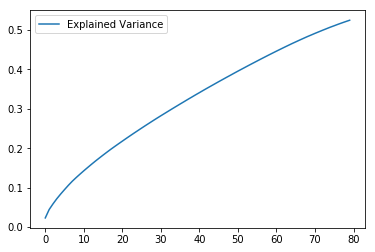

In [68]:
components = pd.DataFrame(np.round(pca.components_, 4))
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
variance_ratios = pd.DataFrame(np.round(ratios.cumsum(), 4), columns = ['Explained Variance']) 
variance_ratios.plot()


In [69]:
reduced_data = pca.transform(all_doc_vecs)
reduced_data.shape

(255818, 80)

In [86]:
z = np.matrix("0.1,0.2,0.3;1.1,1.2,1.3;2.1,2.2,2.3;3.1,3.2,3.3")
from sklearn.preprocessing import normalize
z = (z.T / np.linalg.norm(z,axis = 1)).T
z

matrix([[0.26726124, 0.53452248, 0.80178373],
        [0.5280169 , 0.57601843, 0.62401997],
        [0.55072792, 0.57695306, 0.60317819],
        [0.5591261 , 0.57716242, 0.59519875]])

In [70]:
top_docs(reduced_data)

TOPIC 0
 - Financial Times
 - Financial Times
 - Financial Times
 - Financial Times
 - Financial Times
-------------------------------------------------------
TOPIC 1
             - Washington Post
Trump and the Trade Tariffs - apnorc.org
How Trump Misunderstands Trade - New York Times
Who Said It: Trump or Gotti? - New York Times
Psykiater mener Trump ligger i skjringspunktet mellom narsissisme og psykopati - aftenposten.no
-------------------------------------------------------
TOPIC 2
Jefe de la AEE recomienda revisar subsidios que cuestan millones de dolares - notiuno.com
Informalidad e improductividad, sintomas de la misma enfermedad - animalpolitico.com
BOTAS dolar kurunu sabitledi - cumhuriyet.com.tr
En busca de las raices de la excepcionalidad de la desigualdad en EEUU - ctxt.es - Contexto y Accion
EXCLUSIVA: Secretario de la Gobernacion asegura no habran despidos de empleados publicos - notiuno.com
-------------------------------------------------------
TOPIC 3
@lemasabachthan

TOPIC 30
Why I Am Moving Work Futures to Substack from Medium - workfutures.io
The Future of Work: Technology Will Kill Your Job. Here's How - Medium
Facebook launches news shows from ABC, CNN and more - CNN
World's shortest work weeks - CNN
Turkiye Varlk Fonu Yonetimi A.Sye Dair Paylaslan Belge Iddias - Medium
-------------------------------------------------------
TOPIC 31
Bank & FinTech Collaboration Models  How Big Banks Plan To Stand Up To The Big Tech Challenge - Medium
I Bet I Can Make You A Top Writer on Medium in 7 Days Time - writingcooperative.com
A Rainmaker Seeks to Grow His Firm at a Time of Big Media and Tech Deals - New York Times
Who Is Going To Make Money with Artificial Intelligence? - Medium
Turkiye Varlk Fonu Yonetimi A.Sye Dair Paylaslan Belge Iddias - Medium
-------------------------------------------------------
TOPIC 32
Funds snowball means big firms can only get bigger - Financial Times
Big Banks Are Once Again Taking Risks With Complex Financial Trades, Repor

TOPIC 60
Do This One Thing Before You Start Building Your Business - Entrepreneur
5 Reasons Why Businesses Should Invest in Google AdWords - Entrepreneur
Google is combining Android Pay and Google Wallet into one service called Google Pay - The Verge
Five reasons businesses fail - Business Business Business - businessbusinessbusiness.com.au
We work for Google. It shouldn't be in the business of war - The Guardian
-------------------------------------------------------
TOPIC 61
The People Leading the Blockchain Revolution - New York Times
The Blockchain Data Problem Is Bigger Than You Think - coindesk
Demystifying the Blockchain - New York Times
Wot, no blockchain? - Financial Times
Achmea haakt aan bij blockchain-initiatief autosector - amweb.nl
-------------------------------------------------------
TOPIC 62
Google for Startups: bringing the best of Google to startups everywhere - Google
AI at Google: our principles - Google
mlbscores - Google Search - www.google.com
Incorporating Goo

In [87]:
reduced_data_normed = (reduced_data.T / np.linalg.norm(reduced_data,axis = 1)).T

cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
smallframe['cluster'] = cluster.fit_predict(reduced_data_normed[fp_indexes,:])

plotclusters = smallframe.loc[fp_indexes,:]['cluster']
plotclusters[:10]

66     0
121    1
122    6
160    3
198    1
206    8
214    8
223    8
358    3
374    1
Name: cluster, dtype: int64

In [124]:
with open('docvecs.pkl', 'wb') as output:
    pickle.dump([reduced_data_normed[test_indexes], ohs, plotclusters], output)

headline_scatterplot(do_tsne(reduced_data_normed[test_indexes], perplexity=5), ohs, plotclusters)


In [102]:
smallframe.loc[smallframe['cluster']==12].head(20)

Empty DataFrame
Columns: [id, headline, orig, status, cluster]
Index: []

In [39]:
reduced_data.shape

(255055, 80)

In [38]:
#topics_df = pd.DataFrame(reduced_data)
for i in range(num_topics):
    bigframe["%d" % i] = reduced_data[:, i]

bigframe

id                                           headline  \
0       3602059  todd sullivan instagram dont even try hide jea...   
1       3602050  ai could soon around us could upend different ...   
2       3602042  richardaepstein beginning case single payer ho...   
3       3602035  condition theory obstruct research progress se...   
4       3602023  softly softly british pm may enforcer gear big...   
5       3602022          satisfy part travel flight hotel la_times   
6       3602020  money save tip try spending money month bbc th...   
7       3602017  new_york_city raid condo build crackdown airbn...   
8       3602014  logic point people vote instead face political...   
9       3602012  marine mysterious death world war final day st...   
10      3601997  convict 17n terrorist savvas xiros applies pri...   
11      3601988  tesla others deliver gwh energy storage califo...   
12      3601982  fire tornado possible santa ana wind return ve...   
13      3601976  hundred jail release probe wake floros affair ...   
14      3601971  retailer pay 1bn recycling waste strategy the_...   
15      3601941  alibaba big online shop day time nearly triple...   
16      3601927  prince harry lay wreath ahead england new zeal...   
17      3601924          floating pipe try clean plastic ocean cnn   
18      3601905  democrat probe trump action amazon_com axios r...   
19      3601893  rt editor chief election meddle label russian ...   
20      3601879  video woman drive flame flee malibu wildfire a...   
21      3601875  high tech farmer use lead light way seem borde...   
22      3601863  eu regulator monitor big tech financial_servic...   
23      3601862  without fair tax tech end state know the_guardian   
24      3601856  augment reality pioneer magic leap fallen clif...   
25      3601852  pbc supervisor recount deadline impossible mee...   
26      3601851  nightmare scenario beijing 50 million chinese ...   
27      3601845  california republican face potential loss late...   
28      3601843  silicon_valley democrat channel lincoln tech t...   
29      3601837  genesis orridge always provocateur body shes m...   
...         ...                                                ...   
255788  2826047  china probe deeper life uyghur minority xinjia...   
255789  2826045  redskin reportedly set retain jay gruden head ...   
255790  2826042  kim_jong_un say nuclear launch button office d...   
255791  2826039  kim_jong_un say nuclear button desk announce p...   
255792  2826038  hundred thousand poor american soon able move ...   
255793  2826037  one 10 phone 000 price tag five year time the_...   
255794  2826033  kim_jong_un say us declare war nuclear armed n...   
255795  2826030  important skill age artificial_intelligence ai...   
255796  2826028    first supermoon 2018 coincides new year day cnn   
255797  2826027  instagram_post ayesha siddiqi jan 2018 12 13am...   
255798  2826026  tired tax_reform government finance trend watc...   
255799  2826025  instagram_post leigh drogen jan 2018 21am utc ...   
255800  2826023  urgent leader call mass producing nuke missile...   
255801  2826022  ipo 2018 six tech company could go public mark...   
255802  2826021                  influential 2017 archive coindesk   
255803  2826019  perfect storm small_business loan approval 201...   
255804  2826014  year review 2017 fight normalization lie econb...   
255805  2826013  urgent open talk korea include olympics leader...   
255806  2826010  socketsitetm plan pair swoopy soma tower revea...   
255807  2826009  maam darling craig brown review royal bad char...   
255808  2826008  trouble complacency among world trade minister...   
255809  2826006  chief justice robert say court examine protect...   
255810  2826005                  iran uprising matter the_atlantic   
255811  2825998  american family among 12 kill costa rica plane...   
255812  2825997  google slash price machine_learn service aws s...   
255813  2825992  brown 

In [39]:
# create table

engine = create_engine('mysql://%s:%s@%s:3306/%s' % (seuser, sepass, sehost, sedb)) 
rs = engine.execute('DROP TABLE if exists topics_byid;')
bigframe.to_sql(name='topics_byid',con=engine,if_exists='fail',index=False) 
rs = engine.execute('ALTER TABLE topics_byid ADD PRIMARY KEY (ID);')
rs = engine.execute('SHOW CREATE TABLE topics_byid;')
for row in rs:
    for val in row:
        print(val)

topics_byid
CREATE TABLE `topics_byid` (
  `id` bigint(20) NOT NULL DEFAULT '0',
  `headline` text,
  `orig` text,
  `status` text,
  `0` double DEFAULT NULL,
  `1` double DEFAULT NULL,
  `2` double DEFAULT NULL,
  `3` double DEFAULT NULL,
  `4` double DEFAULT NULL,
  `5` double DEFAULT NULL,
  `6` double DEFAULT NULL,
  `7` double DEFAULT NULL,
  `8` double DEFAULT NULL,
  `9` double DEFAULT NULL,
  `10` double DEFAULT NULL,
  `11` double DEFAULT NULL,
  `12` double DEFAULT NULL,
  `13` double DEFAULT NULL,
  `14` double DEFAULT NULL,
  `15` double DEFAULT NULL,
  `16` double DEFAULT NULL,
  `17` double DEFAULT NULL,
  `18` double DEFAULT NULL,
  `19` double DEFAULT NULL,
  `20` double DEFAULT NULL,
  `21` double DEFAULT NULL,
  `22` double DEFAULT NULL,
  `23` double DEFAULT NULL,
  `24` double DEFAULT NULL,
  `25` double DEFAULT NULL,
  `26` double DEFAULT NULL,
  `27` double DEFAULT NULL,
  `28` double DEFAULT NULL,
  `29` double DEFAULT NULL,
  `30` double DEFAULT NULL,
  `31` dou

For n_clusters = 8 The average silhouette_score is : 0.03931214588964573
For n_clusters = 64 The average silhouette_score is : 0.13163856200034427


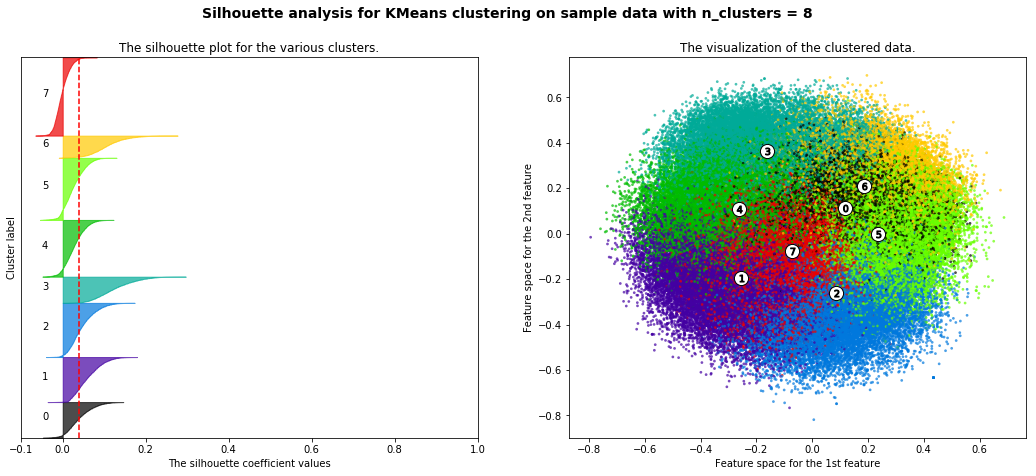

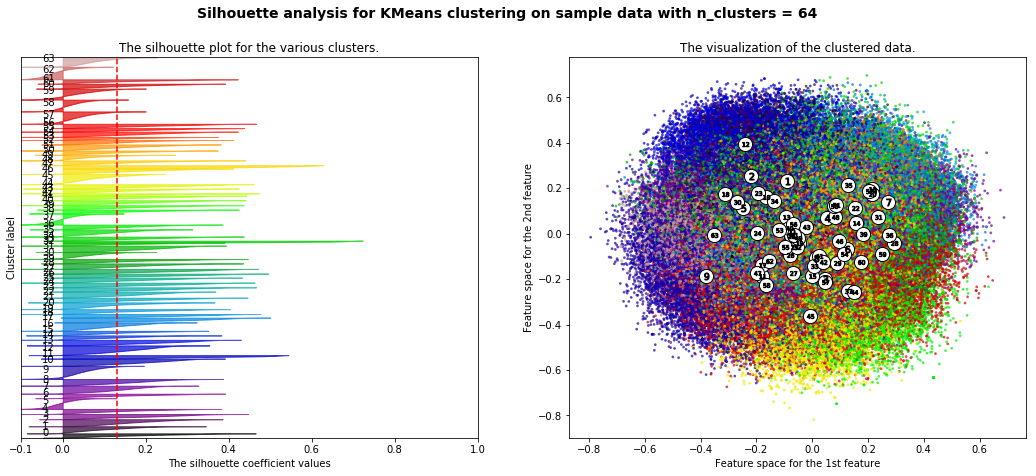

In [125]:
X = reduced_data_normed
range_n_clusters = [8, 64]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()